In [1]:
import numpy as np
import pygimli as pg
#import pybert as pb
from pygimli.physics import ert
#from pybert.importer.exportData import exportRes2dInv
from pygimli.physics.ert.importData import importRes2dInv
import matplotlib.pyplot as plt
import pygimli.meshtools as mt
from pygimli.frameworks import PriorModelling, JointModelling
from scipy.interpolate import interp1d
from scipy.interpolate import PPoly
import pandas as pd
import pickle
from pygimli.viewer.mpl import draw1DColumn, drawSensors
import statsmodels.api as sm
from matplotlib.ticker import LogLocator, LogFormatter
from matplotlib.patches import Rectangle
from matplotlib.patches import Patch
from matplotlib.ticker import MultipleLocator
import matplotlib.image as mpimg
import matplotlib.cm as cm
import pyvista
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import Normalize
import datetime
import re
import os
from scipy.interpolate import splrep, splev


In [2]:
dir='//smb.isipd.dmawi.de/projects/p_subaqua/Expeditions/2023/NWT2023/analysis_Tuk/Tuk_all_mehriban/'

In [91]:
mesh_eastern = pg.load(dir+'pygimli/all_inversions/INV_Eastern_and_south/ERTManager/resistivity-pd.bms')
res_eastern = pg.load(dir+'pygimli/all_inversions/INV_Eastern_and_south/ERTManager/resistivity.vector')
cov_eastern = pg.load(dir+'pygimli/all_inversions/INV_Eastern_and_south/ERTManager/resistivity-cov.vector')

mesh_eastern_newrhoa = pg.load(dir+'pygimli/all_inversions/INV_eastern_new_rhoa_mike/ERTManager/resistivity-pd.bms')
res_eastern_newrhoa = pg.load(dir+'pygimli/all_inversions/INV_eastern_new_rhoa_mike/ERTManager/resistivity.vector')
cov_eastern_newrhoa = pg.load(dir+'pygimli/all_inversions/INV_eastern_new_rhoa_mike/ERTManager/resistivity-cov.vector')

mesh_eastern_perpendicular = pg.load(dir+'pygimli/all_inversions/ERTManager_eastern_perpendicular_mike/ERTManager/resistivity-pd.bms')
res_eastern_perpendicular = pg.load(dir+'pygimli/all_inversions/ERTManager_eastern_perpendicular_mike/ERTManager/resistivity.vector')
cov_eastern_perpendicular = pg.load(dir+'pygimli/all_inversions/ERTManager_eastern_perpendicular_mike/ERTManager/resistivity-cov.vector')

mesh_western = pg.load(dir+'pygimli/all_inversions/ERTManager_western/resistivity-pd.bms')
res_western = pg.load(dir+'pygimli/all_inversions/ERTManager_western/resistivity.vector')
cov_western = pg.load(dir+'pygimli/all_inversions/ERTManager_western/resistivity-cov.vector')

mesh_western_newrhoa = pg.load(dir+'pygimli/all_inversions/INV_western_new_rhoa_mike/ERTManager/resistivity-pd.bms')
res_western_newrhoa = pg.load(dir+'pygimli/all_inversions/INV_western_new_rhoa_mike/ERTManager/resistivity.vector')
cov_western_newrhoa = pg.load(dir+'pygimli/all_inversions/INV_western_new_rhoa_mike/ERTManager/resistivity-cov.vector')

mesh_western_perpendicular = pg.load(dir+'pygimli/all_inversions/ERTManager_western_perpendicular_mike/ERTManager/resistivity-pd.bms')
res_western_perpendicular = pg.load(dir+'pygimli/all_inversions/ERTManager_western_perpendicular_mike/ERTManager/resistivity.vector')
cov_western_perpendicular = pg.load(dir+'pygimli/all_inversions/ERTManager_western_perpendicular_mike/ERTManager/resistivity-cov.vector')

mesh_southeast = pg.load(dir+'pygimli/all_inversions/ERTManager_southeast/resistivity-pd.bms')
res_southeast = pg.load(dir+'pygimli/all_inversions/ERTManager_southeast/resistivity.vector')
cov_southeast = pg.load(dir+'pygimli/all_inversions/ERTManager_southeast/resistivity-cov.vector')

mesh_arenson = pg.load(dir+'pygimli/all_inversions/arenson_updated/ERTManager/resistivity-pd.bms')
res_arenson = pg.load(dir+'pygimli/all_inversions/arenson_updated/ERTManager/resistivity.vector')
cov_arenson = pg.load(dir+'pygimli/all_inversions/arenson_updated/ERTManager/resistivity-cov.vector')

mesh_eastern_center = pg.load(dir+'pygimli/all_inversions/INV_Eastern_centern/ERTManager/resistivity-pd.bms')
res_eastern_center = pg.load(dir+'pygimli/all_inversions/INV_Eastern_centern/ERTManager/resistivity.vector')
cov_eastern_center = pg.load(dir+'pygimli/all_inversions/INV_Eastern_centern/ERTManager/resistivity-cov.vector')

#3d modelling

mesh_hom = pg.load(dir+'pygimli/all_inversions/INV_3d_air_thin/ERTManager/resistivity-pd.bms')
res_hom = pg.load(dir+'pygimli/all_inversions/INV_3d_air_thin/ERTManager/resistivity.vector')
cov_hom = pg.load(dir+'pygimli/all_inversions/INV_3d_air_thin/ERTManager/resistivity-cov.vector')

mesh_thin = pg.load(dir+'pygimli/all_inversions/INV_3d_air_thin/ERTManager/resistivity-pd.bms')
res_thin = pg.load(dir+'pygimli/all_inversions/INV_3d_air_thin/ERTManager/resistivity.vector')
cov_thin = pg.load(dir+'pygimli/all_inversions/INV_3d_air_thin/ERTManager/resistivity-cov.vector')

mesh_mid = pg.load(dir+'pygimli/all_inversions/INV_3d_air_mid/ERTManager/resistivity-pd.bms')
res_mid = pg.load(dir+'pygimli/all_inversions/INV_3d_air_mid/ERTManager/resistivity.vector')
cov_mid = pg.load(dir+'pygimli/all_inversions/INV_3d_air_mid/ERTManager/resistivity-cov.vector')

mesh_wide = pg.load(dir+'pygimli/all_inversions/INV_3d_air_wide/ERTManager/resistivity-pd.bms')
res_wide = pg.load(dir+'pygimli/all_inversions/INV_3d_air_wide/ERTManager/resistivity.vector')
cov_wide = pg.load(dir+'pygimli/all_inversions/INV_3d_air_wide/ERTManager/resistivity-cov.vector')

In [5]:
def mapping_function(file_path_topo, xmin, xmax, ymin, resolution_x, resolution_y, shave_off_top, mesh, res, cov):
    
    topography_coords = np.loadtxt(file_path_topo)
    interpolated_topography = interp1d(topography_coords[:, 0], topography_coords[:, 1], kind='linear', fill_value='extrapolate')
    x = np.arange(xmin, xmax + resolution_x, resolution_x)
    adjusted_topography = []

    for x_val in x:
        y_val = interpolated_topography(x_val)
        adjusted_y_val = max(y_val - shave_off_top, ymin)  
        adjusted_topography.append(adjusted_y_val)


    adjusted_topography = np.array(adjusted_topography)

    grid_points = []

    for x_val, y_val in zip(x, adjusted_topography):
        y_range = np.arange(y_val, ymin - resolution_y, -resolution_y)
        grid_points.extend([(x_val, y) for y in y_range])

    grid_points = np.array(grid_points)

    posVec = [pg.Pos(pos) for pos in zip(grid_points[:, 0], grid_points[:, 1])]
    mesh.setCellMarkers(pg.IVector(mesh.cellCount()))
    fopDP = PriorModelling(mesh, posVec)

    resMesh = fopDP(res)
    covMesh = fopDP(cov)

    out_array = np.column_stack((grid_points[:, 0], grid_points[:, 1], resMesh, covMesh))
    return out_array

In [6]:
#east shoreline 1 = 110
#east shoreline 2 = 240 
#west shoreline 1 = 110
#west shoreline 2 = 280 

def permafrost_table(data, shoreline_1, shoreline_2):
    permafrost_data = []  

    
    for x_value in np.unique(data[:, 0]):
        
        data_x = data[data[:, 0] == x_value]

      
        resistivity_gradient_log = np.diff(np.log10(data_x[:, 2])) / np.diff(data_x[:, 1])

        if x_value < shoreline_1:
            
            valid_gradients_mask = (data_x[:-1, 2] >= 10) & (resistivity_gradient_log < 0)
            valid_gradients = resistivity_gradient_log[valid_gradients_mask]
            valid_depths = data_x[:-1, 1][valid_gradients_mask]
            
        
        elif x_value > shoreline_2:
            
            valid_gradients_mask = (data_x[:-1, 2] >= 10) & (resistivity_gradient_log < 0)
            valid_gradients = resistivity_gradient_log[valid_gradients_mask]
            valid_depths = data_x[:-1, 1][valid_gradients_mask]
            
        
        if len(valid_depths) > 0:
            top_permafrost_depth = valid_depths[0]
            gradient = valid_gradients[0]
            permafrost_data.append((x_value, top_permafrost_depth, gradient))

    
    top_permafrost_depths = np.array(permafrost_data)
    return top_permafrost_depths

In [10]:
def plot_and_save_permafrost_data(data, shoreline_1, shoreline_2, top_permafrost_depths, frac, output_dir, name):
    import numpy as np
    import matplotlib.pyplot as plt
    import statsmodels.api as sm
    
    # Extract x, y, and resistivity values
    x_values = data[:, 0]
    y_values = data[:, 1]
    resistivity_values = data[:, 2]
    
    # Split the top permafrost depths into sections based on shoreline positions
    section1_ibpt_depths = top_permafrost_depths[top_permafrost_depths[:, 0] < shoreline_1]
    section2_ibpt_depths = top_permafrost_depths[top_permafrost_depths[:, 0] > shoreline_2]
    
    # Apply LOWESS smoothing
    lowess = sm.nonparametric.lowess
    smoothed_section1 = lowess(section1_ibpt_depths[:, 1], section1_ibpt_depths[:, 0], frac=frac)
    smoothed_section2 = lowess(section2_ibpt_depths[:, 1], section2_ibpt_depths[:, 0], frac=frac)
    
    smoothed_x1 = smoothed_section1[:, 0]
    smoothed_y1 = smoothed_section1[:, 1]
    smoothed_x2 = smoothed_section2[:, 0]
    smoothed_y2 = smoothed_section2[:, 1]

    # Interpolate resistivity values at smoothed positions
    resistivity_interp1 = np.interp(smoothed_x1, x_values, resistivity_values)
    resistivity_interp2 = np.interp(smoothed_x2, x_values, resistivity_values)
    
    # Plotting
    plt.figure(figsize=(12, 6))
    plt.scatter(x_values, y_values, c=np.log(resistivity_values), cmap='viridis', s=10)
    plt.colorbar(label='log resistivity')
    plt.xlabel('X (m)')
    plt.ylabel('Z (m)')
    plt.title(f'{name} profile with permafrost table')

    plt.plot(section1_ibpt_depths[:, 0], section1_ibpt_depths[:, 1], color='r', linewidth=0.5)
    plt.plot(section2_ibpt_depths[:, 0], section2_ibpt_depths[:, 1], color='r', linewidth=0.5)

    plt.plot(smoothed_x1, smoothed_y1, color='w', linewidth=0.5)
    plt.plot(smoothed_x2, smoothed_y2, color='w', linewidth=0.5)

    # Save data
    # Smoothed depths
    np.save(output_dir + f'{name}_newrhoa_perm_table_smooth1.npy', smoothed_y1)
    np.save(output_dir + f'{name}_newrhoa_perm_table_smooth2.npy', smoothed_y2)
    
    # Original IBPT depths
    np.save(output_dir + f'{name}_newrhoa_perm_table1.npy', section1_ibpt_depths[:, 1])
    np.save(output_dir + f'{name}_newrhoa_perm_table2.npy', section2_ibpt_depths[:, 1])
    
    # X-coordinates for the original IBPT depths
    np.save(output_dir + f'{name}_newrhoa_perm_table_x1.npy', section1_ibpt_depths[:, 0])
    np.save(output_dir + f'{name}_newrhoa_perm_table_x2.npy', section2_ibpt_depths[:, 0])
    
    # Resistivity at smoothed positions
    np.save(output_dir + f'{name}_resistivity_section1.npy', resistivity_interp1)
    np.save(output_dir + f'{name}_resistivity_section2.npy', resistivity_interp2)
    
    # Show the plot
    plt.show()


In [7]:
out_east = mapping_function(dir + "AL/east_interpolated.txt", -10, 380, -40, 0.05, 0.05, 1, mesh_eastern_newrhoa, res_eastern_newrhoa, cov_eastern_newrhoa)
out_west = mapping_function(dir + "AL/west_interpolated.txt", -10, 300, -40, 0.05, 0.05, 1, mesh_western_newrhoa, res_western_newrhoa, cov_western_newrhoa)
out_east_p = mapping_function(dir + "AL/east_p_interpolated.txt", -10, 244, -40, 0.05, 0.05, 1, mesh_eastern_perpendicular, res_eastern_perpendicular, cov_eastern_perpendicular)
out_west_p = mapping_function(dir + "AL/west_p_interpolated.txt", -10, 244, -40, 0.05, 0.05, 1.5, mesh_western_perpendicular, res_western_perpendicular, cov_western_perpendicular)

23/02/25 - 17:05:01 - pyGIMLi - INFO - Found 1 regions.
23/02/25 - 17:06:23 - pyGIMLi - INFO - Found 1 regions.
23/02/25 - 17:07:26 - pyGIMLi - INFO - Found 1 regions.
23/02/25 - 17:08:25 - pyGIMLi - INFO - Found 1 regions.


In [8]:
east_top_permafrost_depths = permafrost_table(out_east, 115, 255)
west_top_permafrost_depths = permafrost_table(out_west, 110, 180)

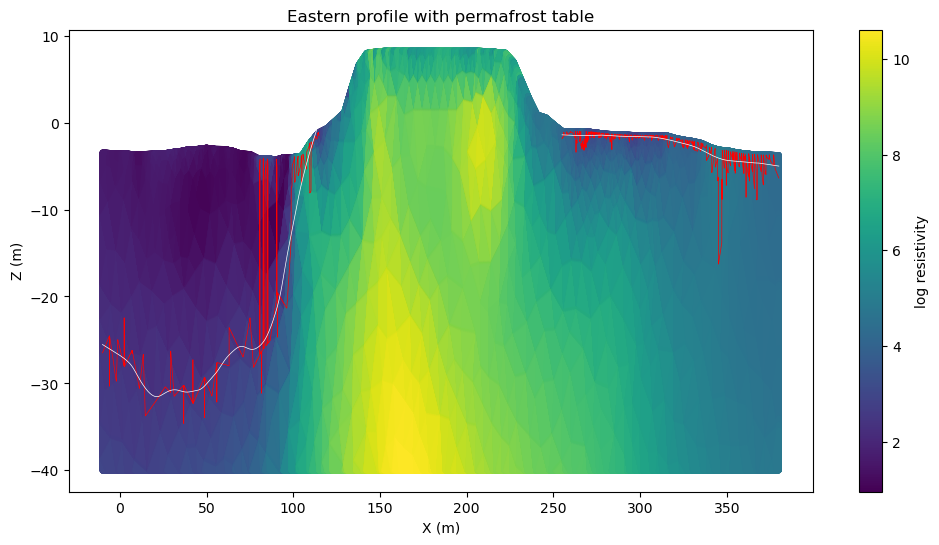

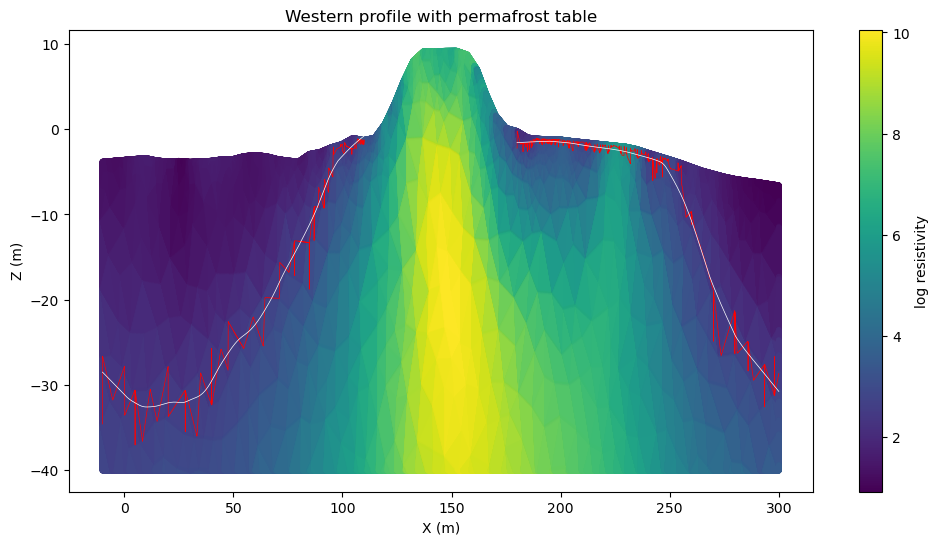

In [11]:
plot_and_save_permafrost_data(out_east, 115, 255, east_top_permafrost_depths, 0.2, dir+ 'pygimli/', 'Eastern')
plot_and_save_permafrost_data(out_west, 110, 180, west_top_permafrost_depths, 0.2, output_dir=dir+ 'pygimli/', name='Western')

23/02/25 - 17:35:56 - pyGIMLi - INFO - could not read unified data format for ERT ... try res2dinv
23/02/25 - 17:35:57 - pyGIMLi - INFO - could not read unified data format for ERT ... try res2dinv
23/02/25 - 17:35:57 - pyGIMLi - INFO - Cache c:\Users\mealiy001\AppData\Local\anaconda3\envs\pgcore\Lib\site-packages\pygimli\physics\ert\ert.py:createGeometricFactors restored (1.6s x 32): C:\Users\mealiy001\AppData\Roaming\pygimli\Cache\7107516685755831498
23/02/25 - 17:35:57 - pyGIMLi - INFO - Cache c:\Users\mealiy001\AppData\Local\anaconda3\envs\pgcore\Lib\site-packages\pygimli\physics\ert\ert.py:createGeometricFactors restored (0.0s x 32): C:\Users\mealiy001\AppData\Roaming\pygimli\Cache\5525447937356186559
23/02/25 - 17:35:57 - pyGIMLi - INFO - Cache c:\Users\mealiy001\AppData\Local\anaconda3\envs\pgcore\Lib\site-packages\pygimli\physics\ert\ert.py:createGeometricFactors restored (4.8s x 32): C:\Users\mealiy001\AppData\Roaming\pygimli\Cache\2338284238765559255
23/02/25 - 17:35:57 - pyG

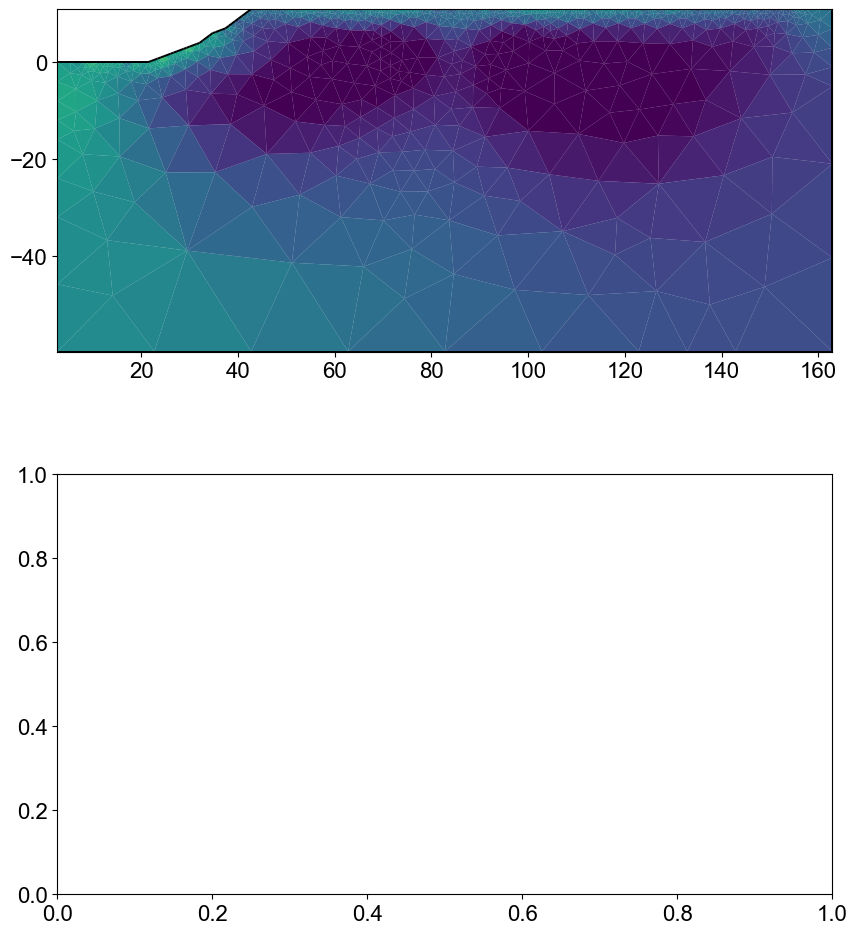

C:\Users\mealiy001\AppData\Local\Temp\ipykernel_13876\1045837927.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels([f"{tick:.1f}" for tick in relative_ticks])
C:\Users\mealiy001\AppData\Local\Temp\ipykernel_13876\1045837927.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels([f"{tick:.1f}" for tick in relative_ticks])


<Figure size 640x480 with 0 Axes>

In [12]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pygimli as pg  # assuming pg is an alias for PyGIMLi
from matplotlib.ticker import MultipleLocator

plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = 'Arial'
plt.style.use('seaborn-v0_8-colorblind')

data_e = ert.load(dir+"res2dinv_inputs/transects_split_in_three/amphibious_ERT_eastern_transect_gps_center.dat")
data_a = ert.load(dir+"processing/arenson/arenson_updated.dat")

#data.setSensorPositions(pg.meshtools.interpolateAlongCurve(data.additionalPoints(), pg.x(data)))
data_e['k'] = ert.createGeometricFactors(data_e, numerical=True)
mgr = ert.ERTManager(sr=False)
k0 = ert.createGeometricFactors(data_e)
data_e['err'] = ert.estimateError(data_e, relativeError=0.03, absoluteUError=5e-5)

data_a['k'] = ert.createGeometricFactors(data_a, numerical=True)
mgr = ert.ERTManager(sr=False)
k0 = ert.createGeometricFactors(data_a)
data_a['err'] = ert.estimateError(data_a, relativeError=0.03, absoluteUError=5e-5)

# Define common normalization and colormap for linear scale
cmin = 1
cmax = 10000
cmap = "viridis_r"

# Create a 1x2 grid of subplots
fig, ax = plt.subplots(2, 1, figsize=(10, 12))

# Plot on the subplots with the common normalization and colormap
pg.show(mesh_arenson, res_arenson, cMap=cmap, ax=ax[0], colorBar=False, cMin=cmin, cMax=cmax,logScale=True, sharey = True, coverage=cov_arenson)
pg.show(mesh_eastern_center, res_eastern_center, cMap=cmap, ax=ax[1], colorBar=False, cMin=cmin, cMax=cmax, logScale=True, sharey = True, coverage=cov_eastern_center)


cax = fig.add_axes([0.01, 0.04, 0.98, 0.02])  
colorbar1 = pg.viewer.mpl.createColorBarOnly(ax=cax, cMin=cmin, cMax=cmax, logScale=True, cMap="viridis_r")


ax[1].set_title('2023')
ax[0].set_title('2018')

ax[0].set_ylim(-50, 15)
ax[1].set_ylim(-50, 15)

ax[0].invert_xaxis()
#ax[1].invert_xaxis()

current_ticks = ax[0].get_yticks()
relative_ticks = current_ticks   # Assuming 17 is the minimum elevation

# Set the new tick labels to show relative elevation

ax[0].set_yticklabels([f"{tick:.1f}" for tick in relative_ticks])
ax[0].set_ylabel("Relative Elevation (m)")
ax[1].set_yticklabels([f"{tick:.1f}" for tick in relative_ticks])
ax[1].set_ylabel("Relative Elevation (m)")

ax[0].set_aspect(1.06)

cax.xaxis.set_major_locator(LogLocator(base=10.0))
cax.xaxis.set_major_formatter(LogFormatter(labelOnlyBase=False))
cax.set_xlabel('Resistivity (Ohm-m)')

plt.savefig(dir + 'paper/figures/arenson_figure.png', dpi=300, bbox_inches='tight')

plt.show()


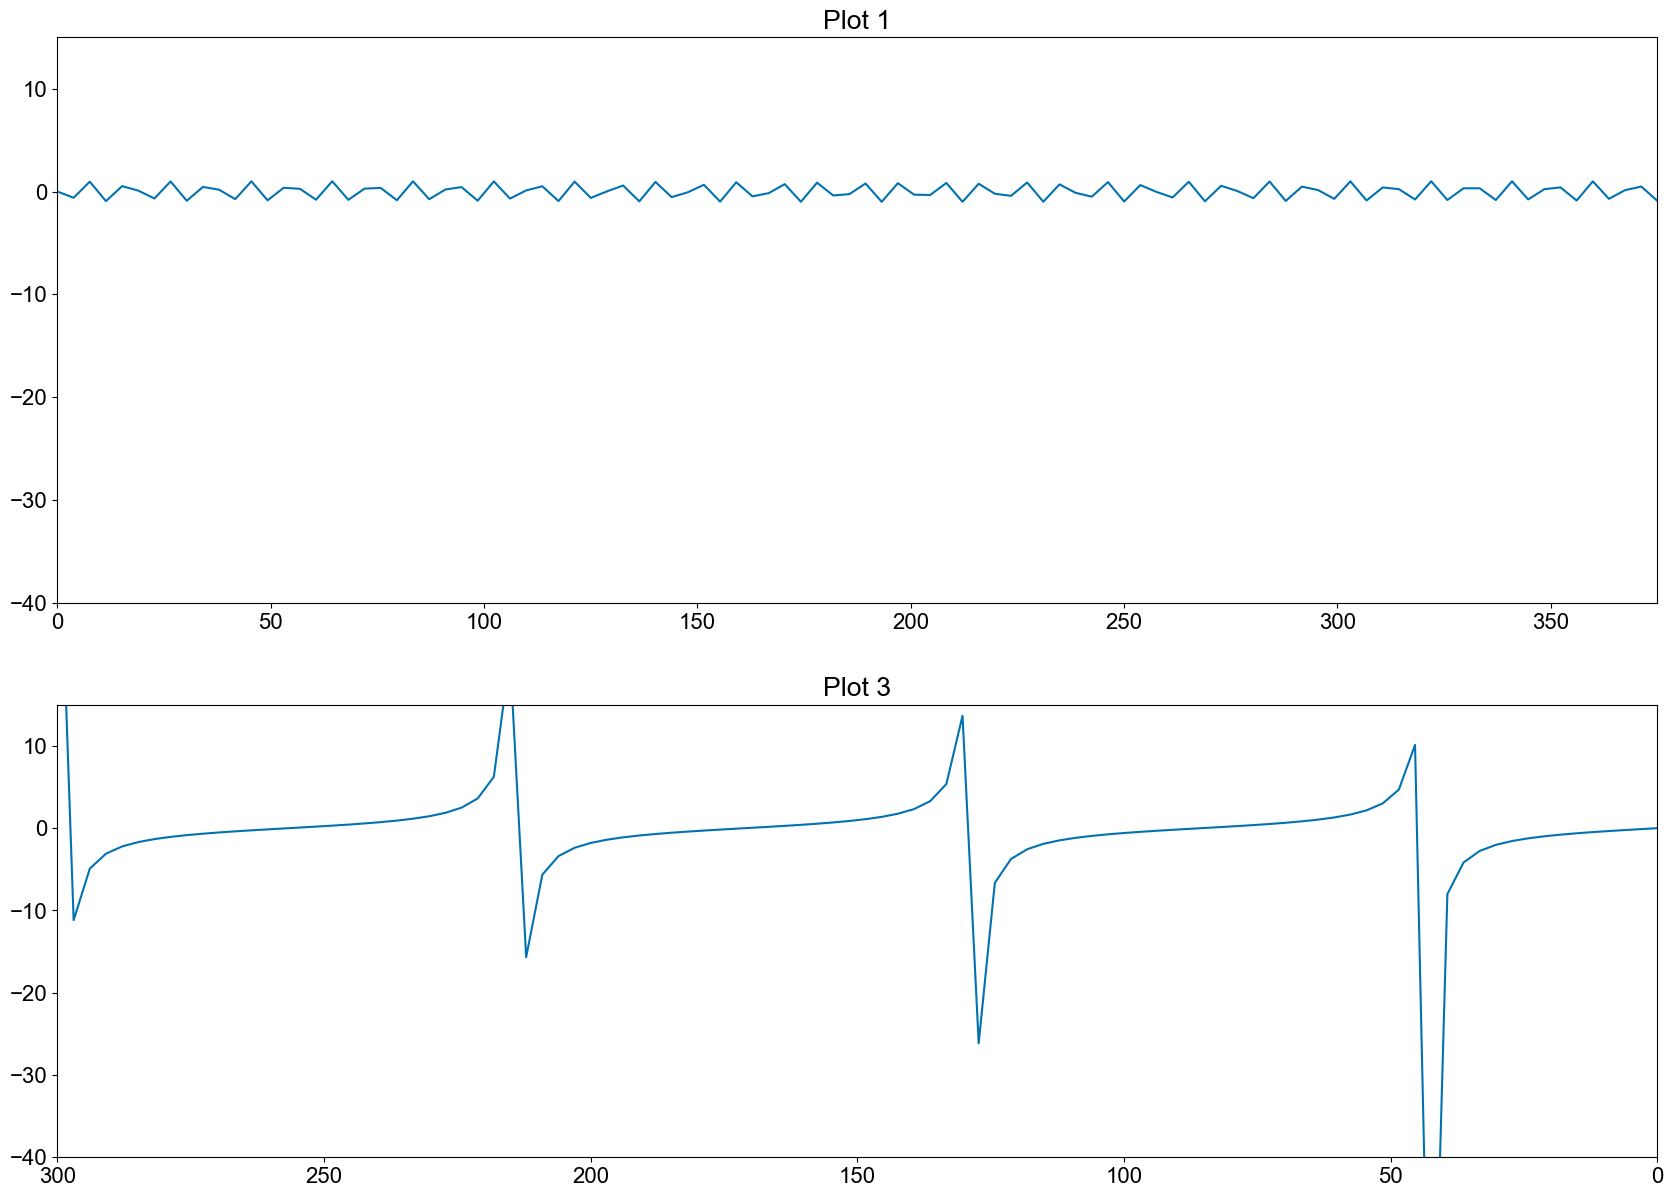

In [13]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

# Example data for plotting
x1 = np.linspace(375, 0, 100)
y1 = np.sin(x1)

x3 = np.linspace(300, 0, 100)
y3 = np.tan(x3)

# Create a figure
fig = plt.figure(figsize=(40, 28))

# Define the GridSpec layout with specified ratios
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 0.8])

# Create the first subplot in the first row and first column
ax0 = fig.add_subplot(gs[0])
ax0.plot(x1, y1)
ax0.set_xlim(0, 375)
ax0.set_ylim(-40, 15)
ax0.set_title('Plot 1')


ax2 = fig.add_subplot(gs[1])
ax2.plot(x3, y3)
ax2.set_xlim(300, 0)
ax2.set_ylim(-40, 15)
ax2.set_title('Plot 3')

fig.subplots_adjust(left=0.3, right=0.7, bottom=0.3, top=0.7)

# Get the bounding boxes of the subplots
bbox0 = ax0.get_position()

bbox2 = ax2.get_position()

# Extract the coordinates from the bounding boxes
x0_0, y0_0, width_0, height_0 = bbox0.x0, bbox0.y0, bbox0.width, bbox0.height
x0_2, y0_2, width_2, height_2 = bbox2.x0, bbox2.y0, bbox2.width, bbox2.height


Values in val: [(0, -0.9, 'Ice'), (-0.9, -2.4, 'Unfrozen Matter'), (-2.4, -17.6, 'Ice Bonded Permafrost')]
Values in val: [(0, -0.9, 'Ice'), (-0.9, -2.1, 'Water'), (-2.1, -5.2, 'Unfrozen Matter'), (-5.2, -14.6, 'Ice Bonded Permafrost')]


C:\Users\mealiy001\AppData\Local\Temp\ipykernel_13876\3951355803.py:207: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax0.set_yticklabels([f"{tick:.1f}" for tick in relative_ticks])
C:\Users\mealiy001\AppData\Local\Temp\ipykernel_13876\3951355803.py:209: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([f"{tick:.1f}" for tick in relative_ticks])


Text(0.5, 358.2909722222222, 'Resistivity ($\\Omega$m)')

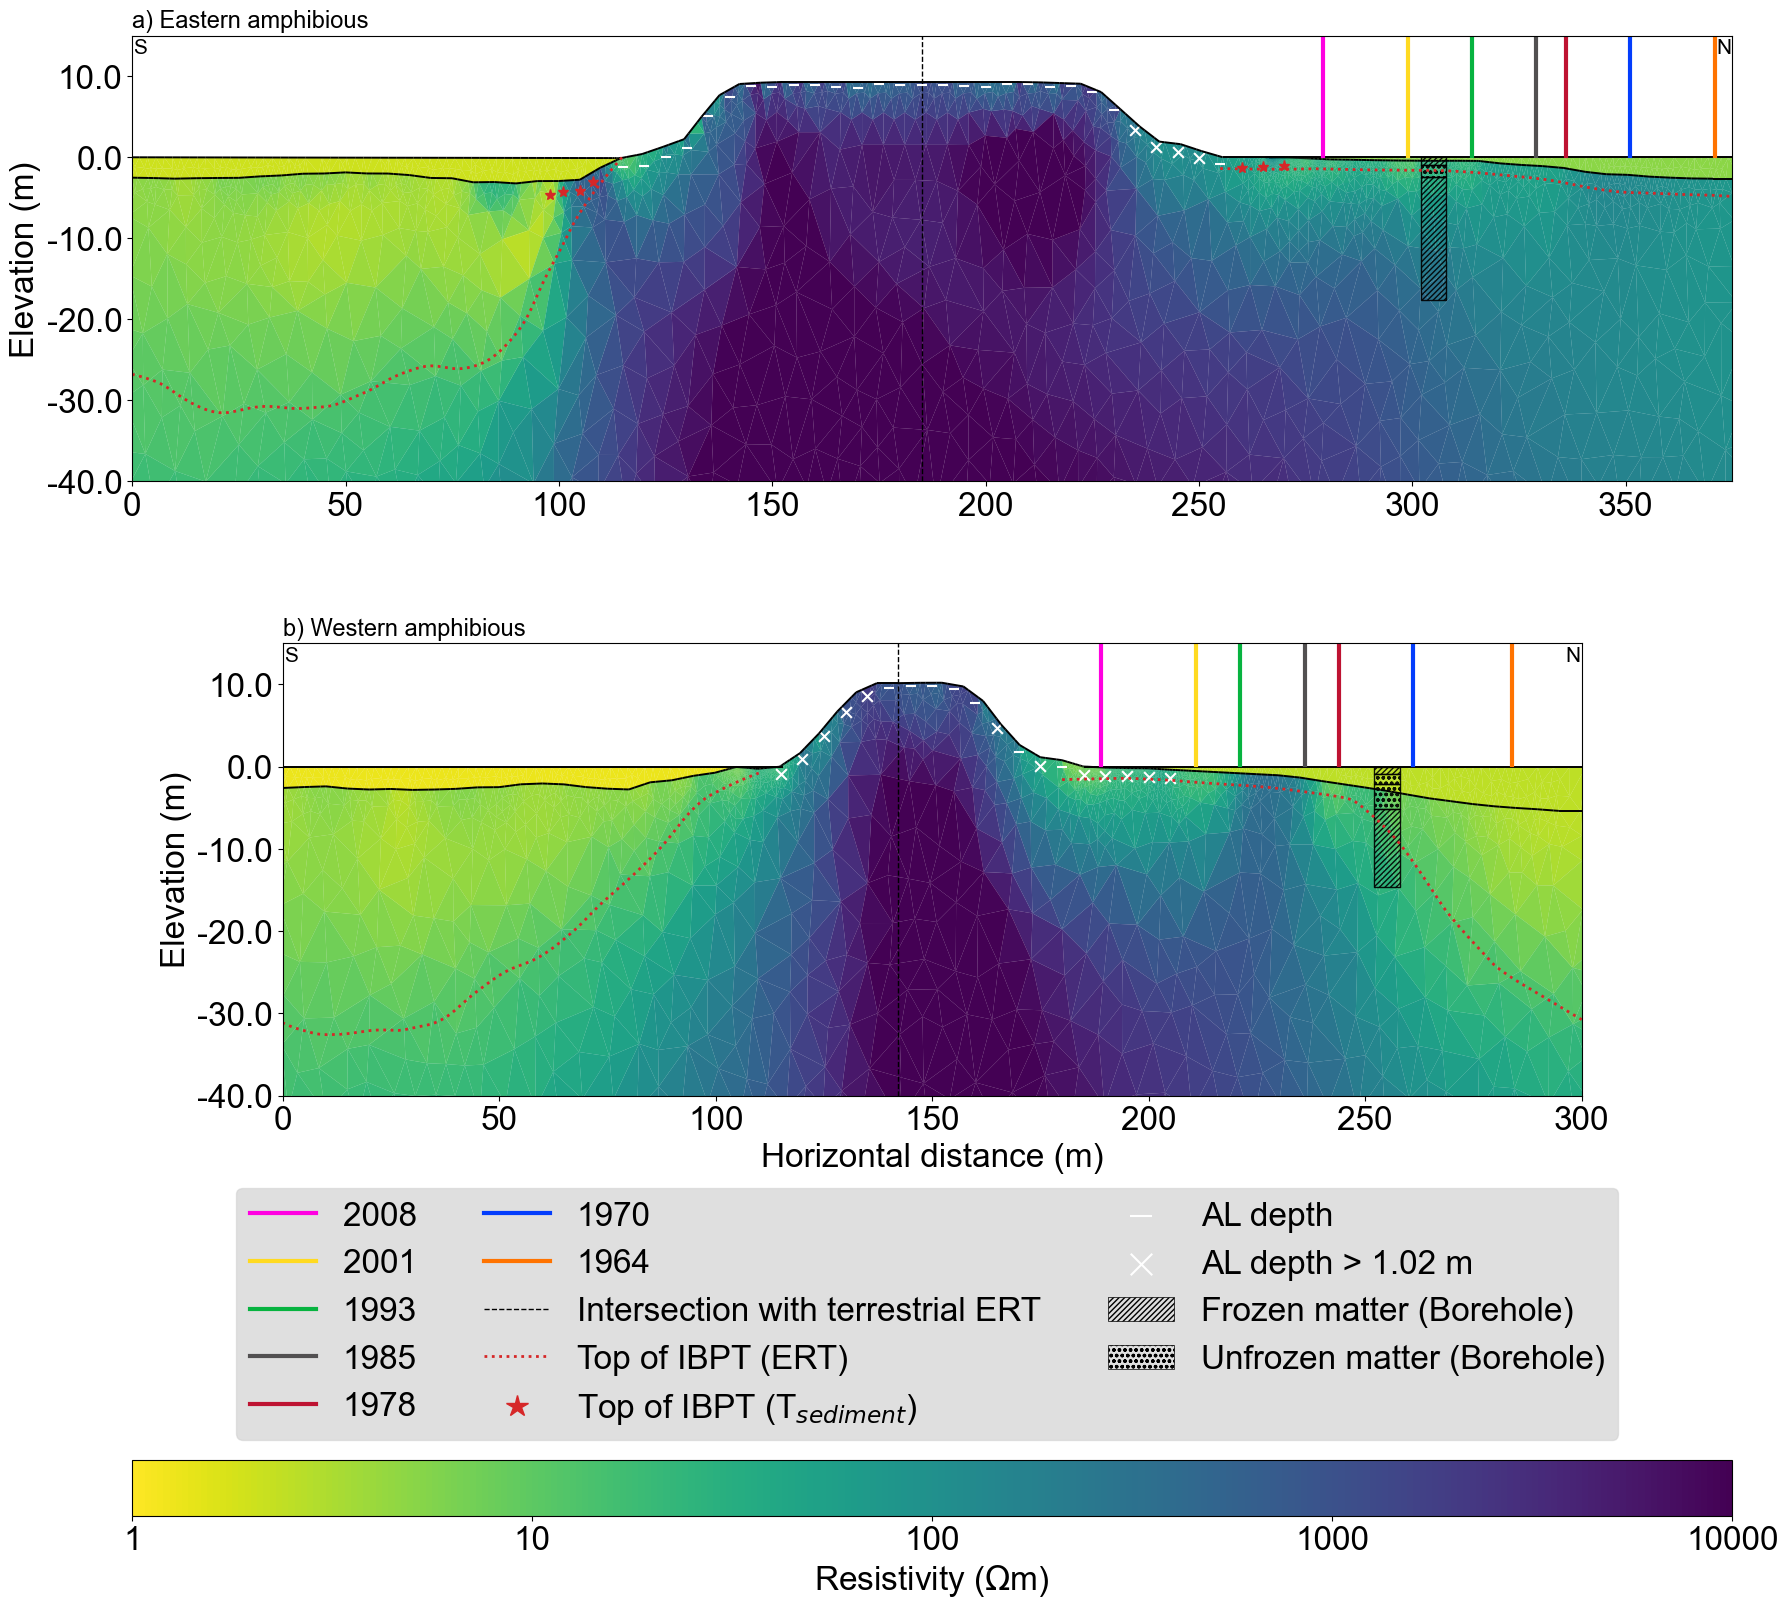

In [119]:
import webbrowser
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import Normalize
from scipy.interpolate import PchipInterpolator




east_shore_df = pd.read_csv(dir + "pygimli/shorelines_gimli_eastern.csv")
west_shore_df = pd.read_csv(dir + "pygimli/shorelines_gimli_western.csv")

east_interpolated = np.loadtxt(dir + "AL/east_interpolated.txt")
west_interpolated = np.loadtxt(dir + "AL/west_interpolated.txt")

interpolated_topography_east = interp1d(east_interpolated[:, 0], east_interpolated[:, 1], kind='slinear', fill_value='extrapolate')
interpolated_topography_west = interp1d(west_interpolated[:, 0], west_interpolated[:, 1], kind='slinear', fill_value='extrapolate')

x_east = np.arange(0, 375 + 1, 1)
x_west = np.arange(0, 300 + 1, 1)
adjusted_topography_east = []
adjusted_topography_west = []

for x_val in x_east:
    y_val = interpolated_topography_east(x_val)
    adjusted_topography_east.append(y_val)
adjusted_topography_east

for x_val in x_west:
    y_val = interpolated_topography_west(x_val)
    adjusted_topography_west.append(y_val)
adjusted_topography_west

plt.rcParams['font.size'] = 24
plt.rcParams['font.family'] = 'Arial'
plt.style.use('seaborn-v0_8-colorblind')
cMin=1
cMax=10000


# Define colors for the custom colormap
colors = ['#ff7300', '#003cff', '#be1332', '#515151', '#07b340', '#ffdd1f', '#ff00e1']  # Blue to green to yellow to red
cmap_name = 'custom_cmap'

# Create the colormap
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=256)
custom_cmap= custom_cmap.reversed()


east_shore = east_shore_df.to_numpy()
west_shore = west_shore_df.to_numpy()

borehole4 = pd.read_csv(dir + "pygimli/borehole4.csv")
borehole2 = pd.read_csv(dir + "pygimli/borehole2.csv")

def draw1DColumn(ax, x, val, thk, hatch_patterns):
    print("Values in val:", val)
    bottom = 0
    for v, t in zip(val, thk):
        material_type = v[2]  
        if material_type not in hatch_patterns:
            print("Error: Hatch pattern not found for material:", v)
            continue
        hatch = hatch_patterns[material_type]
        ax.bar(x, t, bottom=bottom, width=6, edgecolor='black', alpha=0.9, facecolor='none', hatch=hatch, linewidth=1)
        bottom += t


borehole2_data = [(0, -0.9, 'Ice'), (-0.9, -2.1, 'Water'), (-2.1, -5.2, 'Unfrozen Matter'), (-5.2, -14.6, 'Ice Bonded Permafrost')]
borehole4_data = [(0, -0.9, 'Ice'), (-0.9, -2.4, 'Unfrozen Matter'), (-2.4, -17.6, 'Ice Bonded Permafrost')]

hatch_patterns = {'Ice': '//////', 'Water': 'ooo', 'Unfrozen Matter': 'ooo', 'Ice Bonded Permafrost': '//////'}

east_AL = pd.read_csv(dir+"AL/east_amph_AL.txt", sep='\s+')
west_AL = pd.read_csv(dir+"AL/west_amph_AL.txt", sep='\s+')

e_permafrost_table1 = np.load(dir+ 'pygimli/Eastern_newrhoa_perm_table1.npy')
e_permafrost_table_smooth1 = np.load(dir+ 'pygimli/Eastern_newrhoa_perm_table_smooth1.npy')
e_permafrost_table_x1 = np.load(dir+ 'pygimli/Eastern_newrhoa_perm_table_x1.npy')

e_permafrost_table2 = np.load(dir+ 'pygimli/Eastern_newrhoa_perm_table2.npy')
e_permafrost_table_smooth2 = np.load(dir+ 'pygimli/Eastern_newrhoa_perm_table_smooth2.npy')
e_permafrost_table_x2 = np.load(dir+ 'pygimli/Eastern_newrhoa_perm_table_x2.npy')

w_permafrost_table1 = np.load(dir+ 'pygimli/Western_newrhoa_perm_table1.npy')
w_permafrost_table_smooth1 = np.load(dir+ 'pygimli/Western_newrhoa_perm_table_smooth1.npy')
w_permafrost_table_x1 = np.load(dir+ 'pygimli/Western_newrhoa_perm_table_x1.npy')

w_permafrost_table2 = np.load(dir+ 'pygimli/Western_newrhoa_perm_table2.npy')
w_permafrost_table_smooth2 = np.load(dir+ 'pygimli/Western_newrhoa_perm_table_smooth2.npy')
w_permafrost_table_x2 = np.load(dir+ 'pygimli/Western_newrhoa_perm_table_x2.npy')


fig, ax = plt.subplots(2, 1, figsize=(40, 28), sharey=True)
ax0 = ax[0]
ax2 = ax[1]

pg.show(mesh_eastern_newrhoa, res_eastern_newrhoa,sharey=True, logScale=True, cMap="viridis_r", ax=ax0, cMin=cMin, cMax=cMax, colorBar=False)
pg.show(mesh_western_newrhoa, res_western_newrhoa, sharey=True, logScale=True, cMap="viridis_r", ax=ax2, cMin=cMin, cMax=cMax, colorBar=False)


ax0.set_ylim(-40, 15)
ax0.set_ylabel("Depth (m)")
ax2.set_ylim(-40, 15)
ax2.set_xlim(0, 300)
ax0.set_xlim(0, 375)



ax0.text(0.3, 12.8, "S", fontsize=15)
ax0.text(371.2, 12.8, "N", fontsize=15)
ax2.text(0.3, 12.8, "S", fontsize=15)
ax2.text(296.2, 12.8, "N", fontsize=15)
ax0.set_title('a) Eastern amphibious', loc='left', fontsize=17)
ax2.set_title('b) Western amphibious', loc='left', fontsize=17)
ax2.set_ylabel("Depth (m)")

ax0.set_position([x0_0, y0_0, width_0, height_0])
ax2.set_position([x0_2, y0_2, width_2, height_2])

ax0.set_aspect(1.9)
ax2.set_aspect(1.9)


draw1DColumn(ax0, 305, borehole4_data, [item[1] - item[0] for item in borehole4_data], hatch_patterns)
draw1DColumn(ax2, 255, borehole2_data, [item[1] - item[0] for item in borehole2_data], hatch_patterns)


# Assuming `custom_cmap` is already created as shown earlier
norm_east = Normalize(vmin=0, vmax=len(east_shore) - 1)
norm_west = Normalize(vmin=0, vmax=len(west_shore) - 1)

for i in range(len(east_shore)):
    year_east = float(east_shore[i, 1])
    label_east = east_shore[i, 2]
    color = custom_cmap(norm_east(i))  # Get color from the colormap
    ax0.axvline(year_east, color=color, ymin=0.73, linewidth=3, label=label_east)

for i in range(len(west_shore)):
    year_west = float(west_shore[i, 1])
    label_west = west_shore[i, 2]
    color = custom_cmap(norm_west(i))  # Get color from the colormap
    ax2.axvline(year_west, color=color, ymin=0.73, linewidth=3, label=label_west)

ax0.axvline(185, color='black', linestyle= '--', linewidth=1, label='Intersection with terrestrial ERT')
ax2.axvline(142, color='black', linewidth=1, linestyle= '--')

line1s, = ax0.plot(e_permafrost_table_x1, e_permafrost_table_smooth1,  ":",linewidth=2, color='tab:red', label='Top of IBPT (ERT)')
line2s, = ax0.plot(e_permafrost_table_x2, e_permafrost_table_smooth2,  ":",linewidth=2, color='tab:red')
line4s, = ax2.plot(w_permafrost_table_x1, w_permafrost_table_smooth1,  ":",linewidth=2, color='tab:red')
line5s, = ax2.plot(w_permafrost_table_x2, w_permafrost_table_smooth2,  ":",linewidth=2, color='tab:red')

#line1, = ax0.plot(e_permafrost_table_x1, e_permafrost_table1, ":", linewidth=2, color='red', label='Permafrost Table')
#line2, = ax0.plot(e_permafrost_table_x2, e_permafrost_table2, ":", linewidth=2, color='red')
#line4, = ax2.plot(w_permafrost_table_x1, w_permafrost_table1, ":", linewidth=2, color='red')
#line5, = ax2.plot(w_permafrost_table_x2, w_permafrost_table2, ":", linewidth=2, color='red')
ax0.plot(270, adjusted_topography_east[270] - 1.1, '*', color='tab:red',markersize=8, label=r'Top of IBPT (T$_{sediment}$)')
ax0.plot(265,adjusted_topography_east[265]-1.25,'*', color='tab:red',markersize=8) 
ax0.plot(260,adjusted_topography_east[260]-1.35,'*', color='tab:red',markersize=8) 
ax0.plot(108,adjusted_topography_east[108]-1.25,'*', color='tab:red',markersize=8) 
ax0.plot(105,adjusted_topography_east[105]-1.36,'*', color='tab:red',markersize=8) 
ax0.plot(101,adjusted_topography_east[101]-1.36,'*', color='tab:red',markersize=8) 
ax0.plot(98,adjusted_topography_east[98]-1.7,'*', color='tab:red',markersize=8) 


adjusted_topography_east = np.array(adjusted_topography_east)
adjusted_topography_west = np.array(adjusted_topography_west)

matching_indices_east = np.arange(0, 376, 5)  # [0, 5, 10, ..., 375]
matching_indices_west = np.arange(0, 301, 5)  # [0, 5, 10, ..., 300]

# Select topography for the matching indices
selected_topography_east = adjusted_topography_east[matching_indices_east]
selected_topography_west = adjusted_topography_west[matching_indices_west]

# Condition where AL == 1.02
exclude_east = east_AL['AL'].values == 1.02  # Convert to numpy array for comparison
exclude_west = west_AL['AL'].values == 1.02  # Convert to numpy array for comparison


# Plot the points excluding AL == 1.02 for East and West
ax0.scatter(east_AL['Distance'][~exclude_east], selected_topography_east[~exclude_east] - east_AL['AL'].values[~exclude_east], color='white', marker="_", s=60, label="AL depth")
ax2.scatter(west_AL['Distance'][~exclude_west], selected_topography_west[~exclude_west] - west_AL['AL'].values[~exclude_west], color='white', marker="_", s=60)

# Highlight the points where AL == 1.02 with a different symbol ('x')
ax0.scatter(east_AL['Distance'][exclude_east], selected_topography_east[exclude_east] - east_AL['AL'].values[exclude_east], color='white', marker='x', s=60, label="AL depth > 1.02 m")
ax2.scatter(west_AL['Distance'][exclude_west], selected_topography_west[exclude_west] - west_AL['AL'].values[exclude_west], color='white', marker='x', s=60, )


hatch_patterns = {'Frozen matter (Borehole)': '//////', 'Unfrozen matter (Borehole)': 'ooo'}
handles, labels = ax0.get_legend_handles_labels()


legend_patches = [Rectangle((0, 0), 1, 1, fc='none', ec='black', lw=0.5, hatch=hatch_patterns[mat]) for mat in hatch_patterns]



extended_symbol_patch = plt.Line2D([0, 0.5], [0, 0], color='g', linewidth=2)
all_handles = handles + legend_patches 



current_ticks = ax[0].get_yticks()
relative_ticks = current_ticks   # Assuming 17 is the minimum elevation

# Set the new tick labels to show relative elevation

ax0.set_yticklabels([f"{tick:.1f}" for tick in relative_ticks])
ax0.set_ylabel("Elevation (m)")
ax2.set_yticklabels([f"{tick:.1f}" for tick in relative_ticks])
ax2.set_ylabel("Elevation (m)")
ax0.set_xlabel("")
ax2.set_xlabel("Horizontal distance (m)")

ax0.legend(handles=all_handles, labels=labels + list(hatch_patterns.keys()), loc=(0.065, -2.15), facecolor='silver',fontsize=24, ncol=3, framealpha=0.5,markerscale=2)

cax = fig.add_axes([0.3, 0.15, 0.4, 0.02])  

colorbar = pg.viewer.mpl.createColorBarOnly(ax=cax, logScale=True, cMin=cMin, cMax= cMax, cMap="viridis_r")

cax.xaxis.set_major_locator(LogLocator(base=10.0))
cax.xaxis.set_major_formatter(LogFormatter(labelOnlyBase=True))
cax.set_xlabel('Resistivity ($\Omega$m)', fontsize=24)
#plt.savefig(dir+'paper/figures/main_figure.png')


In [39]:
e_permafrost_table_smooth2

array([-25.55366592, -25.55998751, -25.56630753, ...,  -0.29466708,
        -0.24121556,  -0.18779274])

In [19]:
e_permafrost_table2 = e_permafrost_table2.reshape(-1, 1)
e_permafrost_table_smooth2 = e_permafrost_table_smooth2.reshape(-1, 1)
e_permafrost_table_x2 = e_permafrost_table_x2.reshape(-1, 1)

w_permafrost_table2 = w_permafrost_table2.reshape(-1, 1)
w_permafrost_table_smooth2 = w_permafrost_table_smooth2.reshape(-1, 1)
w_permafrost_table_x2 = w_permafrost_table_x2.reshape(-1, 1)

# Horizontally stack arrays as separate columns
permafrost_table_east = np.hstack((e_permafrost_table2, e_permafrost_table_smooth2, np.round(e_permafrost_table_x2, decimals=1)))
permafrost_table_west = np.hstack((w_permafrost_table2, w_permafrost_table_smooth2, np.round(w_permafrost_table_x2, decimals=1)))
permafrost_table_east
east_shore
permafrost_table_east_years = permafrost_table_east[np.isin(permafrost_table_east[:, 2], east_shore[:, 1])]
permafrost_table_west_years = permafrost_table_west[np.isin(permafrost_table_west[:, 2], west_shore[:, 1])]
permafrost_table_west_years


array([[ -1.19644689,  -1.46856586, 189.        ],
       [ -1.19784924,  -1.46801708, 189.        ],
       [ -2.0894342 ,  -1.90817112, 211.        ],
       [ -2.140786  ,  -1.91013494, 211.        ],
       [ -2.2597942 ,  -2.24866335, 221.        ],
       [ -2.311146  ,  -2.25039357, 221.        ],
       [ -3.26750251,  -3.07012678, 236.        ],
       [ -3.22169892,  -3.07365526, 236.        ],
       [ -3.81598227,  -3.66227707, 244.        ],
       [ -3.669899  ,  -3.66678758, 244.        ],
       [-11.00335015, -11.47792604, 261.        ],
       [-11.05790917, -11.5153393 , 261.        ],
       [-25.39005364, -25.69380125, 284.        ],
       [-25.39206303, -25.71102194, 284.        ]])

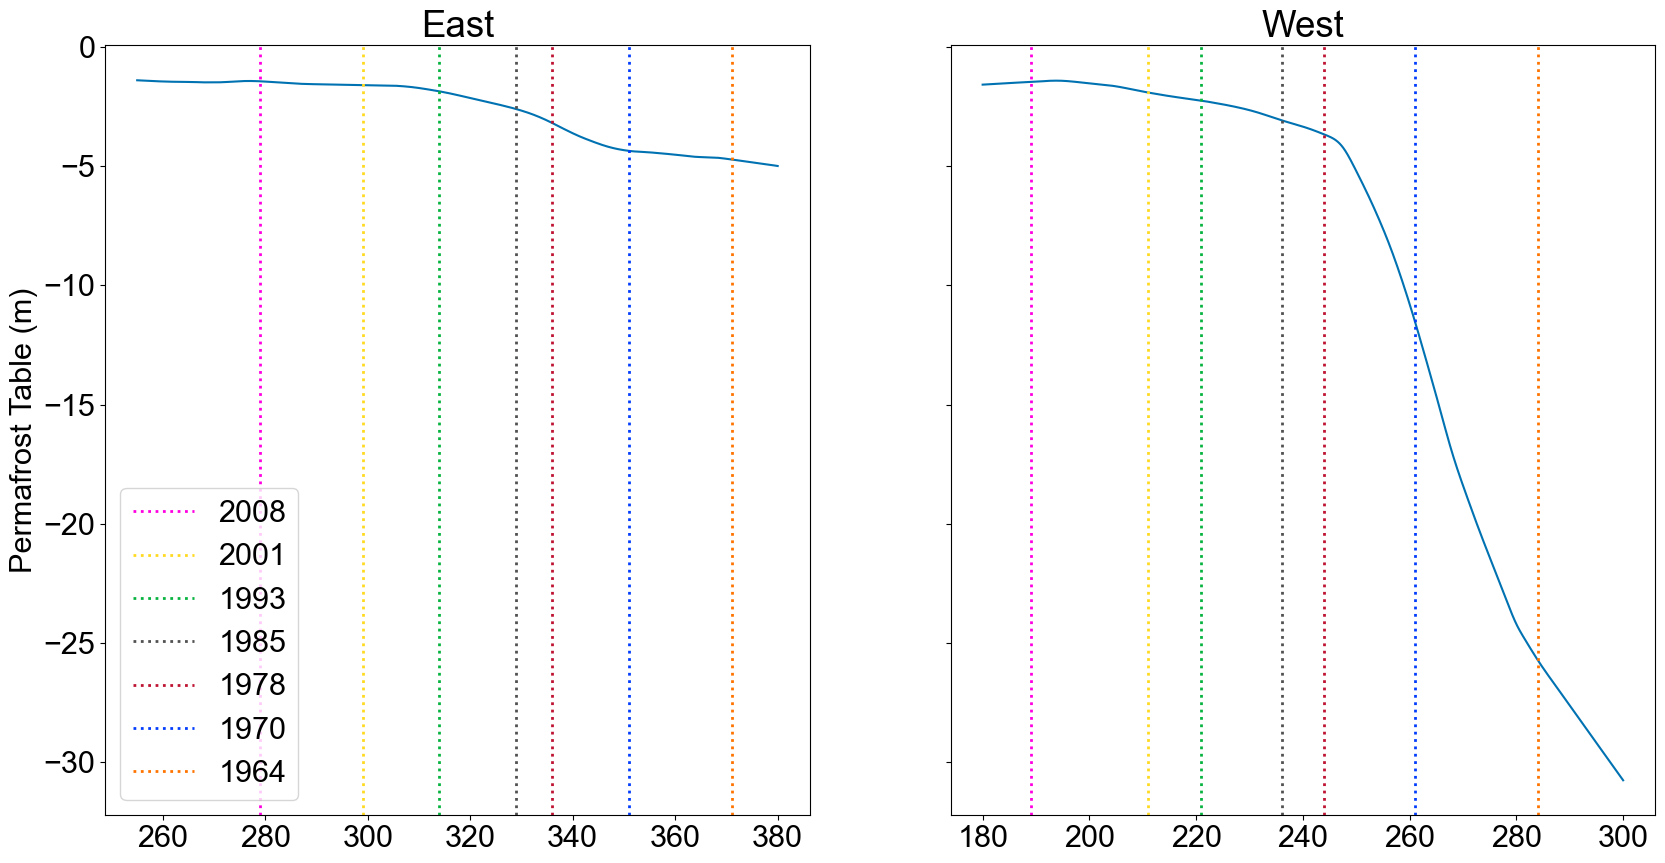

In [109]:
colors = ['#ff7300', '#003cff', '#be1332', '#515151', '#07b340', '#ffdd1f', '#ff00e1']  # Blue to green to yellow to red
cmap_name = 'custom_cmap'

# Create the colormap
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=256)
custom_cmap= custom_cmap.reversed()

fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharey=True)
ax[0].plot(e_permafrost_table_x2,e_permafrost_table_smooth2)
ax[1].plot(w_permafrost_table_x2,w_permafrost_table_smooth2)
for i in range(len(east_shore)):
    year_east = float(east_shore[i, 1])
    label_east = east_shore[i, 2]
    color = custom_cmap(norm_east(i))  # Get color from the colormap
    ax[0].axvline(year_east, color=color, linewidth=2, label=label_east, linestyle=":")

for i in range(len(west_shore)):
    year_west = float(west_shore[i, 1])
    label_west = west_shore[i, 2]
    color = custom_cmap(norm_west(i))  # Get color from the colormap
    ax[1].axvline(year_west, color=color, linewidth=2, label=label_west, linestyle=":")

ax[0].set_ylabel("Permafrost Table (m)")
ax[0].set_title("East")
ax[1].set_title("West")
ax[0].legend(loc='best')


In [ ]:
permafrost_table_west

In [21]:
east_dip_rate = np.gradient(e_permafrost_table_smooth2, e_permafrost_table_x2)
west_dip_rate = np.gradient(w_permafrost_table_smooth2, w_permafrost_table_x2)

# Convert to absolute values if you just need the magnitude
east_dip_rate_abs = np.abs(east_dip_rate)
west_dip_rate_abs = np.abs(west_dip_rate)

# Print average dip rate
print(f"Average dip rate (East): {np.mean(east_dip_rate_abs):.4f} m/unit")
print(f"Average dip rate (West): {np.mean(west_dip_rate_abs):.4f} m/unit")

fig, ax1 = plt.subplots(1, 2, figsize=(20, 10), sharey=True)

# Plot permafrost table
ax1[0].plot(e_permafrost_table_x2, e_permafrost_table_smooth2, label="Permafrost Table", color='blue')
ax1[1].plot(w_permafrost_table_x2, w_permafrost_table_smooth2, label="Permafrost Table", color='blue')

# Create secondary y-axes for dip rate
ax2 = [ax.twinx() for ax in ax1]

# Plot dip rate
ax2[0].plot(e_permafrost_table_x2, east_dip_rate, label="Dip Rate", color='red', linestyle="--")
ax2[1].plot(w_permafrost_table_x2, west_dip_rate, label="Dip Rate", color='red', linestyle="--")

# Labels and titles
ax1[0].set_ylabel("Permafrost Table (m)")
ax1[0].set_title("East")
ax1[1].set_title("West")
ax2[0].set_ylabel("Dip Rate (m/unit)", color='red')
ax2[1].set_ylabel("Dip Rate (m/unit)", color='red')

# Legends
ax1[0].legend(loc="upper left")
ax1[1].legend(loc="upper left")
ax2[0].legend(loc="upper right")
ax2[1].legend(loc="upper right")

plt.tight_layout()
plt.show()

TypeError: invalid number of arguments

In [22]:
depth_at_250 = np.interp(1000, w_permafrost_table_x2.ravel(), w_permafrost_table_smooth2.ravel())
print(f"Estimated permafrost table depth at x = 250: {depth_at_250:.2f} m")

Estimated permafrost table depth at x = 250: -30.75 m


In [23]:
# Define the section of interest (e.g., between x = 100 and x = 200)
x_start, x_end = 230, 275

# Find indices corresponding to the selected range
mask_east = (e_permafrost_table_x2 >= x_start) & (e_permafrost_table_x2 <= x_end)
mask_west = (w_permafrost_table_x2 >= x_start) & (w_permafrost_table_x2 <= x_end)

# Compute average dip rate within that range
east_dip_rate_section = np.gradient(e_permafrost_table_smooth2[mask_east], e_permafrost_table_x2[mask_east])
west_dip_rate_section = np.gradient(w_permafrost_table_smooth2[mask_west], w_permafrost_table_x2[mask_west])

# Get the mean dip rate for that section
mean_east_dip_rate = np.mean(east_dip_rate_section)
mean_west_dip_rate = np.mean(west_dip_rate_section)

print(f"Dip rate (East, {x_start}-{x_end} m): {mean_east_dip_rate:.4f} m/unit")
print(f"Dip rate (West, {x_start}-{x_end} m): {mean_west_dip_rate:.4f} m/unit")


Dip rate (East, 230-275 m): -0.0020 m/unit
Dip rate (West, 230-275 m): -0.4165 m/unit


In [24]:
print(out_east[:, 2].mean(), out_west[:, 2].mean(), out_east_p[:, 2].mean(), out_west_p[:, 2].mean())
print(out_east[:, 2].max(), out_west[:, 2].max(), out_east_p[:, 2].max(), out_west_p[:, 2].max())
print(out_east[:, 2].min(), out_west[:, 2].min(), out_east_p[:, 2].min(), out_west_p[:, 2].min())

3491.2943771577943 2073.274864587118 5416.877461209798 1482.8764357242555
40836.94476025696 23263.268677313627 21918.281830226708 5164.575032531488
2.584587070701688 2.4991914992632576 476.0196393017928 85.16678139912864


C:\Users\mealiy001\AppData\Local\Temp\ipykernel_13876\3951516450.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


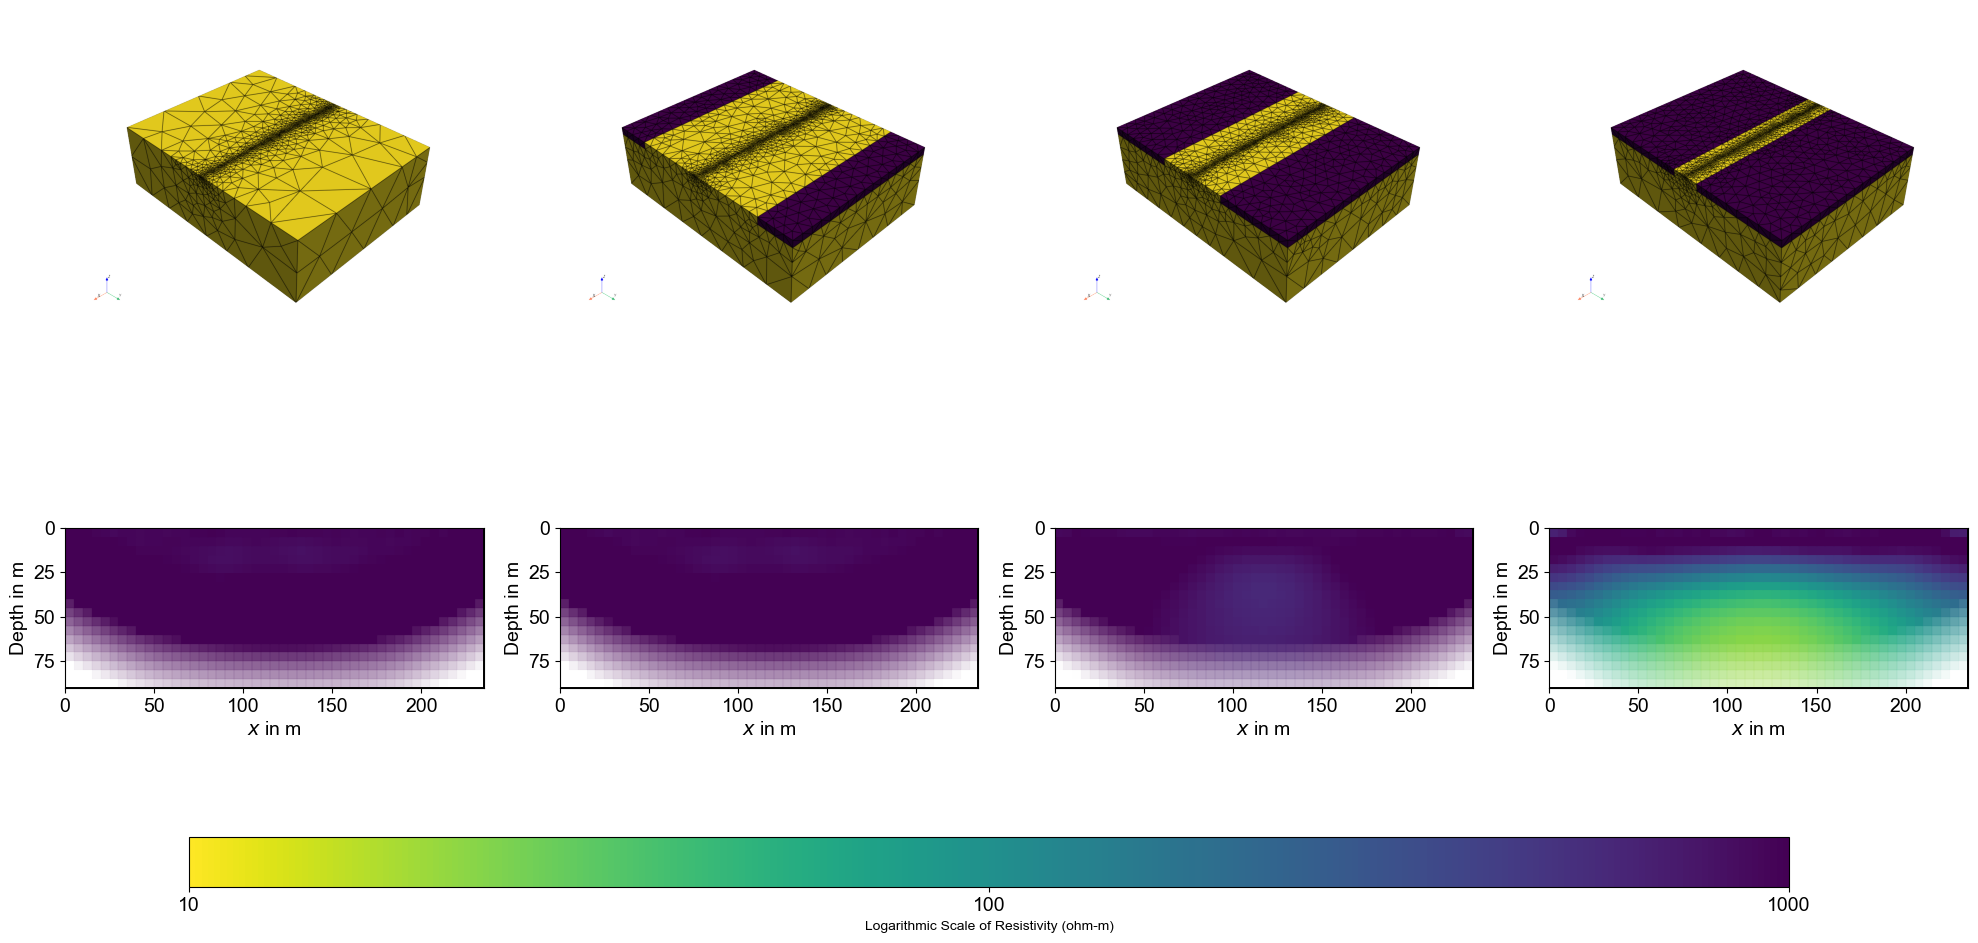

In [118]:
cMin = 10
cMax= 1000

def render_vtk_to_image(filepath):
    # Load the VTK file
    mesh = pyvista.read(filepath)
    
    
    plotter = pyvista.Plotter(off_screen=True)
   
    plotter.add_mesh(mesh, cmap="viridis_r", show_scalar_bar=False, show_edges=True)  # Default color if no scalar data

    plotter.set_background("white")
    plotter.show_axes()  # Optional: Show axes for orientation

    # Render and capture the image
    img = plotter.screenshot(transparent_background=True)
    plotter.close()
    return img

vtk_files = [dir + '3dmod/mesh_hom.vtk', dir + '3dmod/mesh_air_thin.vtk', dir + '3dmod/mesh_air_mid.vtk', dir + '3dmod/mesh_air_wide.vtk']  # Replace with your actual VTK file paths


fig, ax = plt.subplots(2, 4, figsize=(20, 25))


for i, filepath in enumerate(vtk_files):
    img = render_vtk_to_image(filepath)
    ax[0, i].imshow(img)
    ax[0, i].axis('off') 

# Generate 2D plots in the right column
pg.show(mesh_hom, res_hom, logScale=True, cMap="viridis_r", ax=ax[1][0], cMin=cMin, cMax=cMax, colorBar=False, coverage=cov_hom, sharex=True)
pg.show(mesh_thin, res_thin, logScale=True, cMap="viridis_r", ax=ax[1][1], cMin=cMin, cMax=cMax, colorBar=False, coverage=cov_thin, sharex=True)
pg.show(mesh_mid, res_mid, logScale=True, cMap="viridis_r", ax=ax[1][2], cMin=cMin, cMax=cMax, colorBar=False, coverage=cov_mid, sharex=True)
pg.show(mesh_wide, res_wide, logScale=True, cMap="viridis_r", ax=ax[1][3], cMin=cMin, cMax=cMax, colorBar=False, coverage=cov_wide, sharex=True)




cax = fig.add_axes([0.1, 0.3, 0.8, 0.02])  

colorbar = pg.viewer.mpl.createColorBarOnly(ax=cax, cMin=cMin, cMax=cMax, logScale=True, cMap="viridis_r")

cax.xaxis.set_major_locator(LogLocator(base=10.0))
cax.xaxis.set_major_formatter(LogFormatter(labelOnlyBase=False))
cax.set_xlabel('Logarithmic Scale of Resistivity (ohm-m)', fontsize=10)

#ax[0].set_title('Thin')
#ax[1].set_title('Mid')
#ax[2].set_title('Wide')



plt.tight_layout()
plt.show()

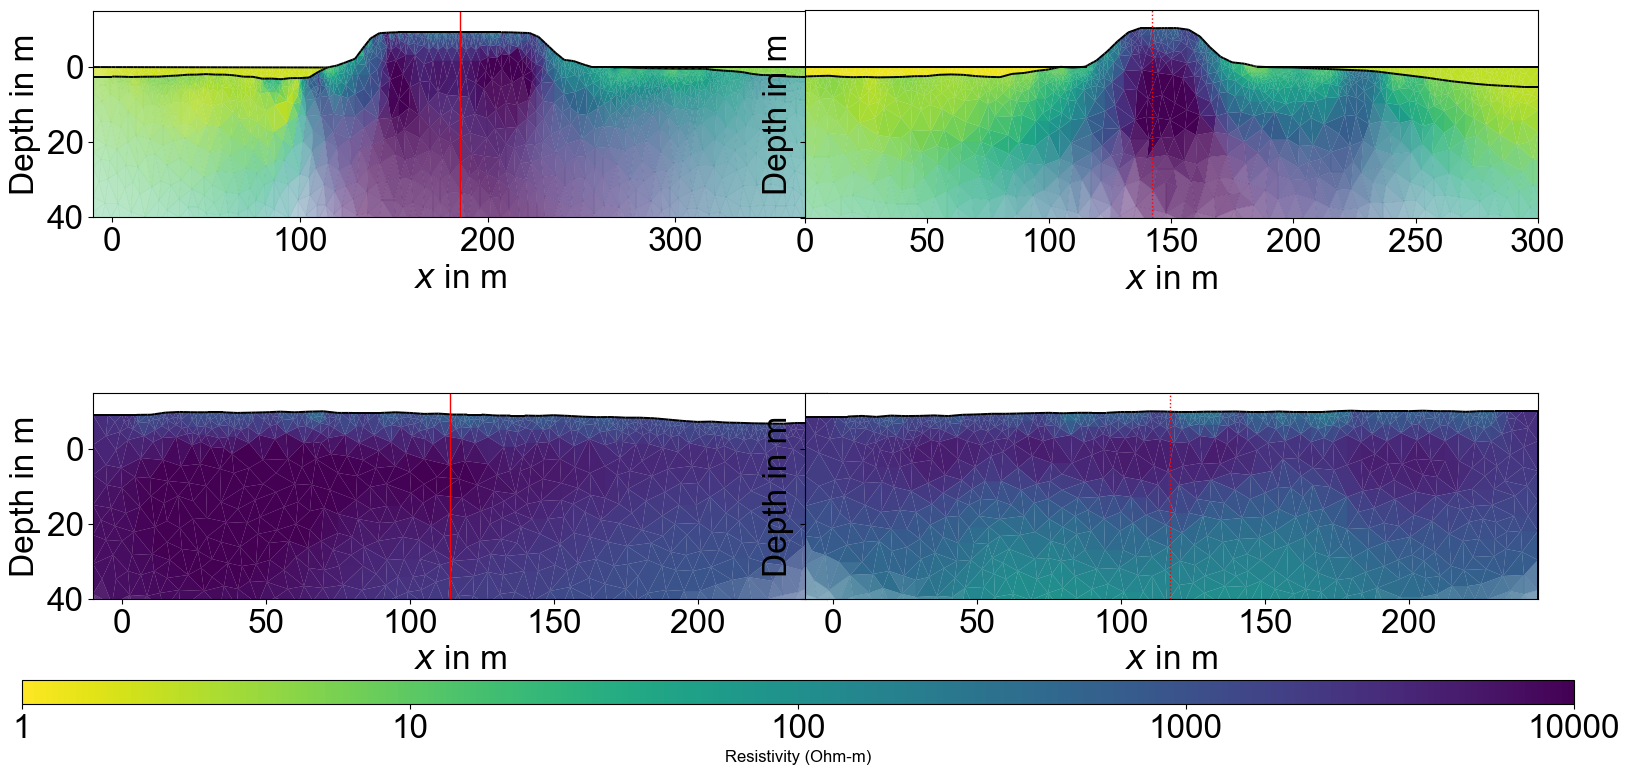

In [25]:
cMin=1
cMax=10000

fig, ax = plt.subplots(2, 2, figsize=(16, 8), sharey=True)

pg.show(mesh_eastern_newrhoa, res_eastern_newrhoa, cMap="viridis_r", ax=ax[0][0], cMin=cMin, cMax=cMax, colorBar=False, logScale=True, coverage=cov_eastern_newrhoa)
pg.show(mesh_western_newrhoa, res_western_newrhoa, cMap="viridis_r", ax=ax[0][1], cMin=cMin, cMax=cMax, colorBar=False, logScale=True, coverage=cov_western_newrhoa)
pg.show(mesh_eastern_perpendicular, res_eastern_perpendicular, cMap="viridis_r", ax=ax[1][0], cMin=cMin, cMax=cMax, colorBar=False, logScale=True, coverage=cov_eastern_perpendicular)
pg.show(mesh_western_perpendicular, res_western_perpendicular, cMap="viridis_r", ax=ax[1][1], cMin=cMin, cMax=cMax, colorBar=False, logScale=True, coverage=cov_western_perpendicular)

cax = fig.add_axes([0.03, 0.05, 0.97, 0.03])  

colorbar = pg.viewer.mpl.createColorBarOnly(ax=cax, logScale=True, cMin=cMin, cMax= cMax, cMap="viridis_r")

cax.xaxis.set_major_locator(LogLocator(base=10.0))
cax.xaxis.set_major_formatter(LogFormatter(labelOnlyBase=False))
cax.set_xlabel('Resistivity (Ohm-m)', fontsize=12)

ax[0][0].set_ylim(-40, 15)
#ax0.set_ylabel("Depth (m)")
ax[0][1].set_ylim(-40, 15)
ax[0][1].set_xlim(0, 300)
ax[1][0].set_ylim(-40, 15)
ax[1][1].set_ylim(-40, 15)
ax[0][0].set_aspect(2)
ax[0][1].set_aspect(1.55)
ax[1][0].set_aspect(1.3)
ax[1][1].set_aspect(1.3)

ax[0][1].axvline(142, color='red', linewidth=1, linestyle=":")
ax[1][1].axvline(117, color='red', linewidth=1, linestyle=":")

ax[0][0].axvline(185, color='red', linewidth=1)
ax[1][0].axvline(114, color='red', linewidth=1)

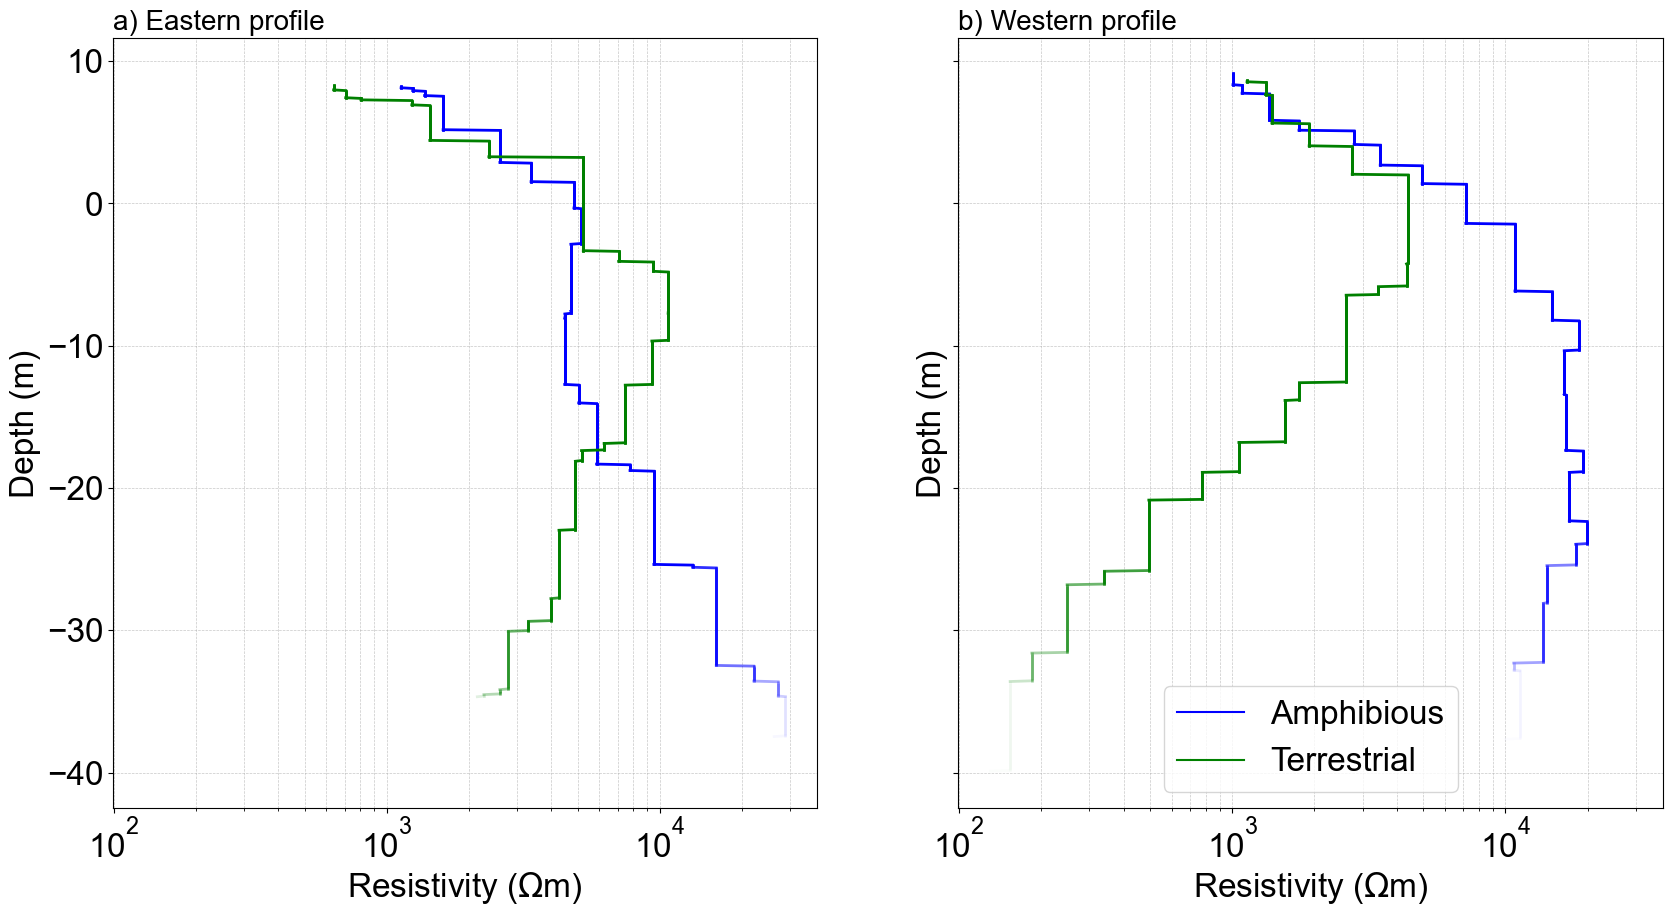

In [ ]:
def get_cross_section(data, x, tolerance):
    result = data[data[:, 0] == data[np.isclose(data[:, 0], x, atol=tolerance)][0, 0]]
    #result = data[np.where(np.isclose(data[:, 0], x, atol=tolerance))[0][0]:] if np.any(np.isclose(data[:, 0], x, atol=tolerance)) else None
    return result

def normalize_coverage(coverage, dropThreshold=0.4):
    """
    Normalize coverage to determine alpha transparency values.
    """
    C = np.asarray(coverage)
    
    if (np.min(C) < 0.) or (np.max(C) > 1.) or (np.max(C) < 0.5):
        nn, hh = np.histogram(C, 50)
        nnn = nn.cumsum(axis=0) / float(len(C))
        
        mi = hh[np.min(np.where(nnn > 0.02)[0])]
        ma = hh[np.max(np.where(nnn < dropThreshold)[0])] if np.min(nnn) <= dropThreshold else np.max(C)
        
        C = (C - mi) / (ma - mi)
        C[C < 0.] = 0.0
        C[C > 0.95] = 1.0
    return C

# Load and normalize data for both eastern and western profiles
east_cross = get_cross_section(out_east, 185, 0.001)
east_coverage = normalize_coverage(east_cross[:, 3])
east_cross_p = get_cross_section(out_east_p, 114, 0.001)
east_p_coverage = normalize_coverage(east_cross_p[:, 3])

west_cross = get_cross_section(out_west, 142, 0.001)
west_coverage = normalize_coverage(west_cross[:, 3])
west_cross_p = get_cross_section(out_west_p, 117, 0.001)
west_p_coverage = normalize_coverage(west_cross_p[:, 3])



plt.rcParams['font.size'] = 24
plt.rcParams['font.family'] = 'Arial'
plt.style.use('seaborn-v0_8-colorblind')
# Plotting
fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharey=True, sharex=True)

# Scatter plots for Resistivity
# East plot
#ax[0].plot(east_cross[:, 2], east_cross[:, 1], color="grey", linewidth=1, alpha=0.3, linestyle='dashed')
#ax[0].plot(east_cross_p[:, 2], east_cross_p[:, 1], color="grey", linewidth=1, alpha=0.3, linestyle='dashed')

for i in range(1, len(east_cross)):
    ax[0].plot(east_cross[i-1:i+1, 2], east_cross[i-1:i+1, 1], alpha=east_coverage[i-1], color="blue", linewidth=2)
    
for i in range(1, len(east_cross_p)):
    ax[0].plot(east_cross_p[i-1:i+1, 2], east_cross_p[i-1:i+1, 1], alpha=east_p_coverage[i-1], color="green", linewidth=2)
    
# West plot
#ax[1].plot(west_cross[:, 2], west_cross[:, 1], color="grey", linewidth=1, alpha=0.5, linestyle='dashed')
#ax[1].plot(west_cross_p[:, 2], west_cross_p[:, 1], color="grey", linewidth=1, alpha=0.5, linestyle='dashed')

for i in range(1, len(west_cross)):
    ax[1].plot(west_cross[i-1:i+1, 2], west_cross[i-1:i+1, 1], alpha=west_coverage[i-1], color="blue", linewidth=2)
for i in range(1, len(west_cross_p)):
    ax[1].plot(west_cross_p[i-1:i+1, 2], west_cross_p[i-1:i+1, 1], alpha=west_p_coverage[i-1], color="green", linewidth=2)

# Add legends
amphibious_line = ax[0].plot([], [], color="blue", label="Amphibious")[0]
terrestrial_line = ax[0].plot([], [], color="green", label="Terrestrial")[0]

# Apply the same for the west subplot
ax[1].plot([], [], color="blue", label="Amphibious")
ax[1].plot([], [], color="green", label="Terrestrial")


# Apply the same x-axis limits to both subplots
#ax[0].set_xlim(global_x_min, global_x_max)
#ax[1].set_xlim(global_x_min, global_x_max)
ax[0].set_title("a) Eastern profile", loc='left', fontsize=20)
ax[1].set_title("b) Western profile", loc='left', fontsize=20)
# Labels and Title
ax[0].set_xlabel("Resistivity ($\Omega$m)")
ax[1].set_xlabel("Resistivity ($\Omega$m)")
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[0].set_ylabel("Depth (m)")
ax[1].set_ylabel("Depth (m)")

# Add grids to the plots
ax[0].grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)
ax[1].grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

# Add legends
ax[1].legend(loc='best')


plt.savefig(dir+'paper/figures/virtual_borehole.png')




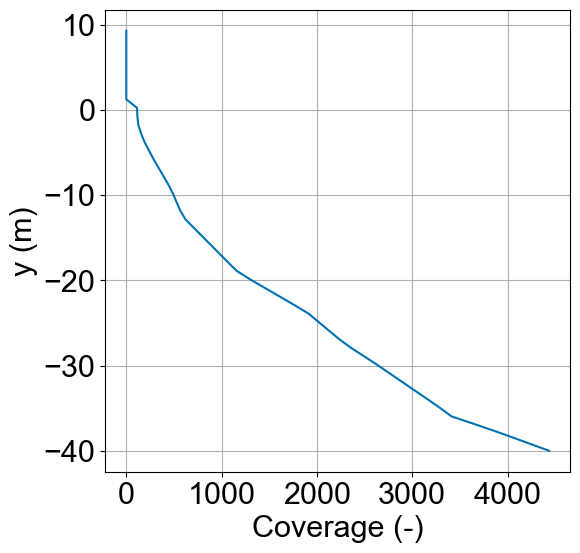

In [42]:
y = np.linspace(mesh_eastern_newrhoa.ymax(), -40)
x = np.ones_like(y)*250

covs = pg.interpolate(srcMesh=mesh_eastern_newrhoa, inVec=res_eastern_newrhoa, x=x, y=y)

fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.plot(covs, y)
#ax.set_xlabel(f"Coverage at x = {x_in}")
ax.set_ylabel("y (m)")
#ax.set_ylim(mesh_eastern_newrhoa.ymin(),0)
ax.set_xlabel("Coverage (-)")
ax.grid(True)

C:\Users\mealiy001\AppData\Local\Temp\ipykernel_13876\1678094053.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax0.set_yticklabels([f"{tick:.1f}" for tick in relative_ticks])
C:\Users\mealiy001\AppData\Local\Temp\ipykernel_13876\1678094053.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([f"{tick:.1f}" for tick in relative_ticks])
C:\Users\mealiy001\AppData\Local\Temp\ipykernel_13876\1678094053.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(h_pad=0.01, w_pad=0.01)


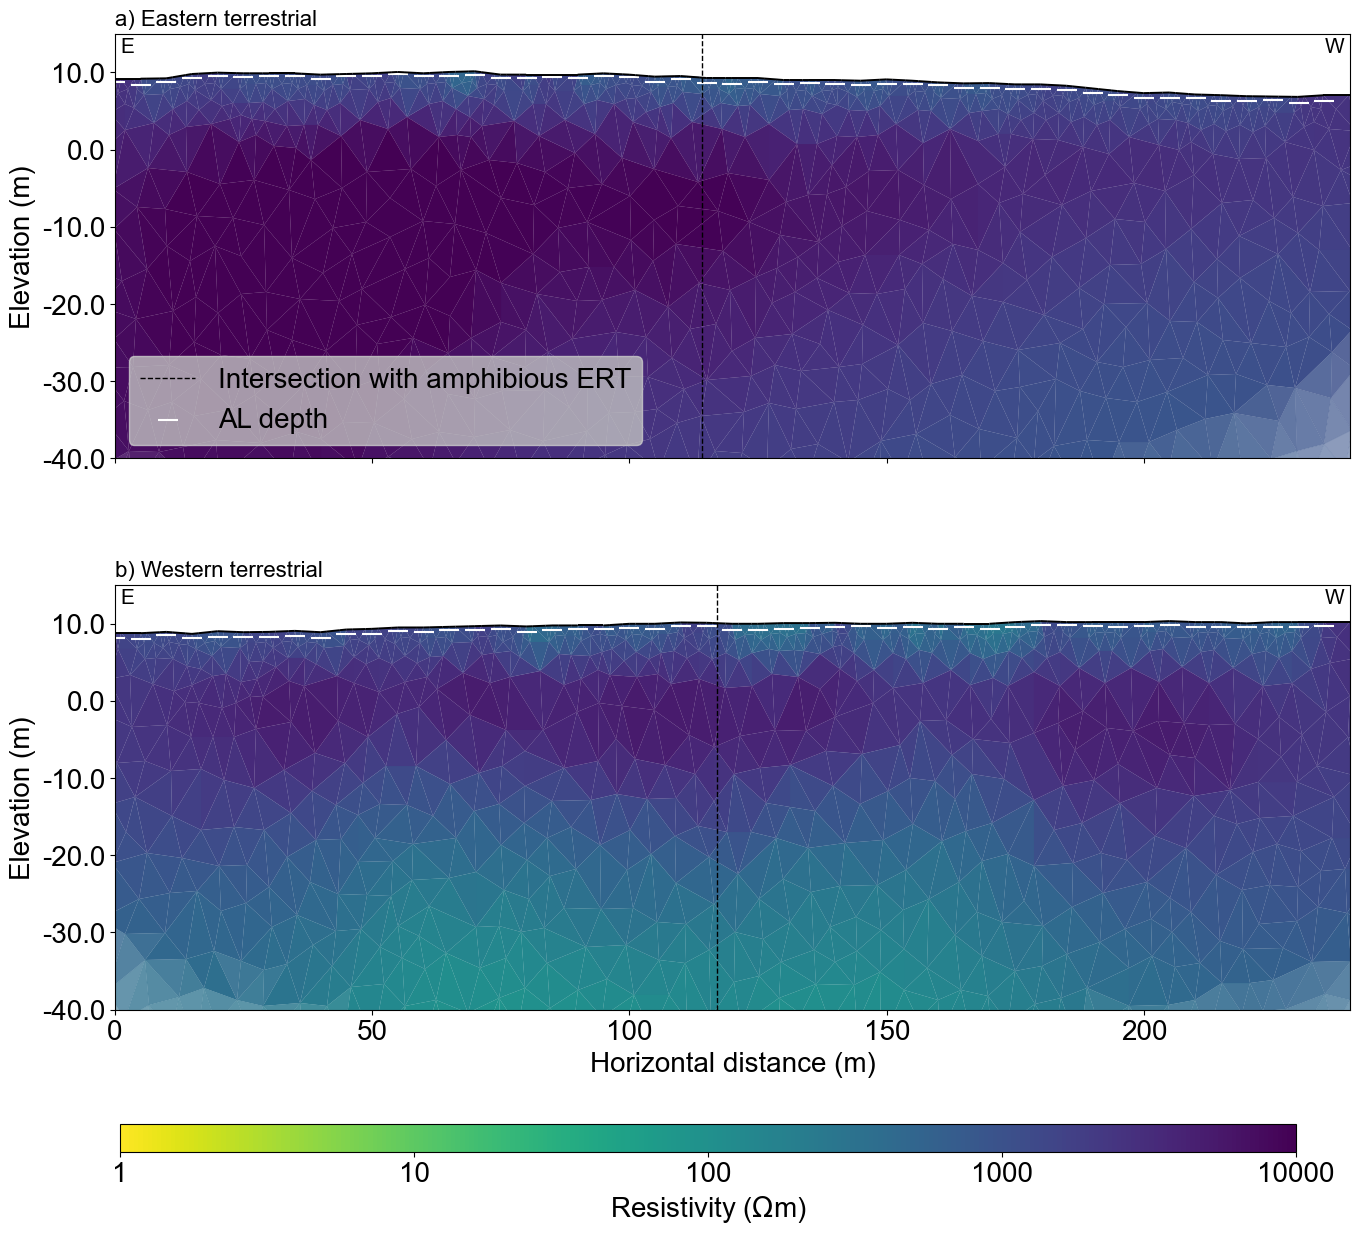

In [28]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import Normalize

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 20


east_p_AL = pd.read_csv(dir+"AL/TOPO_data_eastern_terrestrial.txt", sep='\s+')
west_p_AL = pd.read_csv(dir+"AL/TOPO_data_western_terrestrial.txt", sep='\s+')



fig, ax = plt.subplots(2, 1, figsize=(14, 14), sharey=True, sharex=True)
ax0 = ax[0]
ax2 = ax[1]

pg.show(mesh_eastern_perpendicular, res_eastern_perpendicular,sharey=True, logScale=True, cMap="viridis_r", ax=ax0, cMin=cMin, cMax=cMax, colorBar=False, coverage=cov_eastern_perpendicular)
pg.show(mesh_western_perpendicular, res_western_perpendicular, sharey=True, logScale=True, cMap="viridis_r", ax=ax2, cMin=cMin, cMax=cMax, colorBar=False, coverage=cov_western_perpendicular)




ax0.set_ylim(-40, 15)
ax0.set_ylabel("Depth (m)")
ax2.set_ylim(-40, 15)
ax2.set_xlim(0, 240)
ax0.set_xlim(0, 240)

ax0.text(1, 12.6, "E", fontsize=15)
ax0.text(235, 12.6, "W", fontsize=15)
ax2.text(1, 12.6, "E", fontsize=15)
ax2.text(235, 12.6, "W", fontsize=15)
ax0.set_title('a) Eastern terrestrial', loc='left', fontsize=16)
ax2.set_title('b) Western terrestrial', loc='left', fontsize=16)
ax2.set_ylabel("Depth (m)")



ax0.set_aspect(1.5)
ax2.set_aspect(1.5)

ax2.axvline(117, color='black', linestyle="--", linewidth=1)
ax0.axvline(114, color='black', linestyle="--", linewidth=1, label="Intersection with amphibious ERT")

ax0.scatter(east_p_AL['Distance'], east_p_AL['Elev'] - east_p_AL['AL'], color='white', marker="_", s=200, label="AL depth")
ax2.scatter(west_p_AL['Distance'], west_p_AL['Elev'] - west_p_AL['AL'], color='white', marker="_", s=200)

current_ticks = ax[0].get_yticks()
relative_ticks = current_ticks   # Assuming 17 is the minimum elevation

# Set the new tick labels to show relative elevation

ax0.set_yticklabels([f"{tick:.1f}" for tick in relative_ticks])
ax0.set_ylabel("Elevation (m)")
ax2.set_yticklabels([f"{tick:.1f}" for tick in relative_ticks])
ax2.set_ylabel("Elevation (m)")
ax0.set_xlabel("")
ax2.set_xlabel("Horizontal distance (m)")

cax = fig.add_axes([0.1, 0.05, 0.84, 0.02])  

colorbar = pg.viewer.mpl.createColorBarOnly(ax=cax, logScale=True, cMin=cMin, cMax= cMax, cMap="viridis_r")

cax.xaxis.set_major_locator(LogLocator(base=10.0))
cax.xaxis.set_major_formatter(LogFormatter(labelOnlyBase=False))
cax.set_xlabel('Resistivity ($\Omega$m)')

ax0.legend(loc="best", facecolor='silver')
plt.tight_layout(h_pad=0.01, w_pad=0.01)
plt.savefig(dir+'paper/figures/terrestrial.png', bbox_inches='tight')



In [29]:
east_shoreline_plots = np.loadtxt(dir+'processing/shoreline/east_shoreline_plots.csv', delimiter=',', skiprows=1)
west_shoreline_plots = np.loadtxt(dir+'processing/shoreline/west_shoreline_plots.csv', delimiter=',', skiprows=1)

In [30]:

with open(dir+'processing/shoreline/joined_east.pkl', 'rb') as f:
    joined_east = pickle.load(f)

eastshore = joined_east[['year', 'xc', 'zc']].to_numpy()

eastshore[:, 1] = eastshore[:, 1].round(decimals=0)  # Round 'xc'
eastshore[:, 2] = eastshore[:, 2].round(decimals=1)  # Round 'zc'

posVec = [pg.Pos(pos) for pos in zip(eastshore[:, 1], eastshore[:, 2])]

mesh_eastern_newrhoa.setCellMarkers(pg.IVector(mesh_eastern_newrhoa.cellCount()))

fopDP = PriorModelling(mesh_eastern_newrhoa, posVec)

resMesh_east = fopDP(res_eastern_newrhoa)
covMesh_east = fopDP(cov_eastern_newrhoa)
# Create a mesh and set cell markers
#np.savetxt(dir+"out.txt", np.column_stack((grid_points[:, 0], grid_points[:, 1], resMesh)))
east_shoreline_plots = np.column_stack((eastshore[:, 1], eastshore[:, 2], resMesh_east, eastshore[:, 0], covMesh_east))
east_shoreline_plots = np.c_[ east_shoreline_plots, 2023 - east_shoreline_plots[:, 3] ]



23/02/25 - 17:50:39 - pyGIMLi - INFO - Found 1 regions.


In [31]:
with open(dir+'processing/shoreline/joined_west.pkl', 'rb') as f:
    joined_west = pickle.load(f)

westshore = joined_west[['year', 'xc', 'zc']].to_numpy()

westshore[:, 1] = westshore[:, 1].round(decimals=0)  # Round 'xc'
westshore[:, 2] = westshore[:, 2].round(decimals=1)  # Round 'zc'

posVec = [pg.Pos(pos) for pos in zip(westshore[:, 1], westshore[:, 2])]

mesh_western_newrhoa.setCellMarkers(pg.IVector(mesh_western_newrhoa.cellCount()))

fopDP = PriorModelling(mesh_western_newrhoa, posVec)

resMesh_west = fopDP(res_western_newrhoa)
covMesh_west = fopDP(cov_western_newrhoa)
# Create a mesh and set cell markers
#np.savetxt(dir+"out.txt", np.column_stack((grid_points[:, 0], grid_points[:, 1], resMesh)))
west_shoreline_plots = np.column_stack((westshore[:, 1], westshore[:, 2], resMesh_west, westshore[:, 0], covMesh_west))
west_shoreline_plots = np.c_[ west_shoreline_plots, 2023 - west_shoreline_plots[:, 3] ]

23/02/25 - 17:50:43 - pyGIMLi - INFO - Found 1 regions.


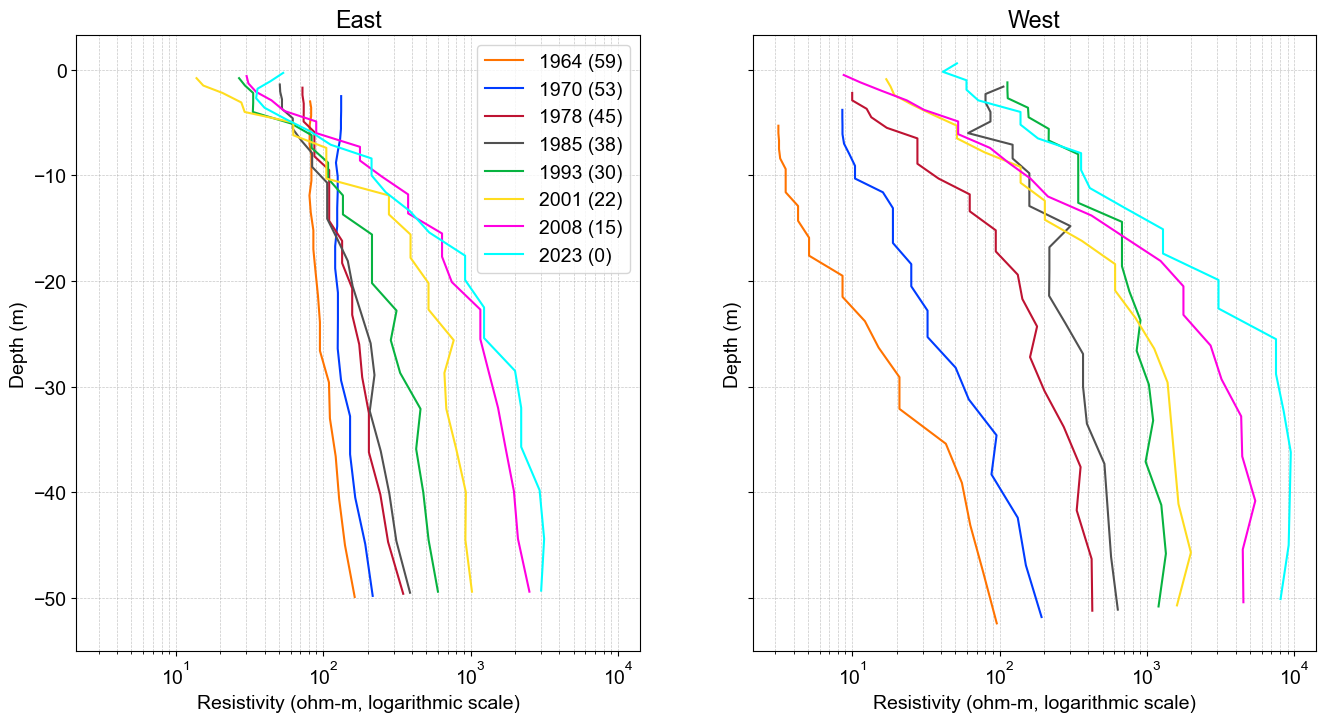

In [112]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

years = np.unique(west_shoreline_plots[:, 3])
years_east = np.unique(east_shoreline_plots[:, 3])
years_west = np.unique(west_shoreline_plots[:, 3])
east_coverage_all = normalize_coverage(east_shoreline_plots[:, 4])
west_coverage_all = normalize_coverage(west_shoreline_plots[:, 4])


plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = 'Arial'
colors = ['#ff7300', '#003cff', '#be1332', '#515151', '#07b340', '#ffdd1f', '#ff00e1', 'aqua']  # Blue to green to yellow to red
#colors = colors[::-1]
cmap_name = 'custom_cmap'

# Create the colormap
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=256)
custom_cmap= custom_cmap.reversed()
# Plotting each year's resistivity values with depth


# Define the years and their corresponding colors
year_color_map = {
    year: colors[i % len(colors)]
    for i, year in enumerate(years)
}

fig, ax = plt.subplots(1, 2, figsize=(16, 8), sharey=True, sharex=True)


for year in years_east:
   
    data_year_east = east_shoreline_plots[east_shoreline_plots[:, 3] == year]
    data_year_east = data_year_east[np.argsort(data_year_east[:, 1])]  # Sort by depth
    ax[0].plot(data_year_east[:, 2], data_year_east[:, 1], label=f"{int(year)} ({int(2023 - year)})", color=year_color_map[year])
    

for year in years_west:
   
    data_year_west = west_shoreline_plots[west_shoreline_plots[:, 3] == year]
    data_year_west = data_year_west[np.argsort(data_year_west[:, 1])]  # Sort by depth
    ax[1].plot(data_year_west[:, 2], data_year_west[:, 1], color=year_color_map[year])

ax[0].set_xlabel("Resistivity (ohm-m, logarithmic scale)")
ax[1].set_xlabel("Resistivity (ohm-m, logarithmic scale)")
#ax[0].set_xscale('log')
#ax[1].set_xscale('log')
ax[0].set_ylabel("Depth (m)")
ax[1].set_ylabel("Depth (m)")
ax[0].set_title("East")
ax[1].set_title("West")
# Add grids to the plots
ax[0].grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)
ax[1].grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)
ax[0].set_xscale('log')
ax[1].set_xscale('log')
#ax[0].set_xlim(1, 100000)
#ax[1].set_xlim(1, 100000)

# Add legends
ax[0].legend(loc='best')

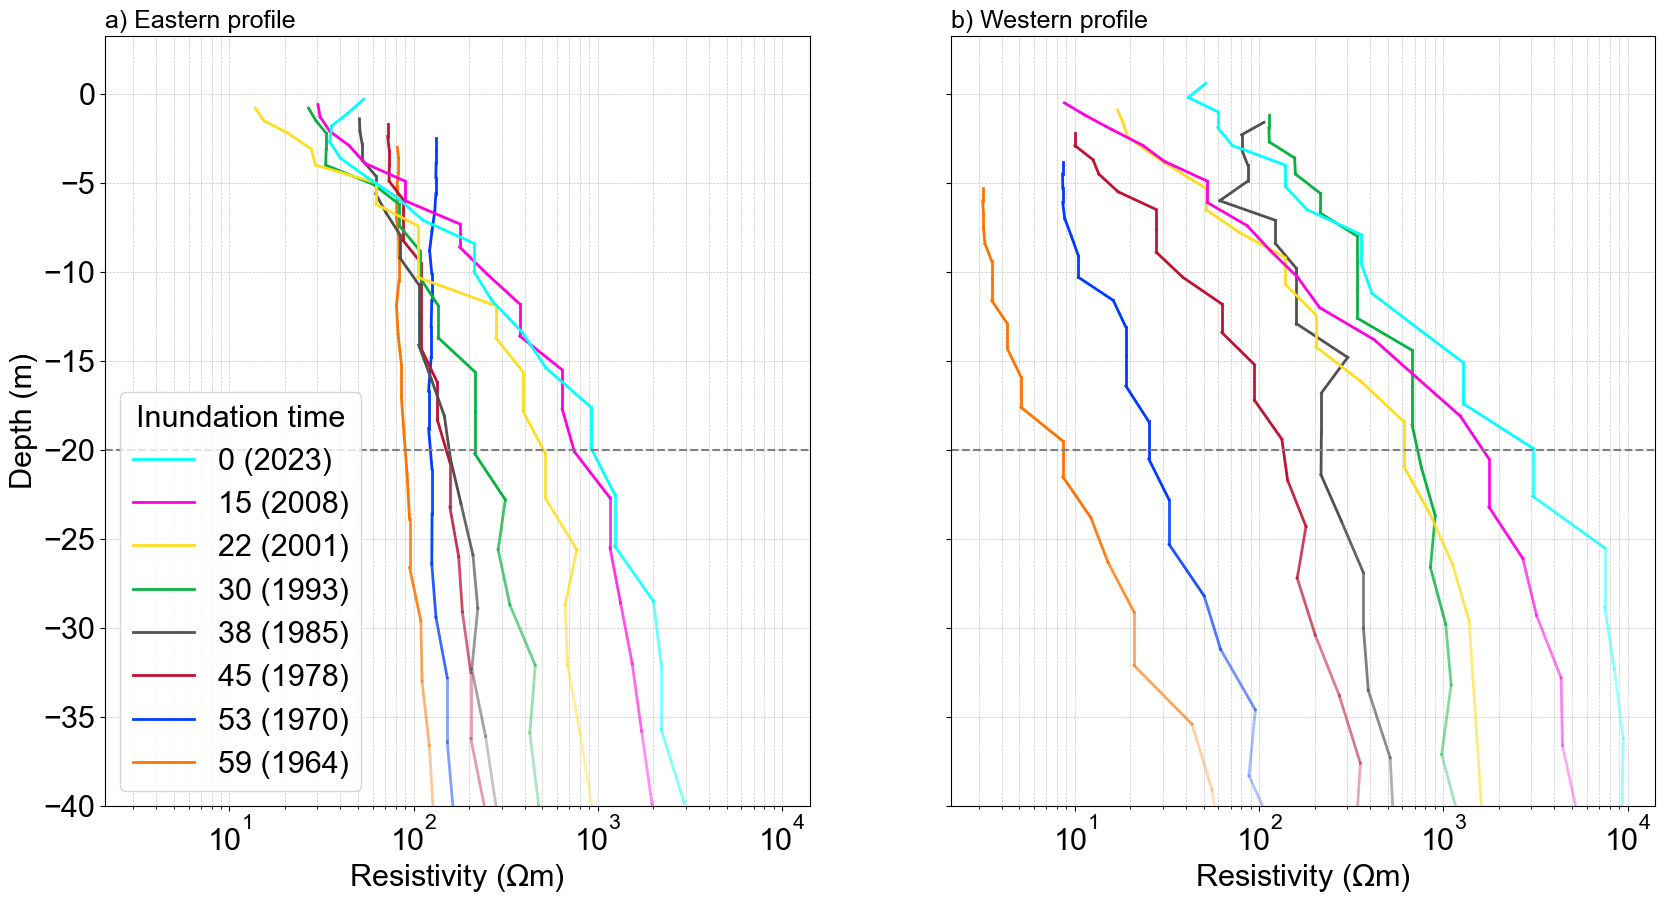

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Assuming normalize_coverage function is available



# Load data (assuming your data loading is correct, so no need to modify that)
years = np.unique(west_shoreline_plots[:, 3])
years_east = np.unique(east_shoreline_plots[:, 3])
years_west = np.unique(west_shoreline_plots[:, 3])

# Set plot style and parameters
plt.rcParams['font.size'] = 22
plt.rcParams['font.family'] = 'Arial'

# Define colors for the years
colors = ['#ff7300', '#003cff', '#be1332', '#515151', '#07b340', '#ffdd1f', '#ff00e1', 'aqua']
cmap_name = 'custom_cmap'

# Create a custom colormap
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=256)
#custom_cmap = custom_cmap.reversed()

# Map years to colors
year_color_map = {
    year: colors[i % len(colors)]
    for i, year in enumerate(years)
}

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharey=True, sharex=True)


# Track years added to the legend
east_legend_added = set()
west_legend_added = set()

# Plot east shoreline profiles
for year in years_east:
    data_year_east = east_shoreline_plots[east_shoreline_plots[:, 3] == year]
    #data_year_east = data_year_east[np.argsort(data_year_east[:, 1])]  # Sort by depth
    
    # Normalize the coverage for the entire year
    coverage_for_year = normalize_coverage(data_year_east[:, 4])  # Coverage data for this year
    
    # Plot each segment with the corresponding alpha for the segment
    for i in range(1, len(data_year_east)):
        label = f"{int(2023 - year)} ({int(year)})" if year not in east_legend_added else None
        ax[0].plot(data_year_east[i-1:i+1, 2], data_year_east[i-1:i+1, 1], 
                   alpha=coverage_for_year[i-1], color=year_color_map[year], linewidth=2, linestyle="solid", label=label)
        east_legend_added.add(year)
# Plot west shoreline profiles
for year in years_west:
    data_year_west = west_shoreline_plots[west_shoreline_plots[:, 3] == year]
    #data_year_west = data_year_west[np.argsort(data_year_west[:, 1])]  # Sort by depth
    
    # Normalize the coverage for each profile segment
    coverage_for_year = normalize_coverage(data_year_west[:, 4])  # Coverage data for this year
    
    # Plot each line segment with corresponding alpha (from coverage)
    for i in range(1, len(data_year_west)):
        ax[1].plot(data_year_west[i-1:i+1, 2], data_year_west[i-1:i+1, 1], 
                   alpha=coverage_for_year[i-1], color=year_color_map[year], linewidth=2, linestyle="-")


#ax[0].axhline(-10, linestyle="--", color='grey')
#ax[0].axhline(-15, linestyle="--", color='grey')
ax[0].axhline(-20, linestyle="--", color='grey')
#ax[1].axhline(-10, linestyle="--", color='grey')
#ax[1].axhline(-15, linestyle="--", color='grey')
ax[1].axhline(-20, linestyle="--", color='grey')
# Set plot labels and titles
ax[0].set_xlabel("Resistivity ($\Omega$m)")
ax[1].set_xlabel("Resistivity ($\Omega$m)")
ax[0].set_ylabel("Depth (m)")
#ax[1].set_ylabel("Depth (m)")
ax[0].set_title("a) Eastern profile", loc='left', fontsize=18)
ax[1].set_title("b) Western profile", loc='left', fontsize=18)
ax[0].set_ylim(-40)
ax[1].set_ylim(-40)
ax[0].set_xscale('log')
ax[1].set_xscale('log')
# Add grids to the plots
ax[0].grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)
ax[1].grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

handles_east, labels_east = ax[0].get_legend_handles_labels()

ax[0].legend(handles_east[::-1], labels_east[::-1], loc='best', title="Inundation time")
# Add legends


# Save the plot
plt.savefig(dir+'paper/figures/shoreline_plot_with_alpha.png')



In [45]:
east_long = out_east[out_east[:, 0] > 240]
west_long = out_west[out_west[:, 0] > 180]

res_east_long = east_long[:, 2]
depths_east_long = east_long[:, 1]




interp_func_res_east = interp1d(depths_east_long, res_east_long, fill_value='extrapolate') 
res_east_long_at_10m = interp_func_res_east(-10)
res_east_long_at_15m = interp_func_res_east(-15)
res_east_long_at_20m = interp_func_res_east(-20)
res_east_long_at_10m

array(247.24397287)

In [46]:

east_long = out_east[out_east[:, 0] > 240]  

# Extract values
x_east_long = east_long[:, 0]  # Longitude values (X points)
depths_east_long = east_long[:, 1]  # Depth values
res_east_long = east_long[:, 2]  # Resistivity values

# Define depth levels for interpolation
depth_values = np.array([-10, -15, -20])

# Get unique x-values (sorted)
unique_x_values = np.unique(x_east_long)

# Initialize storage for results
res_east_long_at_depths = np.zeros((len(unique_x_values), len(depth_values)))

# Loop through each unique longitude and interpolate
for i, x_val in enumerate(unique_x_values):
    # Select data for the current longitude
    mask = x_east_long == x_val
    depths_subset = depths_east_long[mask]
    res_subset = res_east_long[mask]
    
    # Create interpolation function
    interp_func = interp1d(depths_subset, res_subset, fill_value='extrapolate')

    # Interpolate for all target depths
    res_east_long_at_depths[i, :] = interp_func(depth_values)

# Create DataFrame with unique x-values and interpolated resistivities
df_resistivity = pd.DataFrame({
    "Res": unique_x_values,
    "-10m": res_east_long_at_depths[:, 0],
    "-15m": res_east_long_at_depths[:, 1],
    "-20m": res_east_long_at_depths[:, 2]
})

# Display final DataFrame
print(df_resistivity)


         Res        -10m         -15m         -20m
0     240.00  741.447885  1122.914178  1724.556123
1     240.05  741.447885  1122.914178  1724.556123
2     240.10  741.447885  1122.914178  1724.556123
3     240.15  741.447885  1122.914178  1724.556123
4     240.20  741.447885  1122.914178  1724.556123
...      ...         ...          ...          ...
2796  379.80   74.049614    77.789441    90.611048
2797  379.85   74.049614    77.789441    90.611048
2798  379.90   74.049614    77.789441    90.611048
2799  379.95   74.049614    77.789441    90.611048
2800  380.00   74.049614    77.789441    90.611048

[2801 rows x 4 columns]


In [48]:
results_east = []

for year in years_east:
    
    data_year_east = east_shoreline_plots[east_shoreline_plots[:, 3] == year]

    if len(data_year_east) > 0:
        
        data_year_east = data_year_east[np.argsort(data_year_east[:, 1])]
        
        
        depths_east = data_year_east[:, 1]
        res_east = data_year_east[:, 2]
        #sat30_east = data_year_east[:, 5]*0.3
        #sat40_east = data_year_east[:, 6]*0.4
        #sat50_east = data_year_east[:, 7]*0.5

       
        interp_func_res_east = interp1d(depths_east, res_east, fill_value='extrapolate') 
        #interp_func_sat30_east = interp1d(depths_east, sat30_east,  fill_value='extrapolate')
        #interp_func_sat40_east = interp1d(depths_east, sat40_east, fill_value='extrapolate')
        #interp_func_sat50_east = interp1d(depths_east, sat50_east, fill_value='extrapolate')

        
        #sat30_east_at_20m = interp_func_sat30_east(-20)
        #sat40_east_at_20m = interp_func_sat40_east(-20)
        #sat50_east_at_20m = interp_func_sat50_east(-20)
        res_east_at_10m = interp_func_res_east(-10)
        res_east_at_15m = interp_func_res_east(-15)
        res_east_at_20m = interp_func_res_east(-20)
        
        results_east.append({'Year': 2023-year, 'res_at_10m': res_east_at_10m, 'res_at_15m': res_east_at_15m, 'res_at_20m': res_east_at_20m})


results_east_df = pd.DataFrame(results_east)
results_east_df

Year          res_at_10m          res_at_15m          res_at_20m
0  59.0    83.1533887295915   85.32051041589119   90.01579929812685
1  53.0   125.1129684036712  124.00303804389699  123.28262857603879
2  45.0  109.76398849786635  118.82232005853247   150.5786084543684
3  38.0   95.98555759230477  114.91257557211777  155.99349101963713
4  30.0  107.89877380665561   189.5461484917411  214.22110436285212
5  22.0   104.9725643349544   355.8642263555101   507.5572008029949
6  15.0   244.1602762345635   570.8794635619523   741.4866292706273
7   0.0  212.79583479079733   496.5192265183781   929.9302293601415

In [49]:
results_west = []

for year in years_west:
    
    data_year_west = west_shoreline_plots[west_shoreline_plots[:, 3] == year]

    if len(data_year_west) > 0:
        
        data_year_west = data_year_west[np.argsort(data_year_west[:, 1])]
        
        
        depths_west = data_year_west[:, 1]
        res_west = data_year_west[:, 2]
        #sat30_east = data_year_east[:, 5]*0.3
        #sat40_east = data_year_east[:, 6]*0.4
        #sat50_east = data_year_east[:, 7]*0.5

       
        interp_func_res_west = interp1d(depths_west, res_west, fill_value='extrapolate') 
        #interp_func_sat30_east = interp1d(depths_east, sat30_east,  fill_value='extrapolate')
        #interp_func_sat40_east = interp1d(depths_east, sat40_east, fill_value='extrapolate')
        #interp_func_sat50_east = interp1d(depths_east, sat50_east, fill_value='extrapolate')

        
        #sat30_east_at_20m = interp_func_sat30_east(-20)
        #sat40_east_at_20m = interp_func_sat40_east(-20)
        #sat50_east_at_20m = interp_func_sat50_east(-20)
        res_west_at_10m = interp_func_res_west(-10)
        res_west_at_15m = interp_func_res_west(-15)
        res_west_at_20m = interp_func_res_west(-20)
        
        results_west.append({'Year': 2023-year, 'res_at_10m': res_west_at_10m, 'res_at_15m': res_west_at_15m, 'res_at_20m': res_west_at_20m})


results_west_df = pd.DataFrame(results_west)


In [50]:
rho_at10_values = results_east_df['res_at_10m'].tolist() 
rho_at10_values = rho_at10_values[::-1] 

rho_at15_values = results_east_df['res_at_15m'].tolist() 
rho_at15_values = rho_at15_values[::-1] 

rho_at20_values = results_east_df['res_at_20m'].tolist() 
rho_at20_values = rho_at20_values[::-1] 

rho_east = pd.DataFrame({'time': [0, 15, 22, 30, 38, 45, 53, 59], 'Rho_at_10m': rho_at10_values, 'Rho_at_15m': rho_at15_values, 'Rho_at_20m': rho_at20_values})
rho_east

time          Rho_at_10m          Rho_at_15m          Rho_at_20m
0     0  212.79583479079733   496.5192265183781   929.9302293601415
1    15   244.1602762345635   570.8794635619523   741.4866292706273
2    22   104.9725643349544   355.8642263555101   507.5572008029949
3    30  107.89877380665561   189.5461484917411  214.22110436285212
4    38   95.98555759230477  114.91257557211777  155.99349101963713
5    45  109.76398849786635  118.82232005853247   150.5786084543684
6    53   125.1129684036712  124.00303804389699  123.28262857603879
7    59    83.1533887295915   85.32051041589119   90.01579929812685

In [51]:

rho_at10_values = results_west_df['res_at_10m'].tolist() 
rho_at10_values = rho_at10_values[::-1] 

rho_at15_values = results_west_df['res_at_15m'].tolist() 
rho_at15_values = rho_at15_values[::-1] 

rho_at20_values = results_west_df['res_at_20m'].tolist() 
rho_at20_values = rho_at20_values[::-1] 

rho_west = pd.DataFrame({'time': [0, 15, 22, 30, 38, 45, 53, 59], 'Rho_at_10m': rho_at10_values, 'Rho_at_15m': rho_at15_values, 'Rho_at_20m': rho_at20_values})
rho_west

time          Rho_at_10m          Rho_at_15m          Rho_at_20m
0     0  372.73585558427675  1256.2393590587478  3058.1739178345865
1    15  152.51785754336458   586.2743989893759  1657.5450506839877
2    22  138.88933743378672     266.40143206529   608.1097157159346
3    30  341.64906680043254   676.7661560982901   725.5661026561573
4    38  159.21232550850402   294.1018081133581   217.3262989400181
5    45    36.2107306213671   90.73216179319026  135.45999713529216
6    53  10.447893223019115   18.89262780781788  25.161848429794386
7    59  3.5358453328796844   4.643718107220103   8.595296475257303

In [52]:
sat30_cryogrid_sal02381 = pd.read_csv(dir+'cryogrid/sat_silt_por30_sal02831.csv')
sat40_cryogrid_sal02381 = pd.read_csv(dir+'cryogrid/sat_silt_por40_sal02831.csv')
sat50_cryogrid_sal02381 = pd.read_csv(dir+'cryogrid/sat_silt_por50_sal02831.csv')
sat60_cryogrid_sal02381 = pd.read_csv(dir+'cryogrid/sat_silt_por60_sal02831.csv')
sat70_cryogrid_sal02381 = pd.read_csv(dir+'cryogrid/sat_silt_por70_sal02831.csv')

rpw30_cryogrid_sal02381 = pd.read_csv(dir+'cryogrid/resistivity_por30_sal02831.csv')
rpw40_cryogrid_sal02381 = pd.read_csv(dir+'cryogrid/resistivity_por40_sal02831.csv')
rpw50_cryogrid_sal02381 = pd.read_csv(dir+'cryogrid/resistivity_por50_sal02831.csv')
rpw60_cryogrid_sal02381 = pd.read_csv(dir+'cryogrid/resistivity_por60_sal02831.csv')
rpw70_cryogrid_sal02381 = pd.read_csv(dir+'cryogrid/resistivity_por70_sal02831.csv')

sat30_cryogrid_sal30 = pd.read_csv(dir+'cryogrid/sat_silt_por30_sal30.csv')
sat40_cryogrid_sal30 = pd.read_csv(dir+'cryogrid/sat_silt_por40_sal30.csv')
sat50_cryogrid_sal30 = pd.read_csv(dir+'cryogrid/sat_silt_por50_sal30.csv')
sat60_cryogrid_sal30 = pd.read_csv(dir+'cryogrid/sat_silt_por60_sal30.csv')
sat70_cryogrid_sal30 = pd.read_csv(dir+'cryogrid/sat_silt_por70_sal30.csv')

rpw30_cryogrid_sal30 = pd.read_csv(dir+'cryogrid/resistivity_por30_sal30.csv')
rpw40_cryogrid_sal30 = pd.read_csv(dir+'cryogrid/resistivity_por40_sal30.csv')
rpw50_cryogrid_sal30 = pd.read_csv(dir+'cryogrid/resistivity_por50_sal30.csv')
rpw60_cryogrid_sal30 = pd.read_csv(dir+'cryogrid/resistivity_por60_sal30.csv')
rpw70_cryogrid_sal30 = pd.read_csv(dir+'cryogrid/resistivity_por70_sal30.csv')

sat30_cryogrid_sal15 = pd.read_csv(dir+'cryogrid/sat_silt_por30_sal15.csv')
sat40_cryogrid_sal15 = pd.read_csv(dir+'cryogrid/sat_silt_por40_sal15.csv')
sat50_cryogrid_sal15 = pd.read_csv(dir+'cryogrid/sat_silt_por50_sal15.csv')
sat60_cryogrid_sal15 = pd.read_csv(dir+'cryogrid/sat_silt_por60_sal15.csv')
sat70_cryogrid_sal15 = pd.read_csv(dir+'cryogrid/sat_silt_por70_sal15.csv')

rpw30_cryogrid_sal15 = pd.read_csv(dir+'cryogrid/resistivity_por30_sal15.csv')
rpw40_cryogrid_sal15 = pd.read_csv(dir+'cryogrid/resistivity_por40_sal15.csv')
rpw50_cryogrid_sal15 = pd.read_csv(dir+'cryogrid/resistivity_por50_sal15.csv')
rpw60_cryogrid_sal15 = pd.read_csv(dir+'cryogrid/resistivity_por60_sal15.csv')
rpw70_cryogrid_sal15 = pd.read_csv(dir+'cryogrid/resistivity_por70_sal15.csv')

sat30_cryogrid_sal63 = pd.read_csv(dir+'cryogrid/sat_silt_por30_sal63.csv')
sat40_cryogrid_sal63 = pd.read_csv(dir+'cryogrid/sat_silt_por40_sal63.csv')
sat50_cryogrid_sal63 = pd.read_csv(dir+'cryogrid/sat_silt_por50_sal63.csv')
sat60_cryogrid_sal63 = pd.read_csv(dir+'cryogrid/sat_silt_por60_sal63.csv')
sat70_cryogrid_sal63 = pd.read_csv(dir+'cryogrid/sat_silt_por70_sal63.csv')

rpw30_cryogrid_sal63 = pd.read_csv(dir+'cryogrid/resistivity_por30_sal63.csv')
rpw40_cryogrid_sal63 = pd.read_csv(dir+'cryogrid/resistivity_por40_sal63.csv')
rpw50_cryogrid_sal63 = pd.read_csv(dir+'cryogrid/resistivity_por50_sal63.csv')
rpw60_cryogrid_sal63 = pd.read_csv(dir+'cryogrid/resistivity_por60_sal63.csv')
rpw70_cryogrid_sal63 = pd.read_csv(dir+'cryogrid/resistivity_por70_sal63.csv')

sat30_cryogrid_sal350 = pd.read_csv(dir+'cryogrid/sat_silt_por30_sal350.csv')
sat40_cryogrid_sal350 = pd.read_csv(dir+'cryogrid/sat_silt_por40_sal350.csv')
sat50_cryogrid_sal350 = pd.read_csv(dir+'cryogrid/sat_silt_por50_sal350.csv')
sat60_cryogrid_sal350 = pd.read_csv(dir+'cryogrid/sat_silt_por60_sal350.csv')
sat70_cryogrid_sal350 = pd.read_csv(dir+'cryogrid/sat_silt_por70_sal350.csv')

rpw30_cryogrid_sal350 = pd.read_csv(dir+'cryogrid/resistivity_por30_sal350.csv')
rpw40_cryogrid_sal350 = pd.read_csv(dir+'cryogrid/resistivity_por40_sal350.csv')
rpw50_cryogrid_sal350 = pd.read_csv(dir+'cryogrid/resistivity_por50_sal350.csv')
rpw60_cryogrid_sal350 = pd.read_csv(dir+'cryogrid/resistivity_por60_sal350.csv')
rpw70_cryogrid_sal350 = pd.read_csv(dir+'cryogrid/resistivity_por70_sal350.csv')

#temperature_at_depth_20 = temp_cryogrid.iloc[depth_20_index, 1:]  
#temperature_at_depth_20_x_points = temperature_at_depth_20[time_steps.isin([15, 22, 30, 38, 45, 53, 59])]
#sat_at_depth_10_x_points = sat_at_depth_10[time_steps.isin([15, 22, 30, 38, 45, 53, 59])]



In [53]:
def calculate_resistivity_with_saturation(resistivity_fluid, porosity, saturation, m, n=2):
    """
    Calculate the resistivity of a formation using the extended Archie’s law.

    Parameters:
    - resistivity_water (float): The resistivity of the water in the pores (in ohm-meters).
    - porosity (float): The porosity of the rock formation (between 0 and 1).
    - saturation (float): The water saturation of the rock (between 0 and 1).
    - m (float): The cementation exponent (default is 2).
    - n (float): The saturation exponent (default is 2).

    Returns:
    - float: The resistivity of the formation (in ohm-meters).
    """

    
    resistivity_formation = resistivity_fluid * (porosity**-m) * (saturation**-n)
    return resistivity_formation



m_start = 2

all cases of porosity and salinity with m=2

In [54]:
data_info = [
    ('sat30_cryogrid_sal30', 'rpw30_cryogrid_sal30', 0.3),
    ('sat40_cryogrid_sal30', 'rpw40_cryogrid_sal30', 0.4),
    ('sat50_cryogrid_sal30', 'rpw50_cryogrid_sal30', 0.5),
    ('sat60_cryogrid_sal30', 'rpw60_cryogrid_sal30', 0.6),
    ('sat70_cryogrid_sal30', 'rpw70_cryogrid_sal30', 0.7),
    ('sat30_cryogrid_sal15', 'rpw30_cryogrid_sal15', 0.3),
    ('sat40_cryogrid_sal15', 'rpw40_cryogrid_sal15', 0.4),
    ('sat50_cryogrid_sal15', 'rpw50_cryogrid_sal15', 0.5),
    ('sat60_cryogrid_sal15', 'rpw60_cryogrid_sal15', 0.6),
    ('sat70_cryogrid_sal15', 'rpw70_cryogrid_sal15', 0.7),
    ('sat30_cryogrid_sal350', 'rpw30_cryogrid_sal350', 0.3),
    ('sat40_cryogrid_sal350', 'rpw40_cryogrid_sal350', 0.4),
    ('sat50_cryogrid_sal350', 'rpw50_cryogrid_sal350', 0.5),
    ('sat60_cryogrid_sal350', 'rpw60_cryogrid_sal350', 0.6),
    ('sat70_cryogrid_sal350', 'rpw70_cryogrid_sal350', 0.7),
    ('sat30_cryogrid_sal63', 'rpw30_cryogrid_sal63', 0.3),
    ('sat40_cryogrid_sal63', 'rpw40_cryogrid_sal63', 0.4),
    ('sat50_cryogrid_sal63', 'rpw50_cryogrid_sal63', 0.5),
    ('sat60_cryogrid_sal63', 'rpw60_cryogrid_sal63', 0.6),
    ('sat70_cryogrid_sal63', 'rpw70_cryogrid_sal63', 0.7),
    ('sat30_cryogrid_sal02381', 'rpw30_cryogrid_sal02381', 0.3),
    ('sat40_cryogrid_sal02381', 'rpw40_cryogrid_sal02381', 0.4),
    ('sat50_cryogrid_sal02381', 'rpw50_cryogrid_sal02381', 0.5),
    ('sat60_cryogrid_sal02381', 'rpw60_cryogrid_sal02381', 0.6),
    ('sat70_cryogrid_sal02381', 'rpw70_cryogrid_sal02381', 0.7)
]

time_since_inundation = [0, 15, 22, 30, 38, 45, 53, 59]

# Create a dictionary to store the results in separate DataFrames
all_results = {}
all_results_filtered = {}
# Loop through each DataFrame pair and corresponding porosity
for sat_name, rpw_name, porosity in data_info:
    # Load the corresponding DataFrames (assuming they are in your directory)
    sat_df = globals()[sat_name]  # Dynamically get DataFrame by its name
    rpw_df = globals()[rpw_name]  # Dynamically get DataFrame by its name
    
    # Create an empty list to store resistivity results
    resistivity_results = []
    
    # Loop over the rows (depths)
    for i, depth in enumerate(sat_df.iloc[1:, 0]):  # First column contains depth values
        # Extract the saturation and resistivity for the current depth
        saturation_values = sat_df.iloc[i+1, 1:]  # All columns except the first one (saturation values)
        resistivity_values = rpw_df.iloc[i, 1:]  # All columns except the first one (resistivity values)
        
        # List to store resistivity values for this particular depth
        depth_resistivity = []
        
        # Loop through each time step (column) for this depth
        for sat_value, resistivity_value in zip(saturation_values, resistivity_values):
            # Apply the function to calculate resistivity for each time step
            resistivity_formation = calculate_resistivity_with_saturation(resistivity_value, porosity, sat_value, m_start)
            depth_resistivity.append(resistivity_formation)
        
        # Append the results for this depth to the main list
        resistivity_results.append(depth_resistivity)
    
    # Convert the results into a DataFrame for this dataset
    resistivity_df = pd.DataFrame(resistivity_results, columns=sat_df.columns[1:], index=sat_df.iloc[1:, 0])
    resistivity_df_filtered = resistivity_df.iloc[:, time_since_inundation]
    # Store this DataFrame in the results dictionary
    all_results[sat_name] = resistivity_df
    all_results_filtered[sat_name] = resistivity_df_filtered

resistivity_df_30_sal02381_filtered = all_results_filtered['sat30_cryogrid_sal02381']
resistivity_df_40_sal02381_filtered = all_results_filtered['sat40_cryogrid_sal02381']
resistivity_df_50_sal02381_filtered = all_results_filtered['sat50_cryogrid_sal02381']
resistivity_df_60_sal02381_filtered = all_results_filtered['sat60_cryogrid_sal02381']
resistivity_df_70_sal02381_filtered = all_results_filtered['sat70_cryogrid_sal02381']

resistivity_df_30_sal30_filtered = all_results_filtered['sat30_cryogrid_sal30']
resistivity_df_40_sal30_filtered = all_results_filtered['sat40_cryogrid_sal30']
resistivity_df_50_sal30_filtered = all_results_filtered['sat50_cryogrid_sal30']
resistivity_df_60_sal30_filtered = all_results_filtered['sat60_cryogrid_sal30']
resistivity_df_70_sal30_filtered = all_results_filtered['sat70_cryogrid_sal30']

resistivity_df_30_sal15_filtered = all_results_filtered['sat30_cryogrid_sal15']
resistivity_df_40_sal15_filtered = all_results_filtered['sat40_cryogrid_sal15']
resistivity_df_50_sal15_filtered = all_results_filtered['sat50_cryogrid_sal15']
resistivity_df_60_sal15_filtered = all_results_filtered['sat60_cryogrid_sal15']
resistivity_df_70_sal15_filtered = all_results_filtered['sat70_cryogrid_sal15']

resistivity_df_30_sal63_filtered = all_results_filtered['sat30_cryogrid_sal63']
resistivity_df_40_sal63_filtered = all_results_filtered['sat40_cryogrid_sal63']
resistivity_df_50_sal63_filtered = all_results_filtered['sat50_cryogrid_sal63']
resistivity_df_60_sal63_filtered = all_results_filtered['sat60_cryogrid_sal63']
resistivity_df_70_sal63_filtered = all_results_filtered['sat70_cryogrid_sal63']

resistivity_df_30_sal350_filtered = all_results_filtered['sat30_cryogrid_sal350']
resistivity_df_40_sal350_filtered = all_results_filtered['sat40_cryogrid_sal350']
resistivity_df_50_sal350_filtered = all_results_filtered['sat50_cryogrid_sal350']
resistivity_df_60_sal350_filtered = all_results_filtered['sat60_cryogrid_sal350']
resistivity_df_70_sal350_filtered = all_results_filtered['sat70_cryogrid_sal350']

resistivity_df_30_sal02381 = all_results['sat30_cryogrid_sal02381']
resistivity_df_40_sal02381 = all_results['sat40_cryogrid_sal02381']
resistivity_df_50_sal02381 = all_results['sat50_cryogrid_sal02381']
resistivity_df_60_sal02381 = all_results['sat60_cryogrid_sal02381']
resistivity_df_70_sal02381 = all_results['sat70_cryogrid_sal02381']

resistivity_df_30_sal30 = all_results['sat30_cryogrid_sal30']
resistivity_df_40_sal30 = all_results['sat40_cryogrid_sal30']
resistivity_df_50_sal30 = all_results['sat50_cryogrid_sal30']
resistivity_df_60_sal30 = all_results['sat60_cryogrid_sal30']
resistivity_df_70_sal30 = all_results['sat70_cryogrid_sal30']

resistivity_df_30_sal15 = all_results['sat30_cryogrid_sal15']
resistivity_df_40_sal15 = all_results['sat40_cryogrid_sal15']
resistivity_df_50_sal15 = all_results['sat50_cryogrid_sal15']
resistivity_df_60_sal15 = all_results['sat60_cryogrid_sal15']
resistivity_df_70_sal15 = all_results['sat70_cryogrid_sal15']

resistivity_df_30_sal63 = all_results['sat30_cryogrid_sal63']
resistivity_df_40_sal63 = all_results['sat40_cryogrid_sal63']
resistivity_df_50_sal63 = all_results['sat50_cryogrid_sal63']
resistivity_df_60_sal63 = all_results['sat60_cryogrid_sal63']
resistivity_df_70_sal63 = all_results['sat70_cryogrid_sal63']

resistivity_df_30_sal350 = all_results['sat30_cryogrid_sal350']
resistivity_df_40_sal350 = all_results['sat40_cryogrid_sal350']
resistivity_df_50_sal350 = all_results['sat50_cryogrid_sal350']
resistivity_df_60_sal350 = all_results['sat60_cryogrid_sal350']
resistivity_df_70_sal350 = all_results['sat70_cryogrid_sal350']



all cases of porosity and salinity with m=2+s

In [55]:
data_info = [
    ('sat30_cryogrid_sal30', 'rpw30_cryogrid_sal30', 0.3),
    ('sat40_cryogrid_sal30', 'rpw40_cryogrid_sal30', 0.4),
    ('sat50_cryogrid_sal30', 'rpw50_cryogrid_sal30', 0.5),
    ('sat60_cryogrid_sal30', 'rpw60_cryogrid_sal30', 0.6),
    ('sat70_cryogrid_sal30', 'rpw70_cryogrid_sal30', 0.7),
    ('sat30_cryogrid_sal15', 'rpw30_cryogrid_sal15', 0.3),
    ('sat40_cryogrid_sal15', 'rpw40_cryogrid_sal15', 0.4),
    ('sat50_cryogrid_sal15', 'rpw50_cryogrid_sal15', 0.5),
    ('sat60_cryogrid_sal15', 'rpw60_cryogrid_sal15', 0.6),
    ('sat70_cryogrid_sal15', 'rpw70_cryogrid_sal15', 0.7),
    ('sat30_cryogrid_sal350', 'rpw30_cryogrid_sal350', 0.3),
    ('sat40_cryogrid_sal350', 'rpw40_cryogrid_sal350', 0.4),
    ('sat50_cryogrid_sal350', 'rpw50_cryogrid_sal350', 0.5),
    ('sat60_cryogrid_sal350', 'rpw60_cryogrid_sal350', 0.6),
    ('sat70_cryogrid_sal350', 'rpw70_cryogrid_sal350', 0.7),
    ('sat30_cryogrid_sal63', 'rpw30_cryogrid_sal63', 0.3),
    ('sat40_cryogrid_sal63', 'rpw40_cryogrid_sal63', 0.4),
    ('sat50_cryogrid_sal63', 'rpw50_cryogrid_sal63', 0.5),
    ('sat60_cryogrid_sal63', 'rpw60_cryogrid_sal63', 0.6),
    ('sat70_cryogrid_sal63', 'rpw70_cryogrid_sal63', 0.7),
    ('sat30_cryogrid_sal02381', 'rpw30_cryogrid_sal02381', 0.3),
    ('sat40_cryogrid_sal02381', 'rpw40_cryogrid_sal02381', 0.4),
    ('sat50_cryogrid_sal02381', 'rpw50_cryogrid_sal02381', 0.5),
    ('sat60_cryogrid_sal02381', 'rpw60_cryogrid_sal02381', 0.6),
    ('sat70_cryogrid_sal02381', 'rpw70_cryogrid_sal02381', 0.7)

]

time_since_inundation = [0, 15, 22, 30, 38, 45, 53, 59]

# Create a dictionary to store the results in separate DataFrames
all_results = {}
all_results_filtered = {}
# Loop through each DataFrame pair and corresponding porosity
for sat_name, rpw_name, porosity in data_info:
    # Load the corresponding DataFrames (assuming they are in your directory)
    sat_df = globals()[sat_name]  # Dynamically get DataFrame by its name
    rpw_df = globals()[rpw_name]  # Dynamically get DataFrame by its name
    
    # Create an empty list to store resistivity results
    resistivity_results = []
    
    # Loop over the rows (depths)
    for i, depth in enumerate(sat_df.iloc[1:, 0]):  # First column contains depth values
        # Extract the saturation and resistivity for the current depth
        saturation_values = sat_df.iloc[i+1, 1:]  # All columns except the first one (saturation values)
        resistivity_values = rpw_df.iloc[i, 1:]  # All columns except the first one (resistivity values)
        
        # List to store resistivity values for this particular depth
        depth_resistivity = []
        
        # Loop through each time step (column) for this depth
        for sat_value, resistivity_value in zip(saturation_values, resistivity_values):
            m_value = m_start+sat_value
            # Apply the function to calculate resistivity for each time step
            resistivity_formation = calculate_resistivity_with_saturation(resistivity_value, porosity, sat_value, m_value)
            depth_resistivity.append(resistivity_formation)
        
        # Append the results for this depth to the main list
        resistivity_results.append(depth_resistivity)
    
    # Convert the results into a DataFrame for this dataset
    resistivity_df = pd.DataFrame(resistivity_results, columns=sat_df.columns[1:], index=sat_df.iloc[1:, 0])
    resistivity_df_filtered = resistivity_df.iloc[:, time_since_inundation]
    # Store this DataFrame in the results dictionary
    all_results[sat_name] = resistivity_df
    all_results_filtered[sat_name] = resistivity_df_filtered

resistivity_df_30_sal02381_filtered_m = all_results_filtered['sat30_cryogrid_sal02381']
resistivity_df_40_sal02381_filtered_m = all_results_filtered['sat40_cryogrid_sal02381']
resistivity_df_50_sal02381_filtered_m = all_results_filtered['sat50_cryogrid_sal02381']
resistivity_df_60_sal02381_filtered_m = all_results_filtered['sat60_cryogrid_sal02381']
resistivity_df_70_sal02381_filtered_m = all_results_filtered['sat70_cryogrid_sal02381']

resistivity_df_30_sal30_filtered_m = all_results_filtered['sat30_cryogrid_sal30']
resistivity_df_40_sal30_filtered_m = all_results_filtered['sat40_cryogrid_sal30']
resistivity_df_50_sal30_filtered_m = all_results_filtered['sat50_cryogrid_sal30']
resistivity_df_60_sal30_filtered_m = all_results_filtered['sat60_cryogrid_sal30']
resistivity_df_70_sal30_filtered_m = all_results_filtered['sat70_cryogrid_sal30']

resistivity_df_30_sal15_filtered_m = all_results_filtered['sat30_cryogrid_sal15']
resistivity_df_40_sal15_filtered_m = all_results_filtered['sat40_cryogrid_sal15']
resistivity_df_50_sal15_filtered_m = all_results_filtered['sat50_cryogrid_sal15']
resistivity_df_60_sal15_filtered_m = all_results_filtered['sat60_cryogrid_sal15']
resistivity_df_70_sal15_filtered_m = all_results_filtered['sat70_cryogrid_sal15']

resistivity_df_30_sal63_filtered_m = all_results_filtered['sat30_cryogrid_sal63']
resistivity_df_40_sal63_filtered_m = all_results_filtered['sat40_cryogrid_sal63']
resistivity_df_50_sal63_filtered_m = all_results_filtered['sat50_cryogrid_sal63']
resistivity_df_60_sal63_filtered_m = all_results_filtered['sat60_cryogrid_sal63']
resistivity_df_70_sal63_filtered_m = all_results_filtered['sat70_cryogrid_sal63']

resistivity_df_30_sal350_filtered_m = all_results_filtered['sat30_cryogrid_sal350']
resistivity_df_40_sal350_filtered_m = all_results_filtered['sat40_cryogrid_sal350']
resistivity_df_50_sal350_filtered_m = all_results_filtered['sat50_cryogrid_sal350']
resistivity_df_60_sal350_filtered_m = all_results_filtered['sat60_cryogrid_sal350']
resistivity_df_70_sal350_filtered_m = all_results_filtered['sat70_cryogrid_sal350']

resistivity_df_30_sal02381_m = all_results['sat30_cryogrid_sal02381']
resistivity_df_40_sal02381_m = all_results['sat40_cryogrid_sal02381']
resistivity_df_50_sal02381_m = all_results['sat50_cryogrid_sal02381']
resistivity_df_60_sal02381_m = all_results['sat60_cryogrid_sal02381']
resistivity_df_70_sal02381_m = all_results['sat70_cryogrid_sal02381']

resistivity_df_30_sal30_m = all_results['sat30_cryogrid_sal30']
resistivity_df_40_sal30_m = all_results['sat40_cryogrid_sal30']
resistivity_df_50_sal30_m = all_results['sat50_cryogrid_sal30']
resistivity_df_60_sal30_m = all_results['sat60_cryogrid_sal30']
resistivity_df_70_sal30_m = all_results['sat70_cryogrid_sal30']

resistivity_df_30_sal15_m = all_results['sat30_cryogrid_sal15']
resistivity_df_40_sal15_m = all_results['sat40_cryogrid_sal15']
resistivity_df_50_sal15_m = all_results['sat50_cryogrid_sal15']
resistivity_df_60_sal15_m = all_results['sat60_cryogrid_sal15']
resistivity_df_70_sal15_m = all_results['sat70_cryogrid_sal15']

resistivity_df_30_sal63_m = all_results['sat30_cryogrid_sal63']
resistivity_df_40_sal63_m = all_results['sat40_cryogrid_sal63']
resistivity_df_50_sal63_m = all_results['sat50_cryogrid_sal63']
resistivity_df_60_sal63_m = all_results['sat60_cryogrid_sal63']
resistivity_df_70_sal63_m = all_results['sat70_cryogrid_sal63']

resistivity_df_30_sal350_m = all_results['sat30_cryogrid_sal350']
resistivity_df_40_sal350_m = all_results['sat40_cryogrid_sal350']
resistivity_df_50_sal350_m = all_results['sat50_cryogrid_sal350']
resistivity_df_60_sal350_m = all_results['sat60_cryogrid_sal350']
resistivity_df_70_sal350_m = all_results['sat70_cryogrid_sal350']



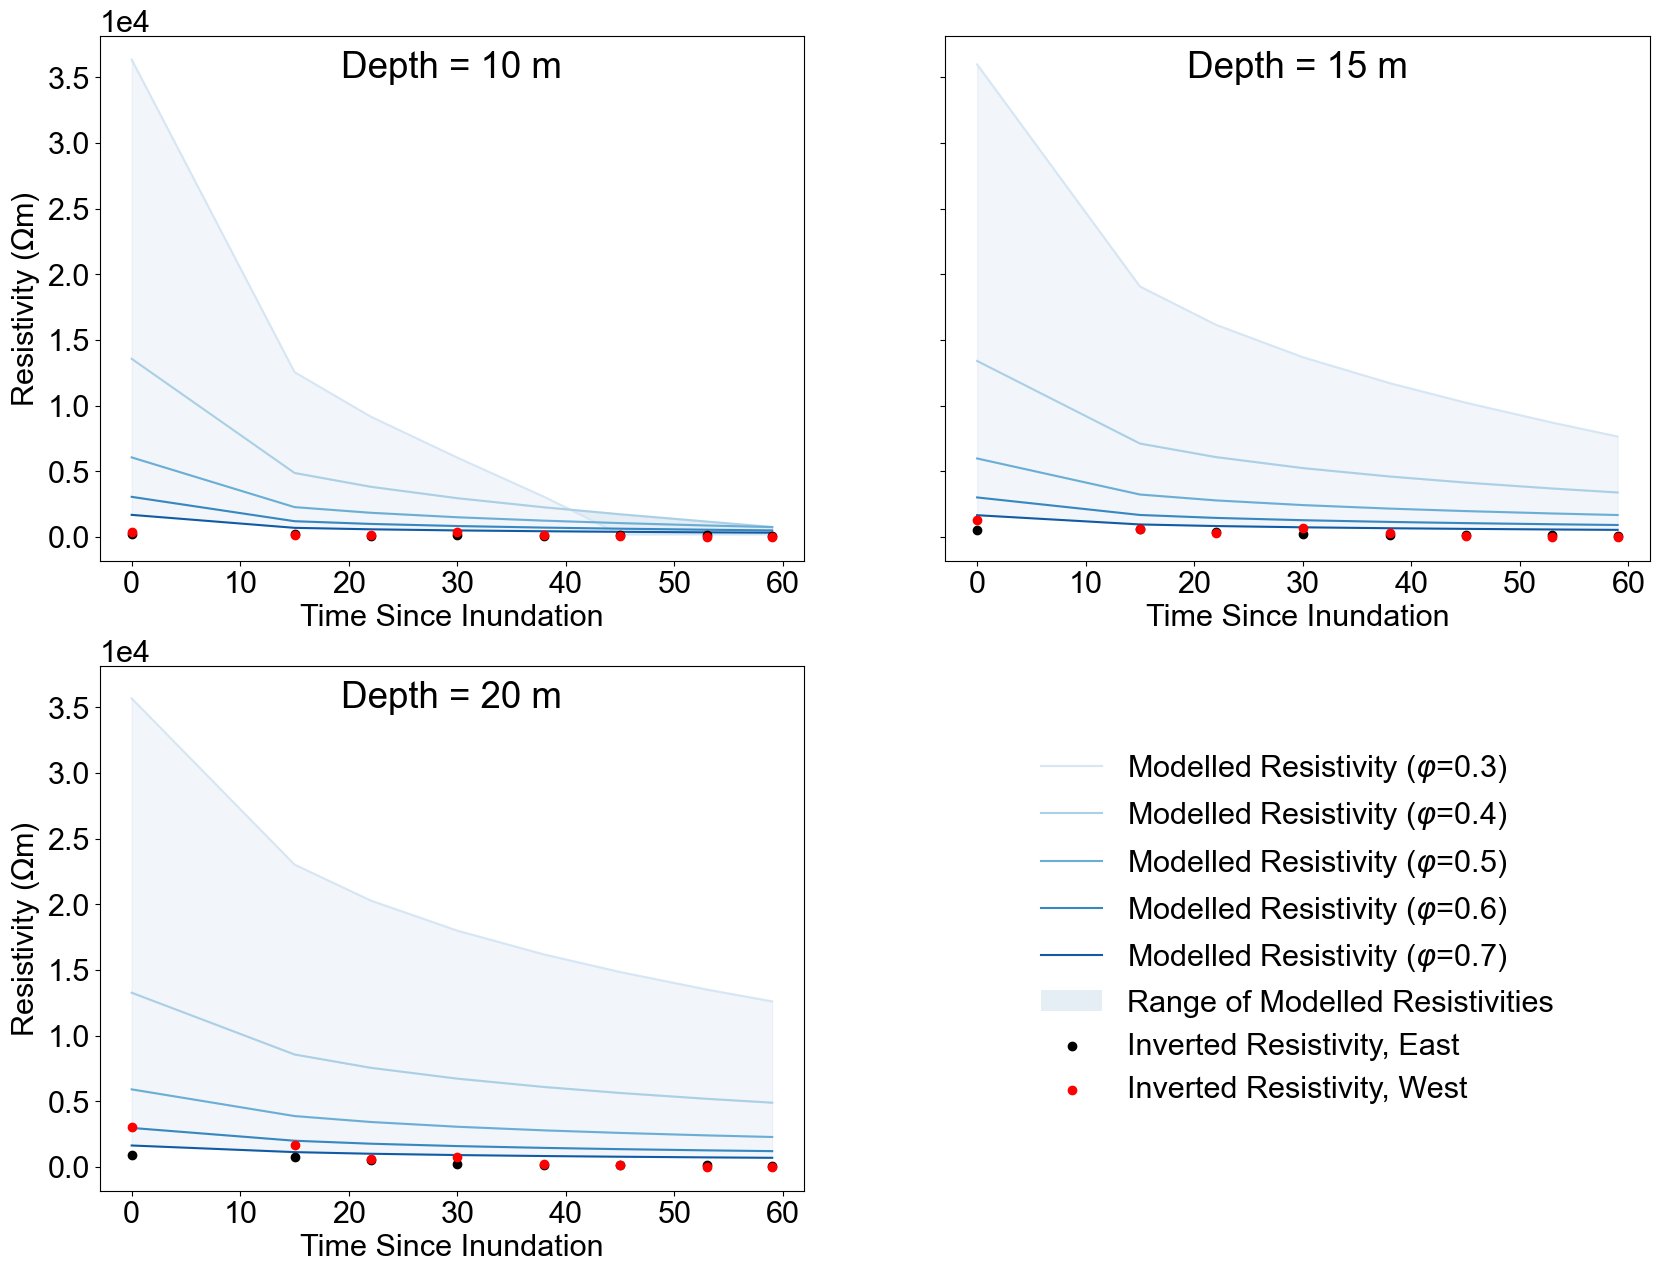

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns  # For a nice colormap

# Define a list of blue shades for each porosity level
blue_shades = sns.color_palette("Blues", 5)  # 5 different shades of blue

# Porosity values corresponding to the datasets
porosities = [0.3, 0.4, 0.5, 0.6, 0.7]

plt.rcParams['font.size'] = 22
plt.rcParams['font.family'] = 'Arial'

# Create a 2x2 subplot grid
fig, ax = plt.subplots(2, 2, figsize=(20, 15), sharey=True)

# Flatten the axes array for easier indexing
ax = ax.ravel()

# Define the resistivity dataframes
resistivity_dfs = [
    resistivity_df_30_sal15_filtered,
    resistivity_df_40_sal15_filtered,
    resistivity_df_50_sal15_filtered,
    resistivity_df_60_sal15_filtered,
    resistivity_df_70_sal15_filtered
]

depth_indices = [0, 1, 2]  # Corresponding to depths 10m, 15m, 20m


# Loop over each depth
for i, depth_idx in enumerate(depth_indices):
    
    # Loop over adjacent porosity datasets to fill only the space between them
    for j in range(len(resistivity_dfs) - 1):  # Stop at the second-to-last porosity level
        df1, df2 = resistivity_dfs[j], resistivity_dfs[j + 1]
        color = blue_shades[j]  # Use the color of the lower porosity line
        
        # Fill between the two adjacent porosity lines
        ax[i].fill_between(time_since_inundation, df1.iloc[depth_idx, :], df2.iloc[depth_idx, :], 
                           color=blue_shades[4], alpha=0.05)  # Adjust transparency

    # Plot all porosity lines on top of the filled areas
    for df, color, porosity in zip(resistivity_dfs, blue_shades, porosities):
        ax[i].plot(time_since_inundation, df.iloc[depth_idx, :], 
                   label=f"Modelled Resistivity ($φ$={porosity})", color=color)

    # Move scatter plots to the end and set a high zorder to keep them on top
    ax[i].scatter(time_since_inundation, rho_east.iloc[:, i+1], 
                  label="Inverted Resistivity, East", color="black", zorder=3)
    ax[i].scatter(time_since_inundation, rho_west.iloc[:, i+1], 
                  label="Inverted Resistivity, West", color="red", zorder=3)
    
   
    # Set labels and titles
    ax[i].set_xlabel("Time Since Inundation")
    ax[i].set_title(f"Depth = {['10 m', '15 m', '20 m'][i]}", y=1.0, pad=-30)
    

ax[0].set_ylabel("Resistivity ($\Omega$m)")
ax[2].set_ylabel("Resistivity ($\Omega$m)")  # Second column doesn' need y-label
ax[0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax[1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax[2].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
# --- Legend subplot (bottom-right) ---
ax[3].axis("off")  # Turn off axis for the legend subplot
handles, labels = ax[0].get_legend_handles_labels()
num_blue_lines = len(porosities)  # Count of modelled resistivity lines
insert_position = num_blue_lines  # Insert right after these lines

# Add a custom patch for the resistivity range AT THE CORRECT POSITION
resistivity_patch = Patch(facecolor=blue_shades[4], edgecolor='none', alpha=0.1, label="Range of Modelled Resistivities")
handles.insert(insert_position, resistivity_patch)
labels.insert(insert_position, "Range of Modelled Resistivities")  # Insert instead of append
ax[3].legend(handles, labels, loc="center", frameon=False)  # Center the legend

# Save the figure
plt.savefig(dir + 'paper/figures/resistivity_with_time.png')


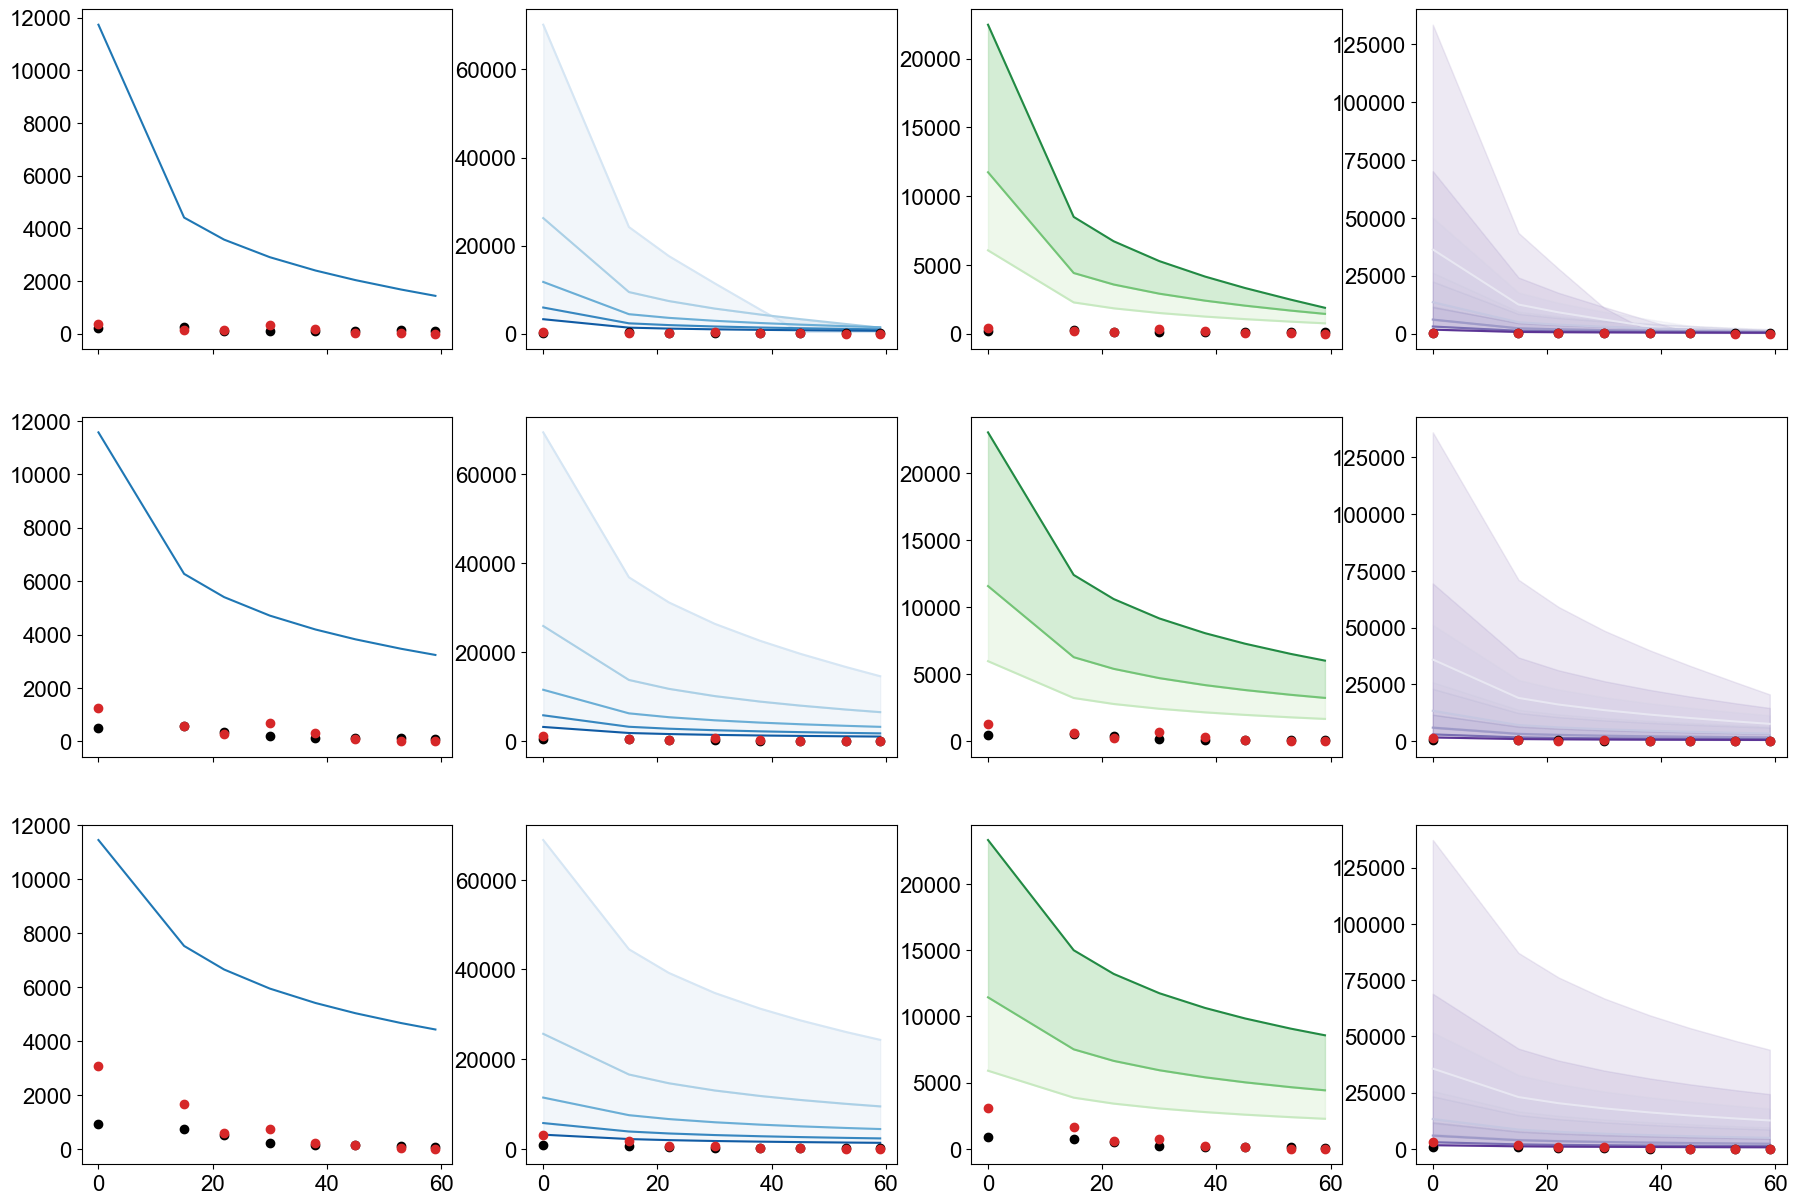

In [57]:
plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = 'Arial'

porosities = [0.3, 0.4, 0.5, 0.6, 0.7]
porewaters = [20, 10, 5]
depth_indices = [0,1,2]

varied_porosities = [
    resistivity_df_30_sal30_filtered,
    resistivity_df_40_sal30_filtered,
    resistivity_df_50_sal30_filtered,
    resistivity_df_60_sal30_filtered,
    resistivity_df_70_sal30_filtered
]

varied_porewater = [
    resistivity_df_50_sal15_filtered,
    resistivity_df_50_sal30_filtered,
    resistivity_df_50_sal63_filtered
]

varied_both = [
    resistivity_df_30_sal15_filtered,
    resistivity_df_40_sal15_filtered,
    resistivity_df_50_sal15_filtered,
    resistivity_df_60_sal15_filtered,
    resistivity_df_70_sal15_filtered,
    resistivity_df_30_sal30_filtered,
    resistivity_df_40_sal30_filtered,
    resistivity_df_50_sal30_filtered,
    resistivity_df_60_sal30_filtered,
    resistivity_df_70_sal30_filtered,
    resistivity_df_30_sal63_filtered,
    resistivity_df_40_sal63_filtered,
    resistivity_df_50_sal63_filtered,
    resistivity_df_60_sal63_filtered,
    resistivity_df_70_sal63_filtered
]


blue_shades = sns.color_palette("Blues", 5)
red_shades = sns.color_palette("Greens", 3)
mixed_shades = sns.color_palette("Purples", len(varied_both)//3)

fig, ax = plt.subplots(3, 4, figsize=(22, 15), sharex=True)

# Loop over each depth
for i, depth_idx in enumerate(depth_indices):
    ax[i,0].plot(time_since_inundation, resistivity_df_50_sal30_filtered.iloc[depth_idx, :], color='tab:blue')
    ax[i,0].scatter(time_since_inundation, rho_east.iloc[:, i+1],label="Inverted Resistivity, East", color="black", zorder=3)
    ax[i,0].scatter(time_since_inundation, rho_west.iloc[:, i+1],label="Inverted Resistivity, West", color="tab:red", zorder=3)
    for j in range(len(varied_porosities) - 1):  
        df1, df2 = varied_porosities[j], varied_porosities[j + 1]
        color = blue_shades[j]  
      
        ax[i,1].fill_between(time_since_inundation, df1.iloc[depth_idx, :], df2.iloc[depth_idx, :], 
                           color=blue_shades[4], alpha=0.05)  

    for df, color, porosity in zip(varied_porosities, blue_shades, porosities):
        ax[i,1].plot(time_since_inundation, df.iloc[depth_idx, :], 
                   label=f"Modelled Resistivity ($φ$={porosity})", color=color)

    ax[i,1].scatter(time_since_inundation, rho_east.iloc[:, i+1], 
                  label="Inverted Resistivity, East", color="black", zorder=3)
    ax[i,1].scatter(time_since_inundation, rho_west.iloc[:, i+1], 
                  label="Inverted Resistivity, West", color="tab:red", zorder=3)
    
    for k in range(len(varied_porewater) - 1):
        df1, df2 = varied_porewater[k], varied_porewater[k + 1]
        color = red_shades[k] 
        
        
        ax[i,2].fill_between(time_since_inundation, df1.iloc[depth_idx, :], df2.iloc[depth_idx, :], 
                           color=color, alpha=0.3)  

   
    for df, color, porewater in zip(varied_porewater, red_shades, porewaters):
        ax[i,2].plot(time_since_inundation, df.iloc[depth_idx, :], 
                   label=f"Modelled Resistivity (Porewater Resistivity={porewater})", color=color)
        
    
    ax[i,2].scatter(time_since_inundation, rho_east.iloc[:, i+1], 
                  label="Inverted Resistivity, East", color="black", zorder=3)
    ax[i,2].scatter(time_since_inundation, rho_west.iloc[:, i+1], 
                  label="Inverted Resistivity, West", color="tab:red", zorder=3)
    
    num_groups = len(varied_both) // len(porewaters)  # Number of porosity levels per porewater
    for k in range(len(varied_both) - 1):
        df1, df2 = varied_both[k], varied_both[k + 1]
        color = mixed_shades[k % num_groups]  # Cycle through shades

        ax[i,3].fill_between(time_since_inundation, df1.iloc[depth_idx, :], df2.iloc[depth_idx, :], 
                             color=color, alpha=0.1)

    for df, color in zip(varied_both, mixed_shades):
        ax[i,3].plot(time_since_inundation, df.iloc[depth_idx, :], color=color)

    ax[i,3].scatter(time_since_inundation, rho_east.iloc[:, i+1], 
                    label="Inverted Resistivity, East", color="black", zorder=3)
    ax[i,3].scatter(time_since_inundation, rho_west.iloc[:, i+1], 
                    label="Inverted Resistivity, West", color="tab:red", zorder=3)

    
    



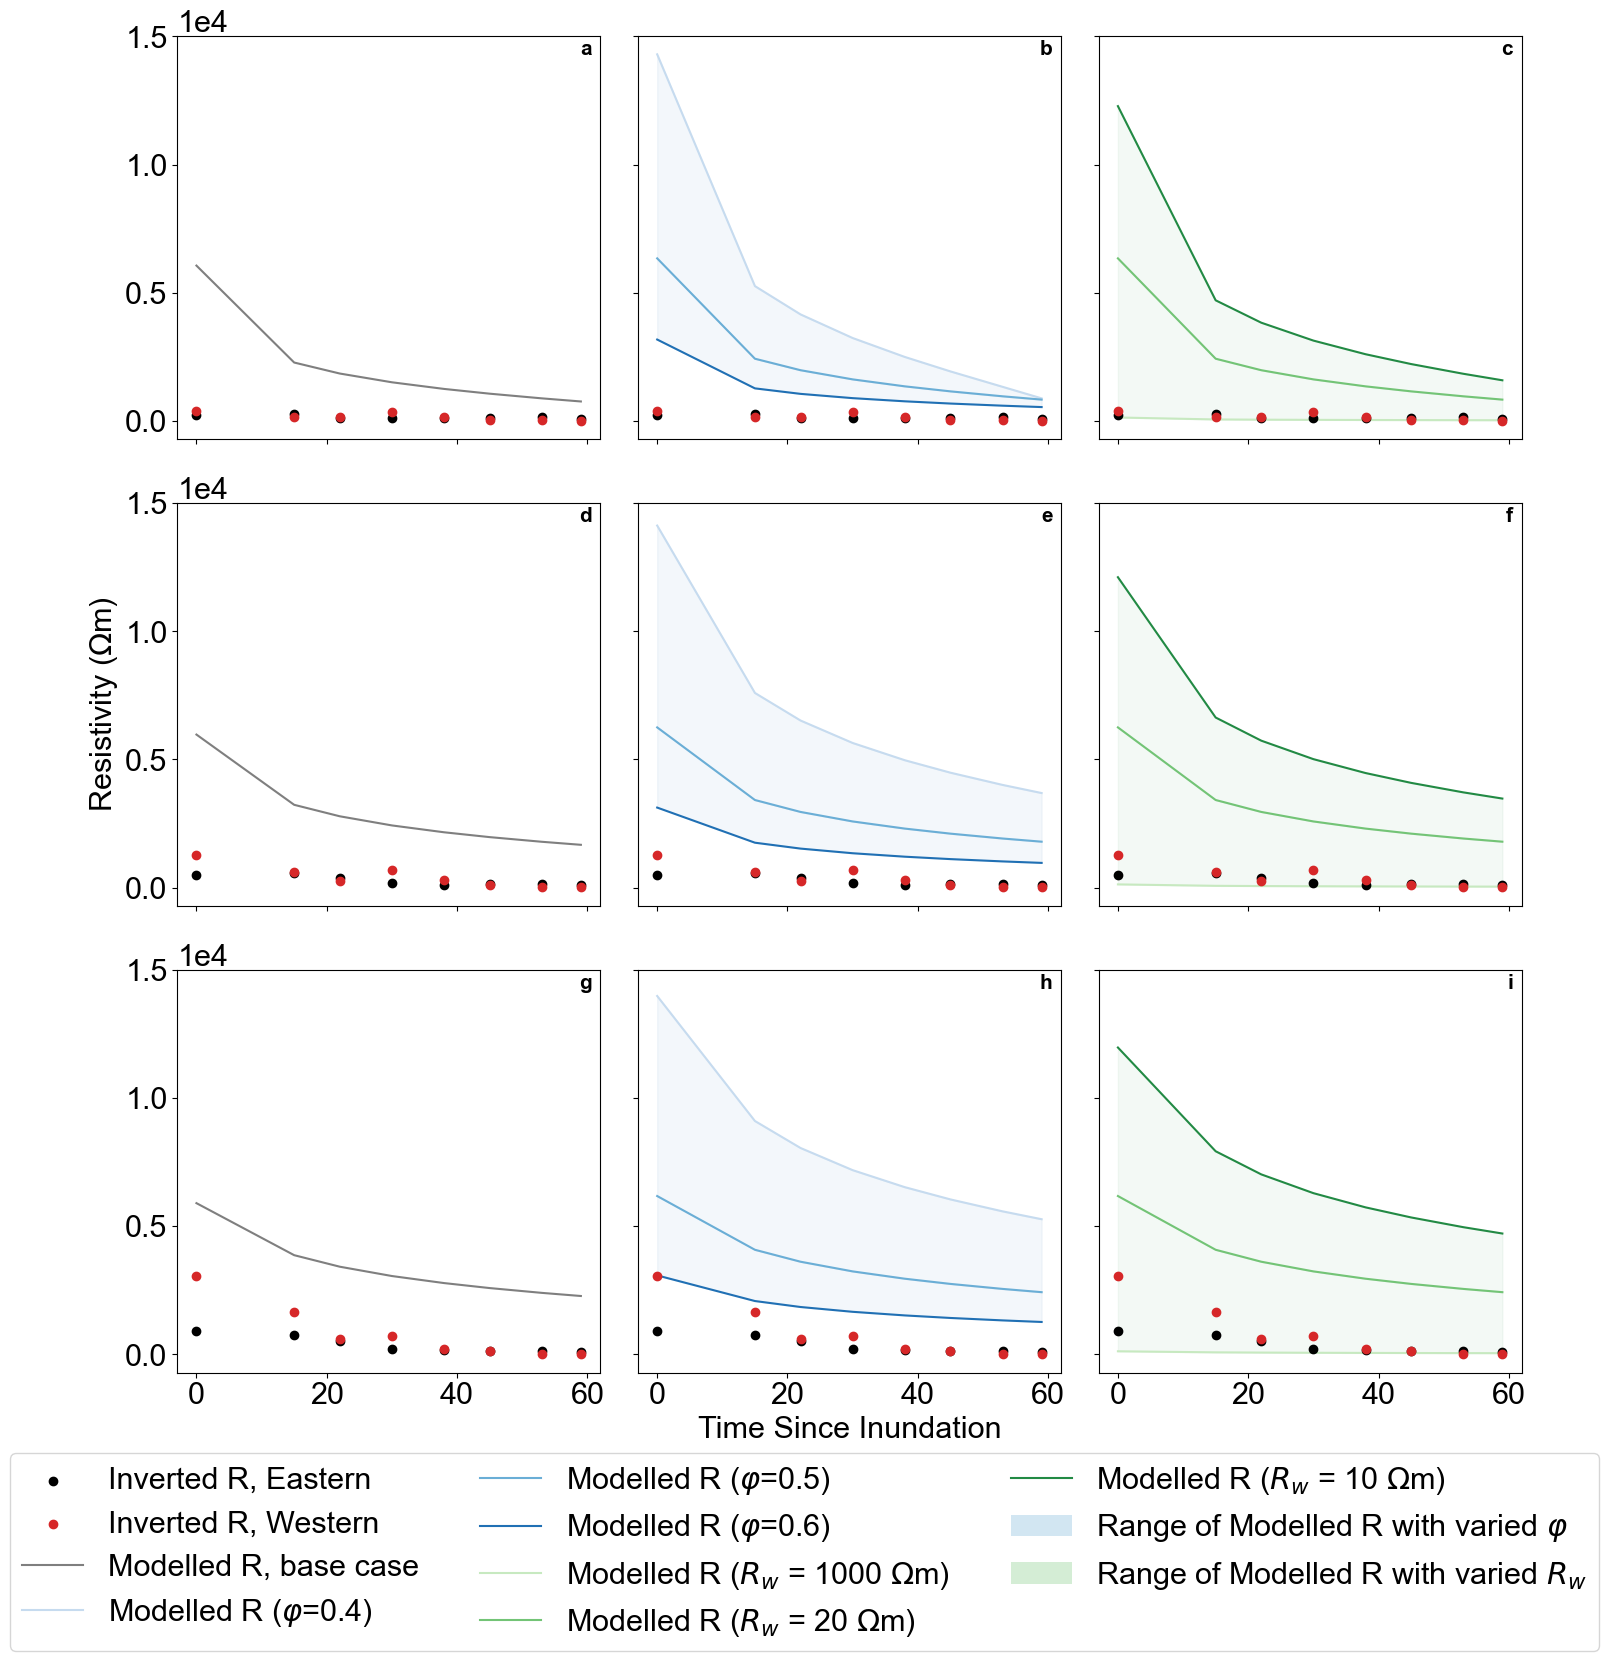

In [123]:
import string
plt.rcParams['font.size'] = 22
plt.rcParams['font.family'] = 'Arial'

porosities = [0.4, 0.5, 0.6]
porewaters = [1000, 20, 10]
depth_indices = [0,1,2]

varied_porosities = [
    #resistivity_df_30_sal15_filtered_m,
    resistivity_df_40_sal15_filtered_m,
    resistivity_df_50_sal15_filtered_m,
    resistivity_df_60_sal15_filtered_m
    #resistivity_df_70_sal15_filtered_m
]

varied_porewater = [
    resistivity_df_50_sal02381_filtered_m,
    resistivity_df_50_sal15_filtered_m,
    resistivity_df_50_sal30_filtered_m
    
]

varied_both = [
    #resistivity_df_30_sal02381_filtered_m,
    resistivity_df_40_sal02381_filtered_m,
    resistivity_df_50_sal02381_filtered_m,
    resistivity_df_60_sal02381_filtered_m,
    #resistivity_df_70_sal02381_filtered_m,
    #resistivity_df_30_sal15_filtered_m,
    resistivity_df_40_sal15_filtered_m,
    resistivity_df_50_sal15_filtered_m,
    resistivity_df_60_sal15_filtered_m,
    #resistivity_df_70_sal15_filtered_m,
    #resistivity_df_30_sal30_filtered_m,
    resistivity_df_40_sal30_filtered_m,
    resistivity_df_50_sal30_filtered_m,
    resistivity_df_60_sal30_filtered_m,
    #resistivity_df_70_sal30_filtered_m,

]


blue_shades = sns.color_palette("Blues", 3)
red_shades = sns.color_palette("Greens", 3)
mixed_shades = sns.color_palette("Purples", len(varied_both)//3)

fig, ax = plt.subplots(3, 3, figsize=(15, 15), sharex=True,  
                       sharey=True
                       )

# Loop over each depth
for i, depth_idx in enumerate(depth_indices):
    ax[i,0].scatter(time_since_inundation, rho_east.iloc[:, i+1],label="Inverted R, Eastern", color="black", zorder=3)
    ax[i,0].scatter(time_since_inundation, rho_west.iloc[:, i+1],label="Inverted R, Western", color="tab:red", zorder=3)
    ax[i,0].plot(time_since_inundation, resistivity_df_50_sal15_filtered.iloc[depth_idx, :], color='tab:gray', label=f"Modelled R, base case")
    for j in range(len(varied_porosities) - 1):  
        df1, df2 = varied_porosities[j], varied_porosities[j + 1]
        color = blue_shades[j]  
      
        ax[i,1].fill_between(time_since_inundation, df1.iloc[depth_idx, :], df2.iloc[depth_idx, :], 
                           color=blue_shades[2], alpha=0.05)  

    for df, color, porosity in zip(varied_porosities, blue_shades, porosities):
        ax[i,1].plot(time_since_inundation, df.iloc[depth_idx, :], 
                   label=f"Modelled R ($φ$={porosity})", color=color)

    ax[i,1].scatter(time_since_inundation, rho_east.iloc[:, i+1],color="black", zorder=3)
    ax[i,1].scatter(time_since_inundation, rho_west.iloc[:, i+1],color="tab:red", zorder=3)
    
    for k in range(len(varied_porewater) - 1):
        df1, df2 = varied_porewater[k], varied_porewater[k + 1]
        color = red_shades[k] 
        
        
        ax[i,2].fill_between(time_since_inundation, df1.iloc[depth_idx, :], df2.iloc[depth_idx, :], 
                           color=red_shades[2], alpha=0.05)  

   
    for df, color, porewater in zip(varied_porewater, red_shades, porewaters):
        ax[i,2].plot(time_since_inundation, df.iloc[depth_idx, :], 
                   label=f"Modelled R ($R_{{{{w}}}}$ = {porewater} $\Omega$m)", color=color)
        
    
    ax[i,2].scatter(time_since_inundation, rho_east.iloc[:, i+1], color="black", zorder=3)
    ax[i,2].scatter(time_since_inundation, rho_west.iloc[:, i+1], color="tab:red", zorder=3)
    

    # Set labels and titles
ax[2,1].set_xlabel("Time Since Inundation")
    #ax[i,0].set_title(f"Depth = {['10 m', '15 m', '20 m'][i]}", y=1.0, pad=-30)
ax[1,0].set_ylabel("Resistivity ($\Omega$m)")
    #ax[i, 0].set_title(f"Depth = {['10 m', '15 m', '20 m'][i]}", 
    #                   x=3.5, # Move the title slightly above the plot
    #                   y=0.3,  # Space it out from the plot
    #                   rotation=270, fontsize=20)
    
for i in range(3):
    for j in range(3):
        ax[i,j].ticklabel_format(style='sci', axis='y', scilimits=(0,0))    

n = 0  # Initialize n to 0 before the loop

for i in range(3):
    for j in range(3):
        # Use n to index into the alphabet and increment it after each annotation
        ax[i, j].text(0.98, 0.99, string.ascii_lowercase[n], transform=ax[i, j].transAxes,
              ha='right', va='top', fontsize=15, weight='bold')
        #ax[i, j].set_yscale('log')
        n += 1  # Increment n after each annotation

# Define legend patches for modelled resistivity ranges (porosities and porewater resistivities)
porosity_patch = Patch(facecolor=blue_shades[1], edgecolor='none', alpha=0.3, label="Range of Modelled Resistivities with varied porosities")
resistivity_patch = Patch(facecolor=red_shades[1], edgecolor='none', alpha=0.3, label="Range of Modelled Resistivities with varied porewater resistivities")

# Collect handles and labels from all three axes (ax[i, 0], ax[i, 1], ax[i, 2])
handles, labels = [], []
for i in range(3):
    
    handle, label = ax[0, i].get_legend_handles_labels()
    handles.extend(handle)
    labels.extend(label)



# Insert patches at the end of the handles and labels
handles.append(porosity_patch)
labels.append(f"Range of Modelled R with varied $φ$")

handles.append(resistivity_patch)
labels.append(r"Range of Modelled R with varied $R_{w}$")

# Add the legend to the first subplot (ax[0,0])
fig.legend(handles, labels, loc="center", ncol=3, bbox_to_anchor=(0.5, -0.05), frameon=True, fontsize=22)
plt.tight_layout()

#plt.savefig(dir + 'paper/figures/resistivity_with_time.png', bbox_inches='tight')



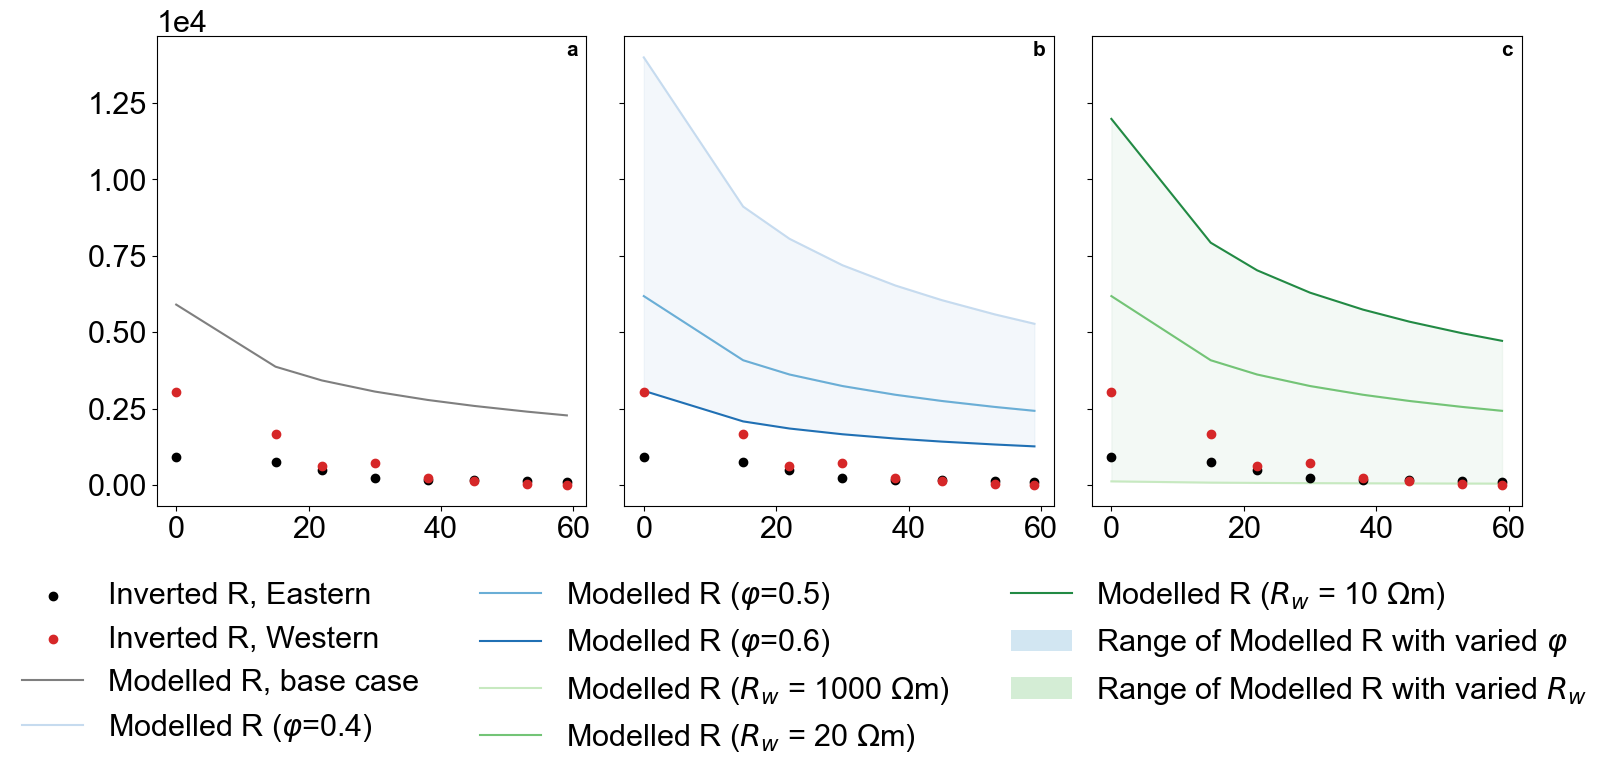

In [124]:
import string
plt.rcParams['font.size'] = 22
plt.rcParams['font.family'] = 'Arial'

porosities = [0.4, 0.5, 0.6]
porewaters = [1000, 20, 10]
depth_indices = [2]

varied_porosities = [
    #resistivity_df_30_sal15_filtered_m,
    resistivity_df_40_sal15_filtered_m,
    resistivity_df_50_sal15_filtered_m,
    resistivity_df_60_sal15_filtered_m
    #resistivity_df_70_sal15_filtered_m
]

varied_porewater = [
    resistivity_df_50_sal02381_filtered_m,
    resistivity_df_50_sal15_filtered_m,
    resistivity_df_50_sal30_filtered_m
    
]

varied_both = [
    #resistivity_df_30_sal02381_filtered_m,
    resistivity_df_40_sal02381_filtered_m,
    resistivity_df_50_sal02381_filtered_m,
    resistivity_df_60_sal02381_filtered_m,
    #resistivity_df_70_sal02381_filtered_m,
    #resistivity_df_30_sal15_filtered_m,
    resistivity_df_40_sal15_filtered_m,
    resistivity_df_50_sal15_filtered_m,
    resistivity_df_60_sal15_filtered_m,
    #resistivity_df_70_sal15_filtered_m,
    #resistivity_df_30_sal30_filtered_m,
    resistivity_df_40_sal30_filtered_m,
    resistivity_df_50_sal30_filtered_m,
    resistivity_df_60_sal30_filtered_m,
    #resistivity_df_70_sal30_filtered_m,

]


blue_shades = sns.color_palette("Blues", 3)
red_shades = sns.color_palette("Greens", 3)
mixed_shades = sns.color_palette("Purples", len(varied_both)//3)

fig, ax = plt.subplots(1, 3, figsize=(15, 6), sharex=True,  
                       sharey=True
                       )

# Loop over each depth

ax[0].scatter(time_since_inundation, rho_east.iloc[:, i+1],label="Inverted R, Eastern", color="black", zorder=3)
ax[0].scatter(time_since_inundation, rho_west.iloc[:, i+1],label="Inverted R, Western", color="tab:red", zorder=3)
ax[0].plot(time_since_inundation, resistivity_df_50_sal15_filtered.iloc[depth_idx, :], color='tab:gray', label=f"Modelled R, base case")
for j in range(len(varied_porosities) - 1):  
    df1, df2 = varied_porosities[j], varied_porosities[j + 1]
    color = blue_shades[j]  
      
    ax[1].fill_between(time_since_inundation, df1.iloc[depth_idx, :], df2.iloc[depth_idx, :], 
                           color=blue_shades[2], alpha=0.05)  

for df, color, porosity in zip(varied_porosities, blue_shades, porosities):
    ax[1].plot(time_since_inundation, df.iloc[depth_idx, :], 
                   label=f"Modelled R ($φ$={porosity})", color=color)

ax[1].scatter(time_since_inundation, rho_east.iloc[:, i+1],color="black", zorder=3)
ax[1].scatter(time_since_inundation, rho_west.iloc[:, i+1],color="tab:red", zorder=3)
    
for k in range(len(varied_porewater) - 1):
    df1, df2 = varied_porewater[k], varied_porewater[k + 1]
    color = red_shades[k] 
        
        
    ax[2].fill_between(time_since_inundation, df1.iloc[depth_idx, :], df2.iloc[depth_idx, :], 
                           color=red_shades[2], alpha=0.05)  

   
for df, color, porewater in zip(varied_porewater, red_shades, porewaters):
    ax[2].plot(time_since_inundation, df.iloc[depth_idx, :], 
                   label=f"Modelled R ($R_{{{{w}}}}$ = {porewater} $\Omega$m)", color=color)
        
    
ax[2].scatter(time_since_inundation, rho_east.iloc[:, i+1], color="black", zorder=3)
ax[2].scatter(time_since_inundation, rho_west.iloc[:, i+1], color="tab:red", zorder=3)
    

    # Set labels and titles
#ax[2,1].set_xlabel("Time Since Inundation")
    #ax[i,0].set_title(f"Depth = {['10 m', '15 m', '20 m'][i]}", y=1.0, pad=-30)
#ax[1,0].set_ylabel("Resistivity ($\Omega$m)")
    #ax[i, 0].set_title(f"Depth = {['10 m', '15 m', '20 m'][i]}", 
    #                   x=3.5, # Move the title slightly above the plot
    #                   y=0.3,  # Space it out from the plot
    #                   rotation=270, fontsize=20)
    

for j in range(3):
    ax[j].ticklabel_format(style='sci', axis='y', scilimits=(0,0))    

n = 0  # Initialize n to 0 before the loop


for j in range(3):
        # Use n to index into the alphabet and increment it after each annotation
    ax[j].text(0.98, 0.99, string.ascii_lowercase[n], transform=ax[j].transAxes,
              ha='right', va='top', fontsize=15, weight='bold')
    #ax[j].set_yscale('log')
    n += 1  # Increment n after each annotation

# Define legend patches for modelled resistivity ranges (porosities and porewater resistivities)
porosity_patch = Patch(facecolor=blue_shades[1], edgecolor='none', alpha=0.3, label="Range of Modelled Resistivities with varied porosities")
resistivity_patch = Patch(facecolor=red_shades[1], edgecolor='none', alpha=0.3, label="Range of Modelled Resistivities with varied porewater resistivities")

# Collect handles and labels from all three axes (ax[i, 0], ax[i, 1], ax[i, 2])
handles, labels = [], []
for i in range(3):
    
    handle, label = ax[i].get_legend_handles_labels()
    handles.extend(handle)
    labels.extend(label)



# Insert patches at the end of the handles and labels
handles.append(porosity_patch)
labels.append(f"Range of Modelled R with varied $φ$")

handles.append(resistivity_patch)
labels.append(r"Range of Modelled R with varied $R_{w}$")

# Add the legend to the first subplot (ax[0,0])
fig.legend(handles, labels, loc="center", ncol=3, bbox_to_anchor=(0.5, -0.15), frameon=False, fontsize=22)
plt.tight_layout()

plt.savefig(dir + 'paper/figures/resistivity_with_time.png', bbox_inches='tight')



In [106]:
# Function to calculate the ratio of ice content change
def calculate_ice_content_ratio(resistivity_df):
    """
    Computes the ratio of ice content change based on resistivity changes.
    Assumes ice content is proportional to resistivity.
    """
    initial_resistivity = resistivity_df.iloc[:, 0]  # First time step
    final_resistivity = resistivity_df.iloc[:, -1]  # Last time step

    # Compute ratio: (Initial - Final) / Initial
    ice_content_ratio = (initial_resistivity - final_resistivity) / initial_resistivity
    return ice_content_ratio

# Compute ratios for each set of variations
ice_ratio_porosities = [calculate_ice_content_ratio(df) for df in varied_porosities]
ice_ratio_porewater = [calculate_ice_content_ratio(df) for df in varied_porewater]
ice_ratio_both = [calculate_ice_content_ratio(df) for df in varied_both]

# Convert to DataFrames for easier manipulation
ice_ratio_df_porosities = pd.DataFrame(ice_ratio_porosities).T
ice_ratio_df_porewater = pd.DataFrame(ice_ratio_porewater).T
ice_ratio_df_both = pd.DataFrame(ice_ratio_both).T

# Compute probability ranges (min, max, mean, standard deviation)
ice_ratio_summary = pd.DataFrame({
    #"Depth": depth_indices,
    "Mean Ratio": ice_ratio_df_both.mean(axis=1),
    "Min Ratio": ice_ratio_df_both.min(axis=1),
    "Max Ratio": ice_ratio_df_both.max(axis=1),
    "Std Dev": ice_ratio_df_both.std(axis=1)
})

# Display results
print(ice_ratio_summary)



           Mean Ratio  Min Ratio  Max Ratio   Std Dev
Depth (m)                                            
10.0         0.881750   0.832682   0.944000  0.046706
15.0         0.716421   0.691211   0.743299  0.020549
20.0         0.608107   0.588414   0.628314  0.014775


In [100]:
import numpy as np
import pandas as pd
from scipy.stats import linregress

# Function to compute the rate of ice content change
def calculate_ice_content_rate(resistivity_df, time_vector):
    """
    Computes the rate of ice content change over time based on resistivity variations.
    Assumes ice content is proportional to resistivity.
    Automatically detects distinct phases (steep vs. steady).
    """
    initial_resistivity = resistivity_df.iloc[:, 0]  # First time step
    final_resistivity = resistivity_df.iloc[:, -1]  # Last time step
    
    # Compute ice content change ratio
    ice_content_ratio = (initial_resistivity - final_resistivity) / initial_resistivity

    # Compute instantaneous rates using time differences
    time_diffs = np.gradient(time_vector)  # Compute time step differences
    rate_of_change = np.gradient(resistivity_df.values, axis=1) / time_diffs  # Correct shape

    # Identify transition point (steep to steady phase) based on rate stabilization
    rate_means = rate_of_change.mean(axis=0)
    transition_index = np.argmax(np.abs(rate_means) < 0.7 * np.abs(rate_means[0]))  # 20% threshold
    
    transition_year = time_vector[transition_index] if transition_index > 0 else time_vector[1]

    # Compute linear fit for each phase
    steep_phase = resistivity_df.iloc[:, :transition_index]
    steady_phase = resistivity_df.iloc[:, transition_index:]

    # Fit regression for steep and steady phases
    steep_slope, _, _, _, steep_std = linregress(time_vector[:transition_index], steep_phase.mean(axis=0))
    steady_slope, _, _, _, steady_std = linregress(time_vector[transition_index:], steady_phase.mean(axis=0))

    # Convert to percentage change per year
    steep_phase_rate = steep_slope / resistivity_df.iloc[:, 0].mean()
    steady_phase_rate = steady_slope / resistivity_df.iloc[:, transition_index].mean()

    return {
        "Steep Phase Rate": steep_phase_rate,
        "Steep Rate Range": (steep_phase_rate - steep_std, steep_phase_rate + steep_std),
        "Steady Phase Rate": steady_phase_rate,
        "Steady Rate Range": (steady_phase_rate - steady_std, steady_phase_rate + steady_std),
        "Transition Year": transition_year
    }

# Apply function to datasets


rate_analysis = calculate_ice_content_rate(resistivity_df_50_sal15_filtered_m, time_since_inundation)

# Print results
print(f"Steep Phase Rate: {rate_analysis['Steep Phase Rate']:.4f} (range: {rate_analysis['Steep Rate Range']})")
print(f"Steady Phase Rate: {rate_analysis['Steady Phase Rate']:.4f} (range: {rate_analysis['Steady Rate Range']})")
print(f"Transition Point: {rate_analysis['Transition Year']} years after inundation")


Steep Phase Rate: -0.0314 (range: (-0.03143977543882791, -0.03143977543882791))
Steady Phase Rate: -0.0109 (range: (-2.259050320139699, 2.2373033340089057))
Transition Point: 22 years after inundation


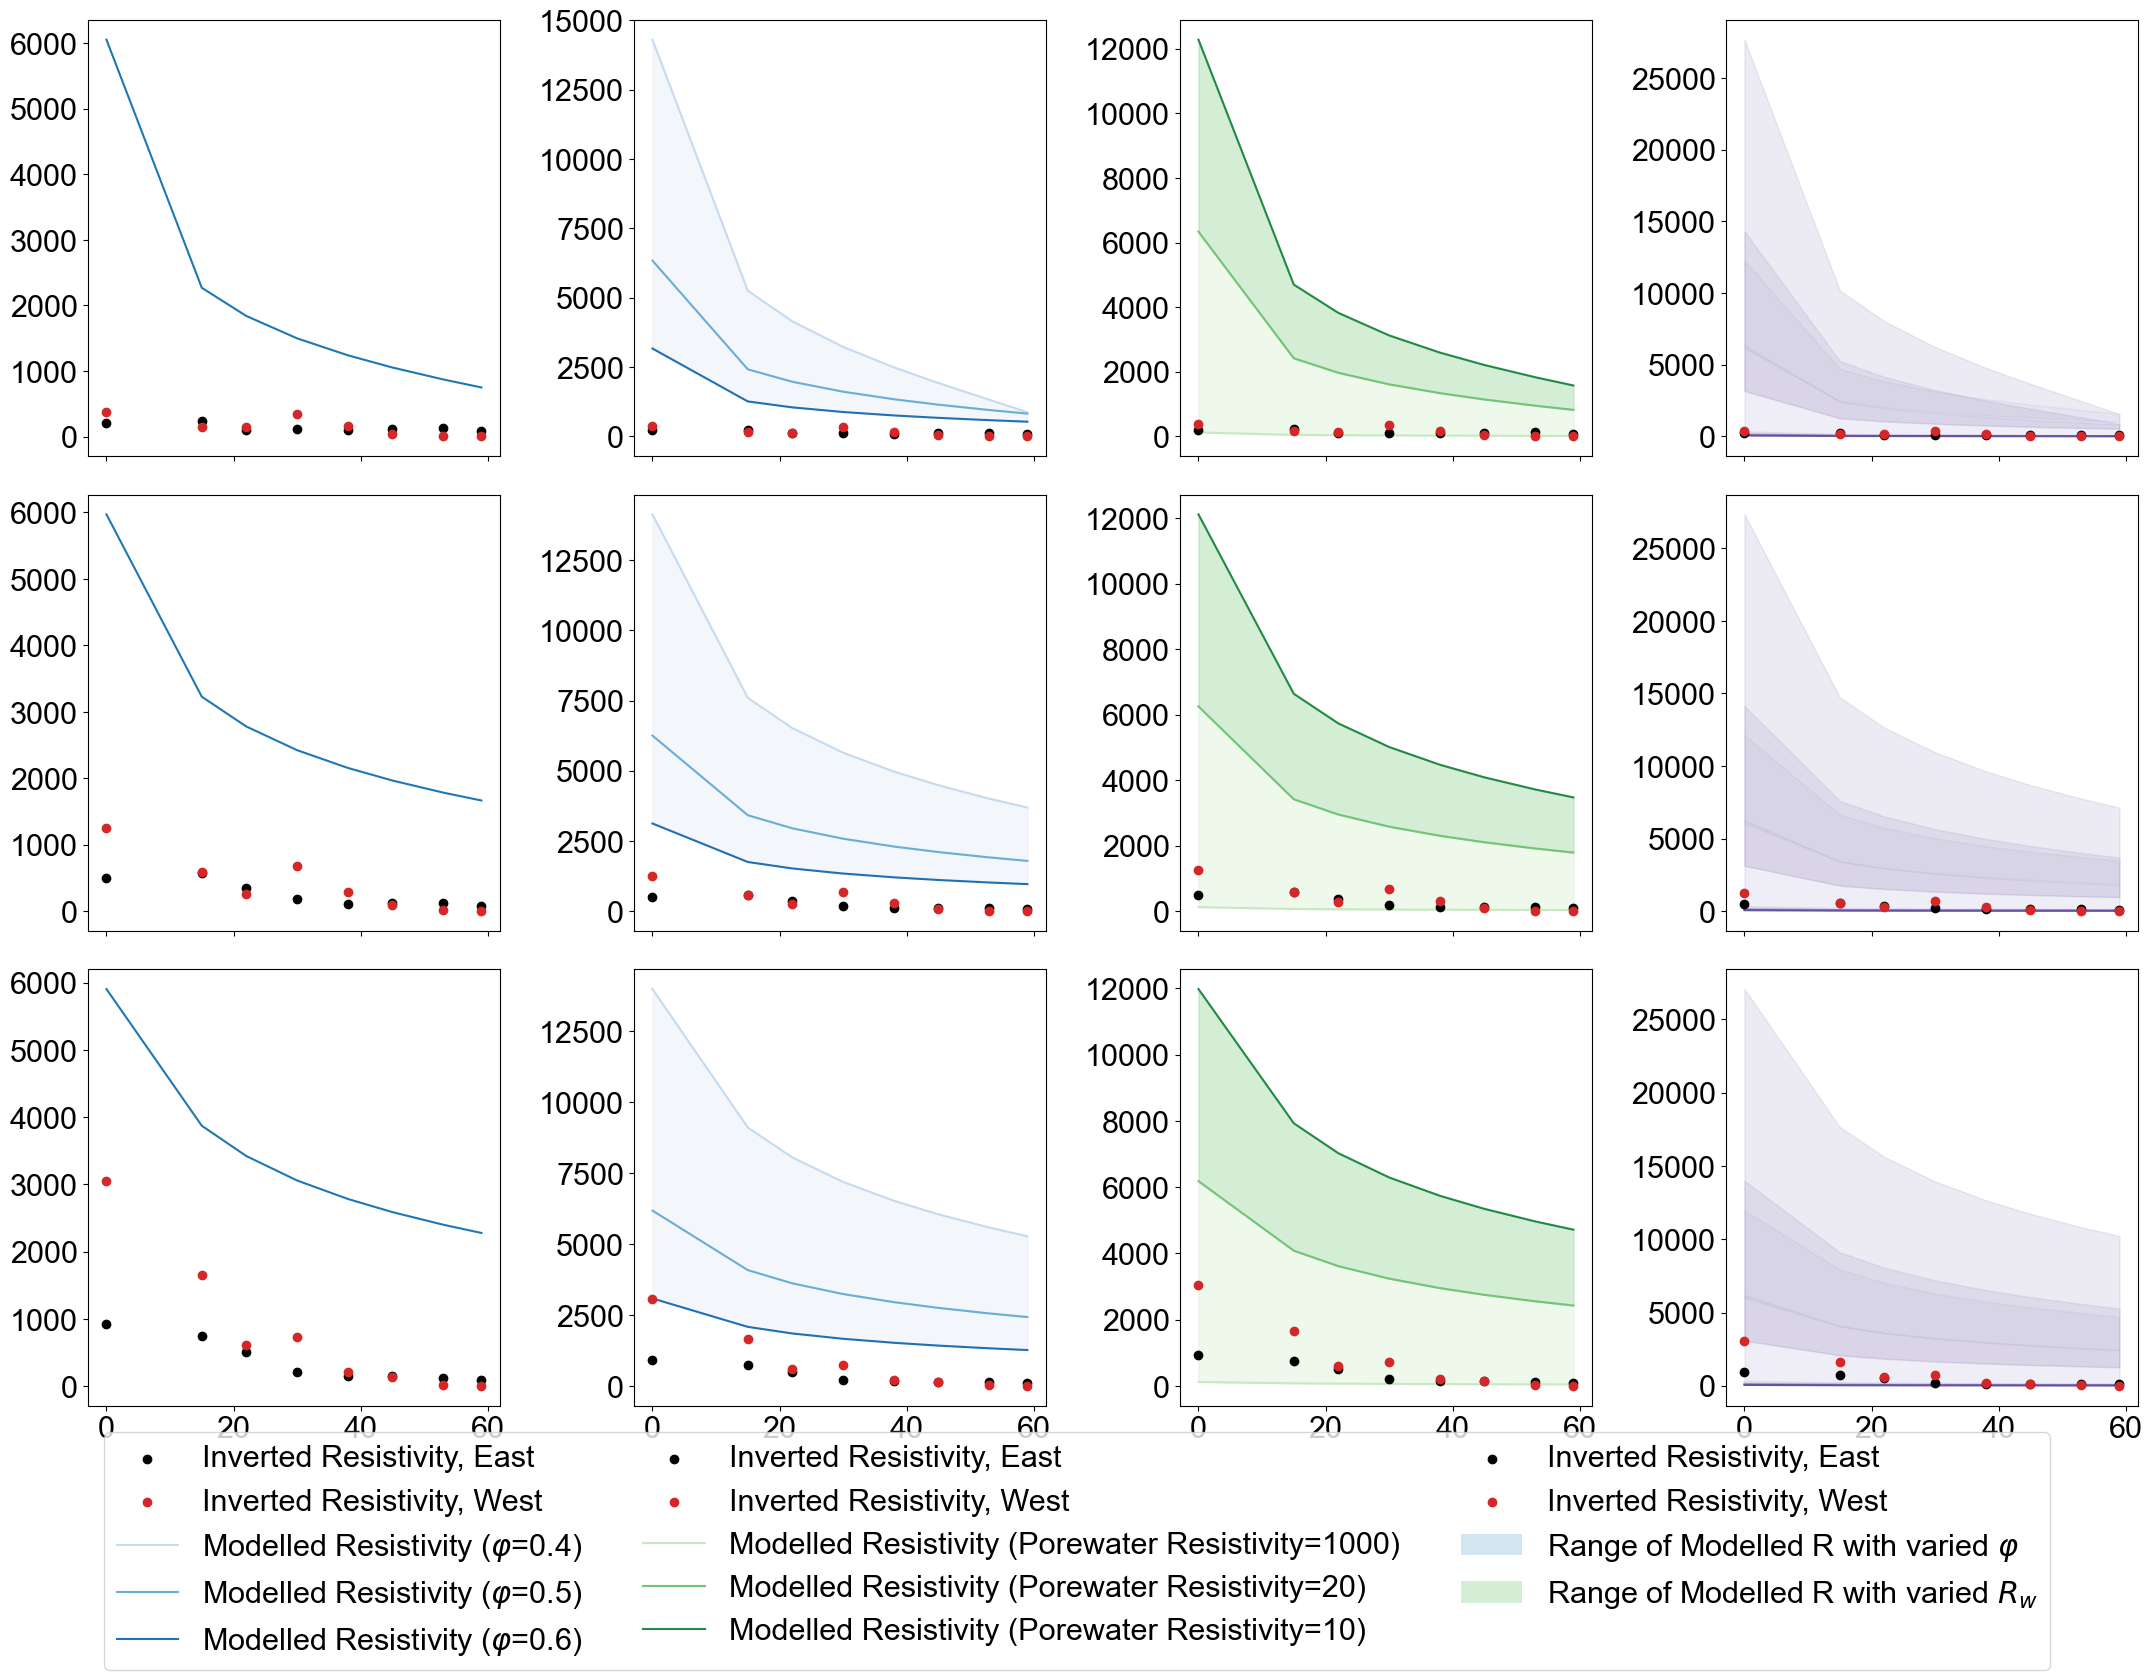

In [62]:
import string
plt.rcParams['font.size'] = 22
plt.rcParams['font.family'] = 'Arial'

porosities = [0.4, 0.5, 0.6]
porewaters = [1000, 20, 10]
depth_indices = [0,1,2]

varied_porosities = [
    #resistivity_df_30_sal15_filtered_m,
    resistivity_df_40_sal15_filtered_m,
    resistivity_df_50_sal15_filtered_m,
    resistivity_df_60_sal15_filtered_m
    #resistivity_df_70_sal15_filtered_m
]

varied_porewater = [
    resistivity_df_50_sal02381_filtered_m,
    resistivity_df_50_sal15_filtered_m,
    resistivity_df_50_sal30_filtered_m
    
]

varied_both = [
    
    resistivity_df_40_sal02381_filtered_m,
    resistivity_df_50_sal02381_filtered_m,
    resistivity_df_60_sal02381_filtered_m,
   
   
    resistivity_df_40_sal15_filtered_m,
    resistivity_df_50_sal15_filtered_m,
    resistivity_df_60_sal15_filtered_m,
    
    resistivity_df_40_sal30_filtered_m,
    resistivity_df_50_sal30_filtered_m,
    resistivity_df_60_sal30_filtered_m,
    

]


blue_shades = sns.color_palette("Blues", 3)
red_shades = sns.color_palette("Greens", 3)
mixed_shades = sns.color_palette("Purples", len(varied_both)//3)

fig, ax = plt.subplots(3, 4, figsize=(22, 15), sharex=True)

# Loop over each depth
for i, depth_idx in enumerate(depth_indices):
    ax[i,0].plot(time_since_inundation, resistivity_df_50_sal15_filtered.iloc[depth_idx, :], color='tab:blue')
    ax[i,0].scatter(time_since_inundation, rho_east.iloc[:, i+1],label="Inverted Resistivity, East", color="black", zorder=3)
    ax[i,0].scatter(time_since_inundation, rho_west.iloc[:, i+1],label="Inverted Resistivity, West", color="tab:red", zorder=3)
    for j in range(len(varied_porosities) - 1):  
        df1, df2 = varied_porosities[j], varied_porosities[j + 1]
        color = blue_shades[j]  
      
        ax[i,1].fill_between(time_since_inundation, df1.iloc[depth_idx, :], df2.iloc[depth_idx, :], 
                           color=blue_shades[2], alpha=0.05)  

    for df, color, porosity in zip(varied_porosities, blue_shades, porosities):
        ax[i,1].plot(time_since_inundation, df.iloc[depth_idx, :], 
                   label=f"Modelled Resistivity ($φ$={porosity})", color=color)

    ax[i,1].scatter(time_since_inundation, rho_east.iloc[:, i+1], 
                  label="Inverted Resistivity, East", color="black", zorder=3)
    ax[i,1].scatter(time_since_inundation, rho_west.iloc[:, i+1], 
                  label="Inverted Resistivity, West", color="tab:red", zorder=3)
    
    for k in range(len(varied_porewater) - 1):
        df1, df2 = varied_porewater[k], varied_porewater[k + 1]
        color = red_shades[k] 
        
        
        ax[i,2].fill_between(time_since_inundation, df1.iloc[depth_idx, :], df2.iloc[depth_idx, :], 
                           color=color, alpha=0.3)  

   
    for df, color, porewater in zip(varied_porewater, red_shades, porewaters):
        ax[i,2].plot(time_since_inundation, df.iloc[depth_idx, :], 
                   label=f"Modelled Resistivity (Porewater Resistivity={porewater})", color=color)
        
    
    ax[i,2].scatter(time_since_inundation, rho_east.iloc[:, i+1], 
                  label="Inverted Resistivity, East", color="black", zorder=3)
    ax[i,2].scatter(time_since_inundation, rho_west.iloc[:, i+1], 
                  label="Inverted Resistivity, West", color="tab:red", zorder=3)
    
    num_groups = len(varied_both) // len(porewaters)  # Number of porosity levels per porewater
    for k in range(len(varied_both) - 1):
        df1, df2 = varied_both[k], varied_both[k + 1]
        color = mixed_shades[k % num_groups]  # Cycle through shades

        ax[i,3].fill_between(time_since_inundation, df1.iloc[depth_idx, :], df2.iloc[depth_idx, :], 
                             color=color, alpha=0.1)

    for df, color in zip(varied_both, mixed_shades):
        ax[i,3].plot(time_since_inundation, df.iloc[depth_idx, :], color=color)

    ax[i,3].scatter(time_since_inundation, rho_east.iloc[:, i+1], 
                    label="Inverted Resistivity, East", color="black", zorder=3)
    ax[i,3].scatter(time_since_inundation, rho_west.iloc[:, i+1], 
                    label="Inverted Resistivity, West", color="tab:red", zorder=3)
# Define legend patches for modelled resistivity ranges (porosities and porewater resistivities)
porosity_patch = Patch(facecolor=blue_shades[1], edgecolor='none', alpha=0.3, label="Range of Modelled Resistivities with varied porosities")
resistivity_patch = Patch(facecolor=red_shades[1], edgecolor='none', alpha=0.3, label="Range of Modelled Resistivities with varied porewater resistivities")

# Collect handles and labels from all three axes (ax[i, 0], ax[i, 1], ax[i, 2])
handles, labels = [], []
for i in range(3):
    
    handle, label = ax[0, i].get_legend_handles_labels()
    handles.extend(handle)
    labels.extend(label)



# Insert patches at the end of the handles and labels
handles.append(porosity_patch)
labels.append(f"Range of Modelled R with varied $φ$")

handles.append(resistivity_patch)
labels.append(r"Range of Modelled R with varied $R_{w}$")

# Add the legend to the first subplot (ax[0,0])
fig.legend(handles, labels, loc="center", ncol=3, bbox_to_anchor=(0.5, -0.05), frameon=True, fontsize=22)
plt.tight_layout()

#plt.savefig(dir + 'paper/figures/resistivity_with_time.png', bbox_inches='tight')



Mooring

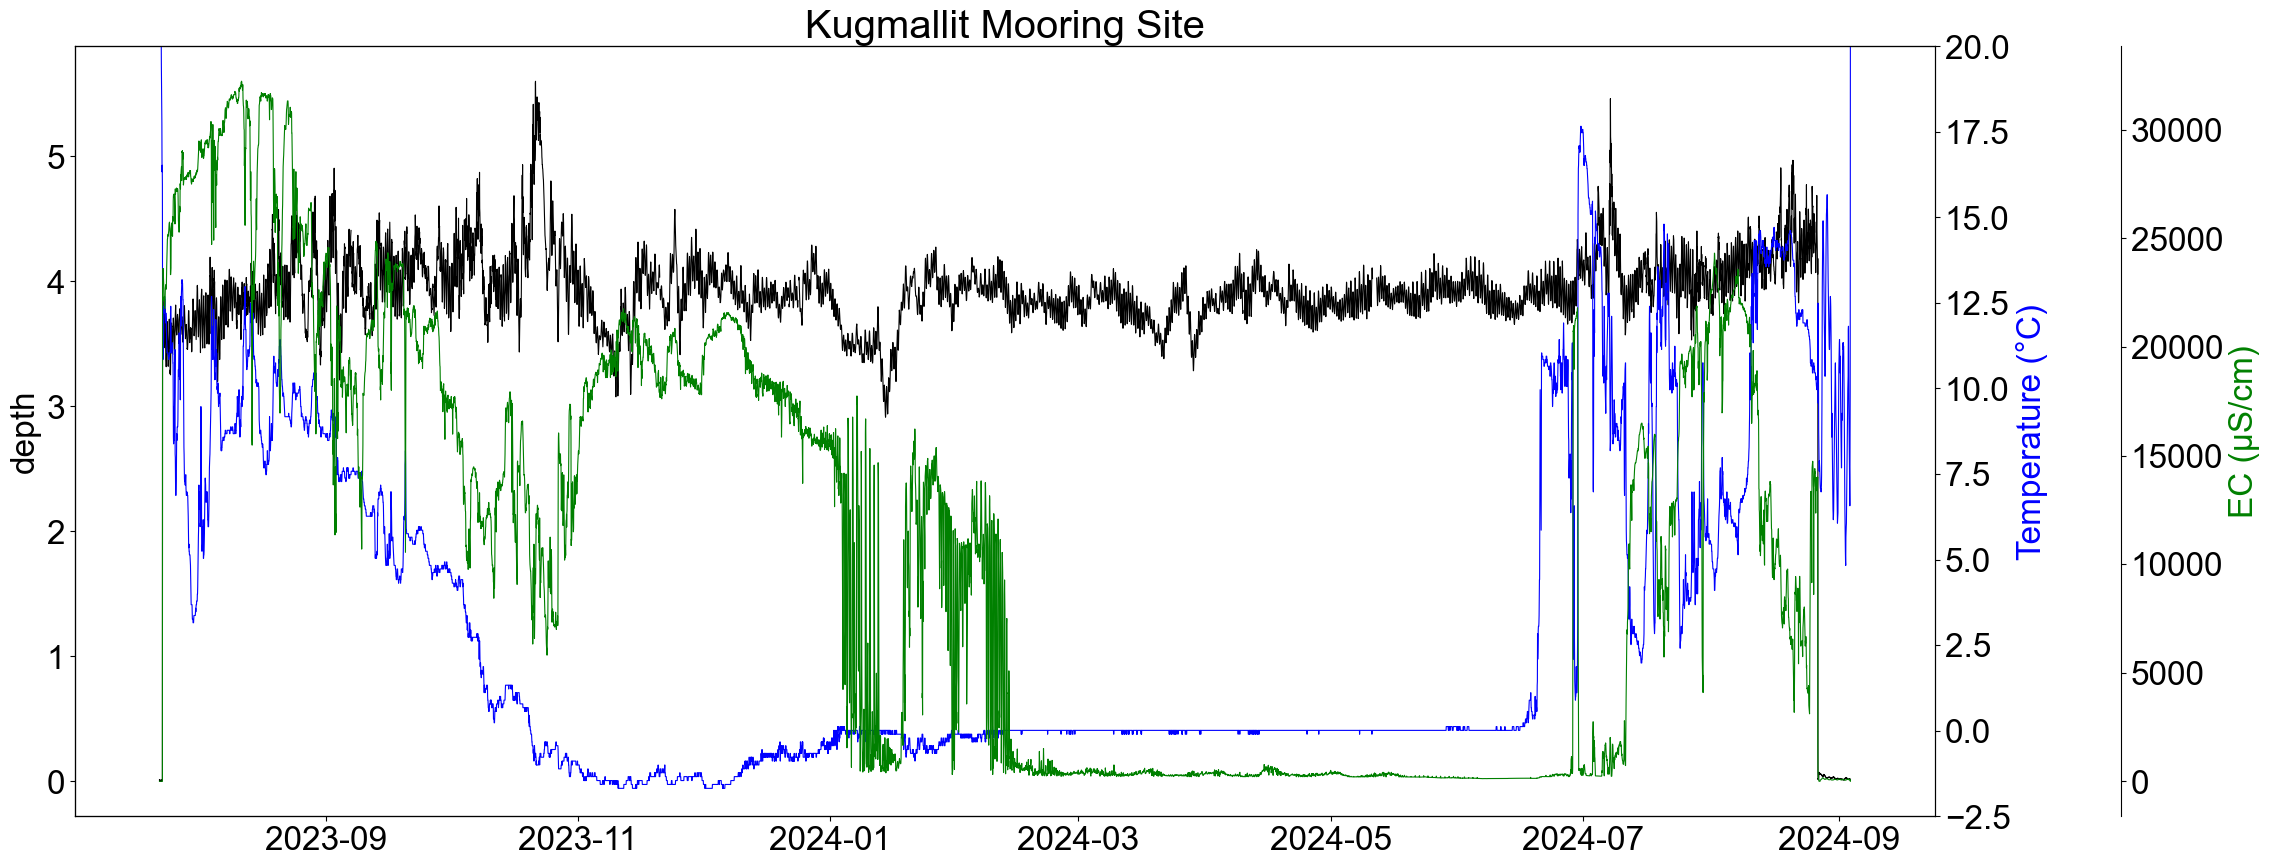

In [727]:
import datetime
Pres_logger1_data = pd.read_csv(dir+"mooring/Pres_logger1.csv")
Pres_logger2_data = pd.read_csv(dir+"mooring/Pres_logger2.csv")
Pres_logger3_data = pd.read_csv(dir+"mooring/Pres_logger3.csv")
EC_logger1_data = pd.read_csv(dir+"mooring/EC_logger1.csv")
EC_logger2_data = pd.read_csv(dir+"mooring/EC_logger2.csv")
EC_logger3_data = pd.read_csv(dir+"mooring/EC_logger3.csv")

Pres_logger1_data['Datum Zeit, GMT+00:00'] = pd.to_datetime(Pres_logger1_data['Datum Zeit, GMT+00:00'])
Pres_logger2_data['Datum Zeit, GMT+00:00'] = pd.to_datetime(Pres_logger2_data['Datum Zeit, GMT+00:00'])
Pres_logger3_data['Datum Zeit, GMT+00:00'] = pd.to_datetime(Pres_logger3_data['Datum Zeit, GMT+00:00'])
EC_logger1_data['Datum Zeit, GMT+00:00'] = pd.to_datetime(EC_logger1_data['Datum Zeit, GMT+00:00'])
EC_logger2_data['Datum Zeit, GMT+00:00'] = pd.to_datetime(EC_logger2_data['Datum Zeit, GMT+00:00'])
EC_logger3_data['Datum Zeit, GMT+00:00'] = pd.to_datetime(EC_logger3_data['Datum Zeit, GMT+00:00'])

plt.rcParams['font.size'] = 24
plt.rcParams['font.family'] = 'Arial'
plt.style.use('seaborn-v0_8-colorblind')

fig, ax1 = plt.subplots(figsize=(24,10))
    
#ax1.plot(Pres_logger1_data['Datum Zeit, GMT+00:00'], Pres_logger1_data['depth'], 'k-', lw=.4, label='depth')
#ax1.plot(Pres_logger2_data['Datum Zeit, GMT+00:00'], Pres_logger2_data['depth'], 'k-', lw=.4, label='depth')
ax1.plot(Pres_logger3_data['Datum Zeit, GMT+00:00'], Pres_logger3_data['depth'], 'k-', lw=.8, label='depth')
#ax1.plot(Pres_logger2_data['Datum Zeit, GMT+00:00'], Pres_logger2_data.columns()[2], 'k-', lw=.4, label='pressure')
ax2 = ax1.twinx()
#ax2.plot(Pres_logger1_data['Datum Zeit, GMT+00:00'], Pres_logger1_data['Temp., °C (LGR S/N: 20962907, SEN S/N: 20962907)'], 'b-', lw=.4)
#ax2.plot(Pres_logger2_data['Datum Zeit, GMT+00:00'], Pres_logger2_data['Temp., °C (LGR S/N: 20962913, SEN S/N: 20962913)'], 'b-', lw=.4)
ax2.plot(Pres_logger3_data['Datum Zeit, GMT+00:00'], Pres_logger3_data['Temp., °C (LGR S/N: 20962914, SEN S/N: 20962914)'], 'b-', lw=.8)
ax3 = ax1.twinx()
ax3.plot(EC_logger1_data['Datum Zeit, GMT+00:00'], EC_logger1_data['Niedriger Bereich, μS/cm (LGR S/N: 21009280, SEN S/N: 21009280)'], 'g-', lw=.8)
#ax3.plot(EC_logger2_data['Datum Zeit, GMT+00:00'], EC_logger2_data['Niedriger Bereich, μS/cm (LGR S/N: 21009290, SEN S/N: 21009290)'], 'g-', lw=.4)
#ax3.plot(EC_logger3_data['Datum Zeit, GMT+00:00'], EC_logger3_data['Niedriger Bereich, μS/cm (LGR S/N: 21009296, SEN S/N: 21009296)'], 'g-', lw=.4)

#plt.gca().invert_yaxis()
#ax1.tick_params(axis='x', rotation=45)
#ax2.tick_params(axis='x', rotation=45)
#ax1.set_xlabel('Temperature', color='r')
#ax2.set_xlabel('Salinity', color='b')

#ax1.set_xlim([datetime.date(2023, 7, 23), datetime.date(2024, 8, 26)])
ax1.set_ylabel('depth')
ax2.set_ylabel('Temperature (°C)', color='b')
ax3.set_ylabel('EC (μS/cm)', color='g')
ax3.spines.right.set_position(("axes", 1.1))
#ax1.legend()

plt.title('Kugmallit Mooring Site')
ax2.set_ylim(-2.5, 20)
ax3.set_ylim()
plt.show()

Gound temperature

In [672]:

daily_ground_T = pd.read_csv(dir + 'ground_T/daily_ground_T.csv')
daily_ground_T.iloc[:, 0] = pd.to_datetime(daily_ground_T.iloc[:, 0], format='mixed')
daily_ground_T.set_index(daily_ground_T.columns[0], inplace=True)
daily_ground_T = daily_ground_T.dropna()

In [673]:
daily_ground_T

0.5 m   1.0 m   1.5 m   2.0 m   4.0 m   7.0 m  12.0 m  \
Date/Time                                                                     
2018-08-20 19:00:00 -0.0290 -0.9478 -2.0841 -3.9305 -4.9152 -5.2814 -5.2272   
2018-08-21 03:00:00  0.0072 -0.9165 -2.2813 -4.2503 -5.1439 -5.4167 -5.3351   
2018-08-21 11:00:00  0.0040 -0.9145 -2.2778 -4.2531 -5.1415 -5.4169 -5.3362   
2018-08-21 19:00:00  2.4155 -0.1402 -1.6589 -3.9183 -5.0017 -5.4254 -5.3431   
2018-08-22 03:00:00  1.6991 -0.1433 -1.6537 -3.9121 -4.9976 -5.4233 -5.3443   
...                     ...     ...     ...     ...     ...     ...     ...   
2022-08-20 03:00:00  1.3683 -0.7708 -2.4974 -4.8862 -5.9413 -6.0743 -5.6217   
2022-08-20 11:00:00  1.2352 -0.7666 -2.4919 -4.8803 -5.9188 -6.0731 -5.6221   
2022-08-20 19:00:00  1.1974 -0.7586 -2.4774 -4.8539 -5.9296 -6.0710 -5.6226   
2022-08-21 03:00:00  1.1033 -0.7579 -2.4803 -4.8669 -5.9118 -6.0688 -5.6236   
2022-08-21 11:00:00  1.0801 -0.7509 -2.4630 -4.8355 -5.9172 -6.0672 -5.6245   

                     20.0 m  
Date/Time                    
2018-08-20 19:00:00 -5.3055  
2018-08-21 03:00:00 -5.3233  
2018-08-21 11:00:00 -5.3233  
2018-08-21 19:00:00 -5.3149  
2018-08-22 03:00:00 -5.3156  
...                     ...  
2022-08-20 03:00:00 -5.3188  
2022-08-20 11:00:00 -5.3182  
2022-08-20 19:00:00 -5.3191  
2022-08-21 03:00:00 -5.3119  
2022-08-21 11:00:00 -5.3200  

[4266 rows x 8 columns]

Depth of Zero Annual Amplitude (DZAA): 18.68 m


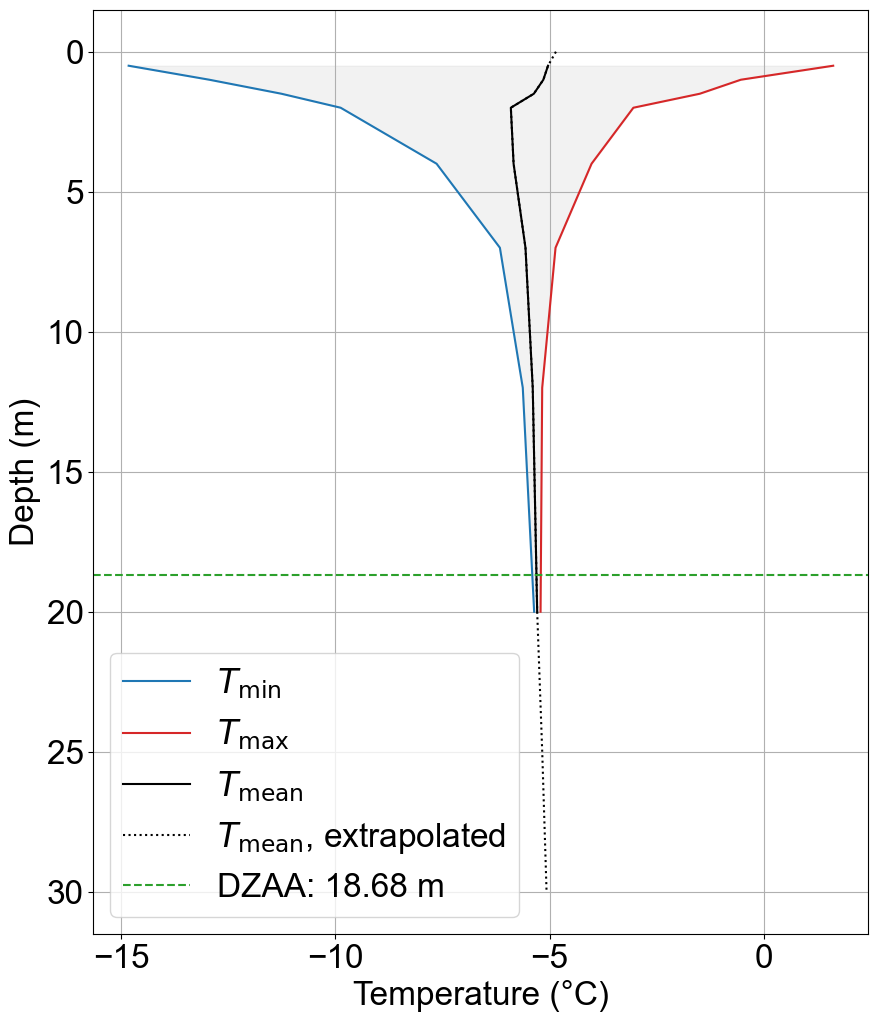

In [877]:


plt.figure(figsize=(10, 12))
plt.rcParams['font.size'] = 24
plt.rcParams['font.family'] = 'Arial'
plt.style.use('seaborn-v0_8-colorblind')
daily_ground_T_subset = daily_ground_T['2021-08-21T11:00:00.000':'2022-08-21T11:00:00.000']

trumpet_data = daily_ground_T_subset.iloc[:, :].agg(['min', 'max', 'mean']).transpose()
trumpet_data['Depth'] = trumpet_data.index.str.replace(' m', '').astype(float)

def extrapolate_temperature(depths, temps, new_depth):
    coeffs = np.polyfit(depths, temps, 1)  
    return np.polyval(coeffs, new_depth)  

shallow_depths = trumpet_data['Depth'][:3]
extrapolated_row_0 = {
    'Depth': 0,
#    'min': extrapolate_temperature(shallow_depths, trumpet_data['min'][:3], 0),
#    'max': extrapolate_temperature(shallow_depths, trumpet_data['max'][:3], 0),
    'mean': extrapolate_temperature(shallow_depths, trumpet_data['mean'][:3], 0)
}

deep_depths = trumpet_data['Depth'][-3:]
#deep_min_temps = trumpet_data['min'][-2:]
#deep_max_temps = trumpet_data['max'][-2:]
deep_mean_temps = trumpet_data['mean'][-3:]

new_depths = [25, 30]
extrapolated_rows_deep = []

for depth in new_depths:
    extrapolated_rows_deep.append({
        'Depth': depth,
        #'min': extrapolate_temperature(deep_depths, deep_min_temps, depth),
        #'max': extrapolate_temperature(deep_depths, deep_max_temps, depth),
        'mean': extrapolate_temperature(deep_depths, deep_mean_temps, depth)
    })


extrapolated_rows = pd.DataFrame([extrapolated_row_0] + extrapolated_rows_deep)

trumpet_data = pd.concat([trumpet_data, extrapolated_rows], ignore_index=True)

trumpet_data = trumpet_data.sort_values(by='Depth')

trumpet_data['amplitude'] = (trumpet_data['max'] - trumpet_data['min']) / 2

# Define threshold for zero amplitude
amplitude_threshold = 0.1  # Adjust based on the desired precision

# Find bounding depths
above_threshold = trumpet_data[trumpet_data['amplitude'] > amplitude_threshold]
below_threshold = trumpet_data[trumpet_data['amplitude'] <= amplitude_threshold]

if not below_threshold.empty:
    z1 = above_threshold.iloc[-1]['Depth']
    z2 = below_threshold.iloc[0]['Depth']
    A1 = above_threshold.iloc[-1]['amplitude']
    A2 = below_threshold.iloc[0]['amplitude']
    
    # Interpolate for DZAA
    dzaa_depth = z1 + ((amplitude_threshold - A1) / (A2 - A1)) * (z2 - z1)
    print(f"Depth of Zero Annual Amplitude (DZAA): {dzaa_depth:.2f} m")
else:
    print("No depth meets the zero annual amplitude threshold.")

plt.fill_betweenx(
    trumpet_data['Depth'],  # Depth (y-axis)
    trumpet_data['min'],  # Min temperature (left bound)
    trumpet_data['max'],  # Max temperature (right bound)
    color='silver', alpha=0.2
)


plt.plot(trumpet_data['min'], trumpet_data['Depth'], color='tab:blue', label=r'$T_{\text{min}}$')
plt.plot(trumpet_data['max'], trumpet_data['Depth'], color='tab:red', label=r'$T_{\text{max}}$')
plt.plot(trumpet_data['mean'][1:9], trumpet_data['Depth'][1:9], color='black', label=r'$T_{\text{mean}}$')
plt.plot(trumpet_data['mean'][0:9], trumpet_data['Depth'][0:9], color='black', label=r'$T_{\text{mean}}$, extrapolated', linestyle=':')
plt.plot(trumpet_data['mean'][8:], trumpet_data['Depth'][8:], color='black', linestyle=':')
plt.gca().invert_yaxis()
# Highlight DZAA (if it exists)
if not below_threshold.empty:
    plt.axhline(dzaa_depth, color='tab:green', linestyle='--', label=f'DZAA: {dzaa_depth:.2f} m')

plt.xlabel('Temperature (°C)')
plt.ylabel('Depth (m)')
plt.grid(True)
plt.legend()


Station 50 - x values where y_newer=0: [135.0]
Station 51 - x values where y_newer=0: [125.0]
Station 52 - x values where y_newer=0: [110.0]


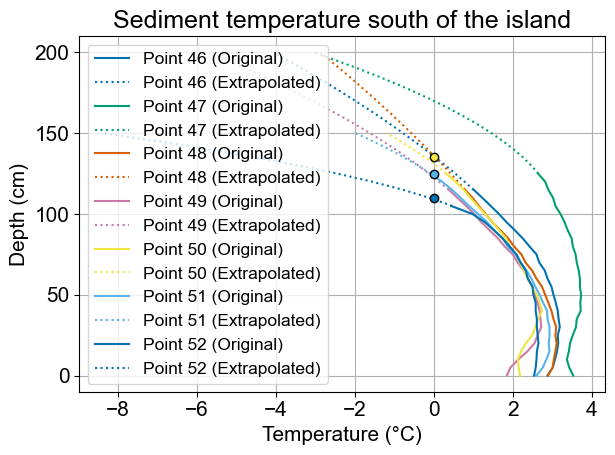

In [789]:


ddir = 'N:/isipd/projects/p_subaqua/Expeditions/2023/NWT2023/analysis_Tuk/Tuk_all_mehriban/Tsediment/TukIsland_processedCSV'

events = {}
for filename in os.listdir(ddir):
    match = re.match(r'event(\d+)\.csv$', filename)
    if match:
        event_number = int(match.group(1))  # Extract number as an integer
        events[event_number] = pd.read_csv(os.path.join(ddir, filename))

event_numbers_group1 = range(46, 50)
event_numbers_group2 = range(50, 53)

for k in range(46, 50):
    df = events[k]
    
    x = df['depth_cm'].to_numpy()
    y = df['soilTemp_degC'].to_numpy()
    
    p = np.polyfit(x[-5:], y[-5:], deg=2)
    x_new = np.arange(x.max(), 205, 5)
    y_new = np.polyval(p, x_new)
    
    x_newer = np.append(x,x_new)
    y_newer = np.append(y,y_new)

    plt.plot(y, x, label=f'Point {k} (Original)', linestyle='-', color=f"C{k-46}")
    plt.plot(y_new, x_new, label=f'Point {k} (Extrapolated)', linestyle=':', color=f"C{k-46}")  

ax = plt.gca()
ax.invert_yaxis()
plt.xlabel('Temperature (°C)')
plt.ylabel('Depth (cm)')
plt.title('Sediment temperature south of the island')
plt.legend(fontsize='small')
plt.tight_layout()
plt.grid(True)  

for k in range(50, 53):
    df = events[k]
    x = df['depth_cm'].to_numpy()
    y = df['soilTemp_degC'].to_numpy()
    
    p = np.polyfit(x[-5:], y[-5:], deg=2)
    x_new = np.arange(df['depth_cm'].max(), 155, 5)
    y_new = np.polyval(p, x_new)
    
    x_newer = np.append(x,x_new)
    y_newer = np.append(y,y_new)

    plt.plot(y, x, label=f'Point {k} (Original)', linestyle='-', color=f"C{k-46}")
    
    plt.plot(y_new, x_new, label=f'Point {k} (Extrapolated)', linestyle=':', color=f"C{k-46}")  
    zero_crossings = np.where(np.diff(np.sign(y_newer)))[0]  
    zero_x_values = []
    
    for idx in zero_crossings:
        
        x_zero = np.interp(0, [y_newer[idx], y_newer[idx + 1]], [x_newer[idx], x_newer[idx + 1]])
        zero_x_values.append(x_zero)
    
    print(f"Station {k} - x values where y_newer=0: {zero_x_values}")
    
    
    for x_zero in zero_x_values:
        plt.scatter(0, x_zero, color=f"C{k-46}", edgecolor='black', zorder=5)  

ax = plt.gca()
ax.invert_yaxis()
plt.xlabel('Temperature (°C)')
plt.ylabel('Depth (cm)')
#ax.set_xlim(-1, 4)
plt.title('Sediment temperature south of the island')
plt.legend(fontsize='small')
plt.tight_layout()
plt.grid(True)    

CTD

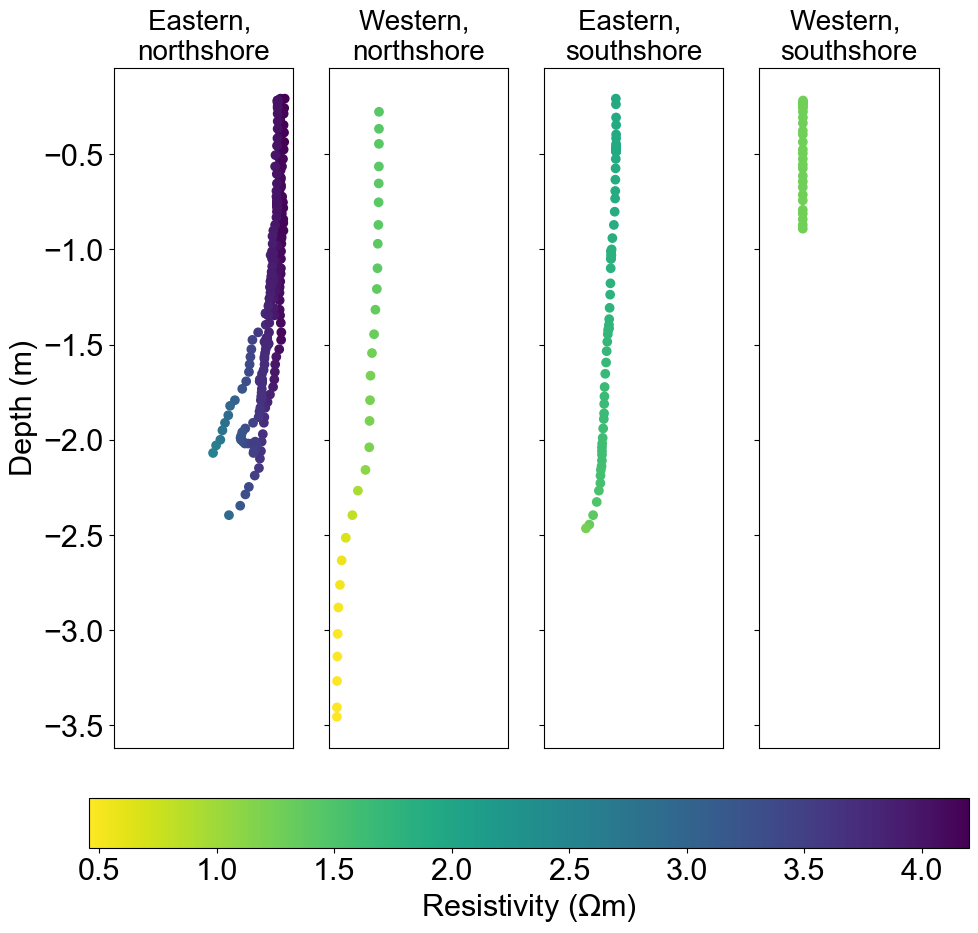

In [1176]:
AML_all_dates_filtered = pd.read_csv(dir+"CTD/AML_all_dates_filtered.csv")
station_groups = AML_all_dates_filtered.groupby('Station')

plt.rcParams['font.size'] = 22
plt.rcParams['font.family'] = 'Arial'

# Get overall min and max resistivity for normalization
overall_min_resistivity = AML_all_dates_filtered['Resistivity_Ohm_m'].min()
overall_max_resistivity = AML_all_dates_filtered['Resistivity_Ohm_m'].max()
norm = plt.Normalize(overall_min_resistivity, overall_max_resistivity)
cmap = plt.cm.viridis_r

# Create a 1x4 subplot grid
fig, ax = plt.subplots(1, 4, figsize=(10, 10), sharey=True, sharex=True)

# Filter the stations
east_north1 = AML_all_dates_filtered[AML_all_dates_filtered['Station'] == '025601_5']
east_north2 = AML_all_dates_filtered[AML_all_dates_filtered['Station'] == '025601_6']
east_north3 = AML_all_dates_filtered[AML_all_dates_filtered['Station'] == '025601_7']
east_north4 = AML_all_dates_filtered[AML_all_dates_filtered['Station'] == '025601_8']
east_south = AML_all_dates_filtered[AML_all_dates_filtered['Station'] == '026115_1']
west_north = AML_all_dates_filtered[AML_all_dates_filtered['Station'] == '026115_26']
west_south = AML_all_dates_filtered[AML_all_dates_filtered['Station'] == '026115_27']

# Plotting scatter plots with consistent colormap normalization
ax[0].scatter(east_north1['Resistivity_Ohm_m'], east_north1['depth'], 
              c=east_north1['Resistivity_Ohm_m'], cmap=cmap, norm=norm)
ax[0].scatter(east_north2['Resistivity_Ohm_m'], east_north2['depth'], 
              c=east_north2['Resistivity_Ohm_m'], cmap=cmap, norm=norm)
ax[0].scatter(east_north3['Resistivity_Ohm_m'], east_north3['depth'], 
              c=east_north3['Resistivity_Ohm_m'], cmap=cmap, norm=norm)
ax[0].scatter(east_north4['Resistivity_Ohm_m'], east_north4['depth'], 
              c=east_north4['Resistivity_Ohm_m'], cmap=cmap, norm=norm)

ax[1].scatter(west_north['Resistivity_Ohm_m'], west_north['depth'], 
              c=west_north['Resistivity_Ohm_m'], cmap=cmap, norm=norm)
ax[2].scatter(east_south['Resistivity_Ohm_m'], east_south['depth'], 
              c=east_south['Resistivity_Ohm_m'], cmap=cmap, norm=norm)
ax[3].scatter(west_south['Resistivity_Ohm_m'], west_south['depth'], 
              c=west_south['Resistivity_Ohm_m'], cmap=cmap, norm=norm)

# Remove x-axis labels and ticks
for i in range(4):
    ax[i].set_xticklabels([])
    ax[i].set_xticks([])

# Create a colorbar with correct normalization
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([]) 
cax = fig.add_axes([0.1, 0.1, 0.88, 0.05]) 
fig.colorbar(sm, cax=cax, orientation='horizontal', label='Resistivity ($\Omega$m)')

# Set labels and titles
ax[0].set_ylabel("Depth (m)")
ax[0].set_title("Eastern, \nnorthshore", fontsize=20)
ax[1].set_title("Western, \nnorthshore", fontsize=20)
ax[2].set_title("Eastern, \nsouthshore", fontsize=20)
ax[3].set_title("Western, \nsouthshore", fontsize=20)

plt.subplots_adjust(right=0.95, bottom=0.2)
dir='//smb.isipd.dmawi.de/projects/p_subaqua/Expeditions/2023/NWT2023/analysis_Tuk/Tuk_all_mehriban/'
plt.savefig(dir+'paper/figures/ctd.png', bbox_inches='tight')



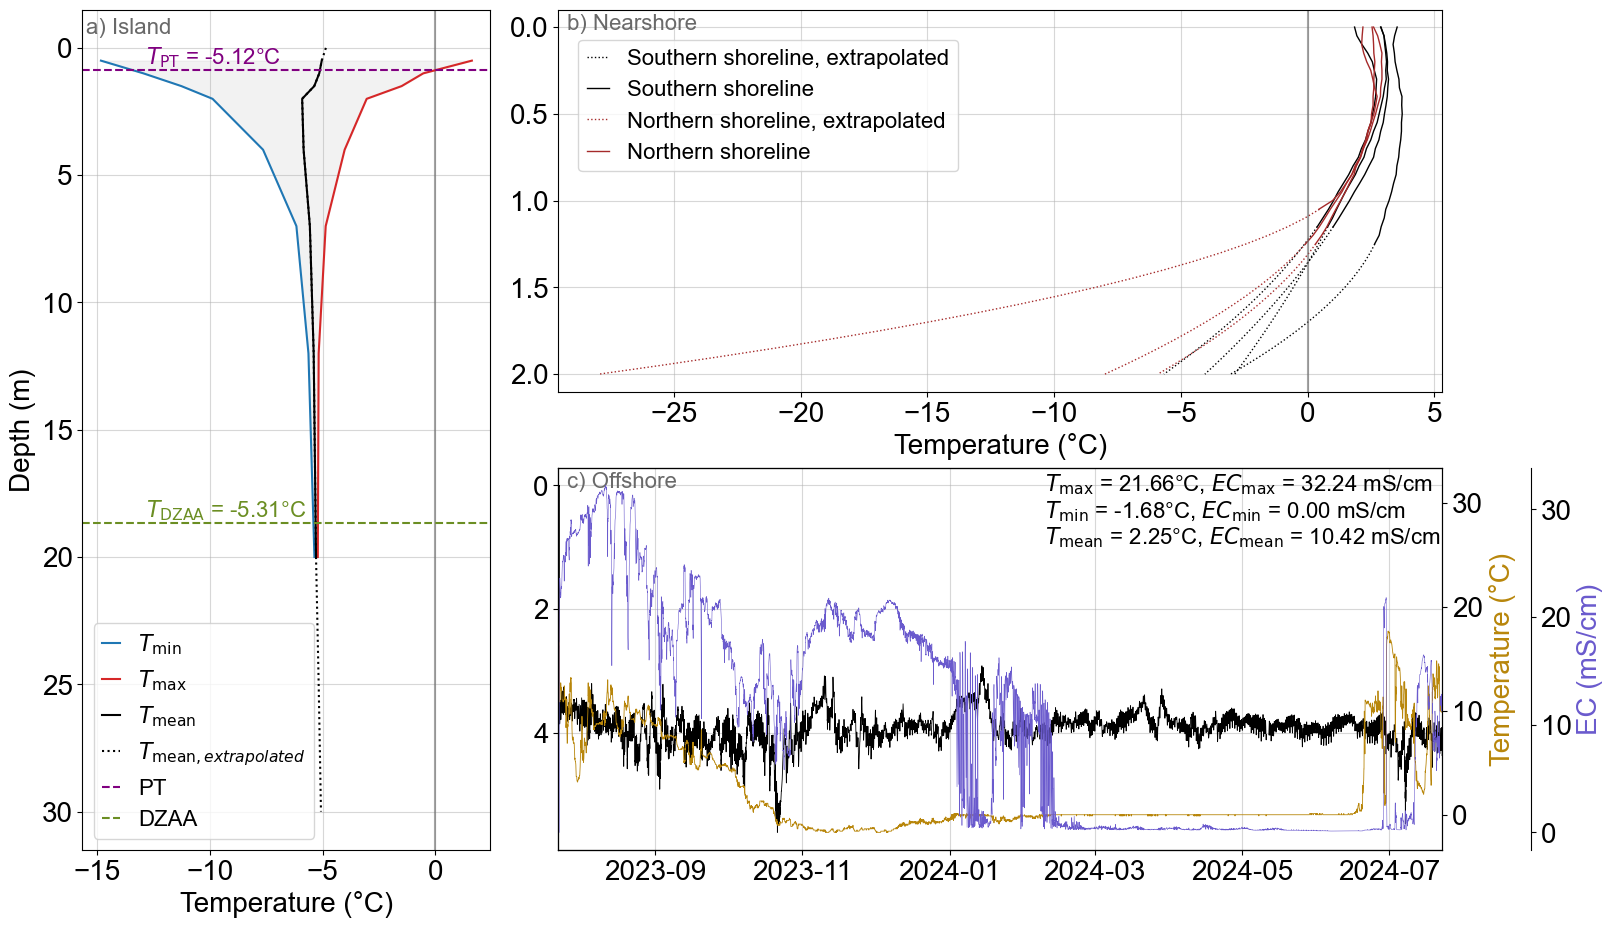

In [1089]:
def annotate_axes(ax, text, fontsize=16):
    ax.text(0.01, 0.99, text, transform=ax.transAxes,
            ha="left", va="top", fontsize=fontsize, color="dimgrey")

plt.rcParams['font.size'] = 20
plt.rcParams['font.family'] = 'Arial'

fig = plt.figure(layout=None, figsize=(16, 10))

gs = fig.add_gridspec(nrows=6, ncols=6, left=0.05, right=0.9,top=0.95,
                      hspace=1, wspace=0.4)

ax0 = fig.add_subplot(gs[:, 0:2])
annotate_axes(ax0, 'a) Island')
ax1 = fig.add_subplot(gs[0:3, 2:])
annotate_axes(ax1, 'b) Nearshore')
#ax2 = fig.add_subplot(gs[0:3, 4:], sharex = ax1)
#annotate_axes(ax2, 'b2')
ax3 = fig.add_subplot(gs[3:, 2:6])
annotate_axes(ax3, 'c) Offshore')




ax0.axvline(0, color='dimgrey', linestyle='-', alpha=0.6)
ax0.fill_betweenx(trumpet_data['Depth'],  trumpet_data['min'],  trumpet_data['max'],  color='silver', alpha=0.2)
ax0.plot(trumpet_data['min'], trumpet_data['Depth'], color='tab:blue', label=r'$T_{\text{min}}$')
ax0.plot(trumpet_data['max'], trumpet_data['Depth'], color='tab:red', label=r'$T_{\text{max}}$')
ax0.plot(trumpet_data['mean'][1:9], trumpet_data['Depth'][1:9], color='black', label=r'$T_{\text{mean}}$')
ax0.plot(trumpet_data['mean'][0:9], trumpet_data['Depth'][0:9], color='black', label=r'$T_{\text{mean},extrapolated}$', linestyle=':')
ax0.plot(trumpet_data['mean'][8:], trumpet_data['Depth'][8:], color='black', linestyle=':')
valid_mask = trumpet_data['max'].notna()
temp_max = trumpet_data['max'][valid_mask].to_numpy()
depths = trumpet_data['Depth'][valid_mask].to_numpy()

crossing_index = np.where((temp_max[:-1] > 0) & (temp_max[1:] < 0))[0]

if len(crossing_index) > 0:
    idx = crossing_index[0]  
    temp_vals = temp_max[idx:idx+2]
    depth_vals = depths[idx:idx+2]
    interp_func = interp1d(temp_vals, depth_vals, kind='linear', bounds_error=False, fill_value="extrapolate")
    zero_crossing_depth = interp_func(0)  
    #ax0.axhline(zero_crossing_depth, color='purple', linestyle='--', label=r'$T_{\text{max}}$ = 0°C')
    ax0.axhline(zero_crossing_depth, color='purple', linestyle='--', label='PT')
    interp_temp_at_al = np.interp(zero_crossing_depth, trumpet_data['Depth'], trumpet_data['mean'])
    ax0.text(trumpet_data['mean'].max()-8, zero_crossing_depth-0.5, 
             fr"$T_{{\text{{PT}}}}$ = {interp_temp_at_al:.2f}°C",
             fontsize=16, color='purple', va="center")
ax0.invert_yaxis()
if not below_threshold.empty:
    ax0.axhline(dzaa_depth, color='olivedrab', linestyle='--', label='DZAA')
    interp_temp_at_dzaa = np.interp(dzaa_depth, trumpet_data['Depth'], trumpet_data['mean'])
    ax0.text(trumpet_data['mean'].max()-8, dzaa_depth-0.5, 
             fr"$T_{{\text{{DZAA}}}}$ = {interp_temp_at_dzaa:.2f}°C",
             fontsize=16, color='olivedrab', va="center")
ax0.set_xlabel('Temperature (°C)')
ax0.set_ylabel('Depth (m)')
ax0.grid(True, alpha=0.5)
ax0.legend(loc='lower left', bbox_to_anchor=(0, 0),handlelength=0.8,fontsize=16)


first_south = True  # Flag to track first South nearshore plot
first_north = True  # Flag to track first North nearshore plot

for k in range(46, 50):
    df = events[k]
    x = df['depth_cm'].to_numpy() / 100
    y = df['soilTemp_degC'].to_numpy()
    p = np.polyfit(x[-5:], y[-5:], deg=2)
    x_new = np.arange(x.max(), 2.05, 0.05)
    y_new = np.polyval(p, x_new)

    label_south = 'Southern shoreline' if first_south else None
    label_south_extrapolated = 'Southern shoreline, extrapolated' if first_south else None

    ax1.plot(y_new, x_new, linestyle=':', color='k', lw=1, label=label_south_extrapolated)  
    ax1.plot(y, x, linestyle='-', color='k', lw=1, label=label_south)

    first_south = False  # Disable label after first iteration

for k in range(50, 53):
    df = events[k]
    x = df['depth_cm'].to_numpy() / 100
    y = df['soilTemp_degC'].to_numpy()
    p = np.polyfit(x[-5:], y[-5:], deg=2)
    x_new = np.arange(x.max(), 2.05, 0.05)
    y_new = np.polyval(p, x_new)

    label_north = 'Northern shoreline' if first_north else None
    label_north_extrapolated = 'Northern shoreline, extrapolated' if first_north else None

    ax1.plot(y_new, x_new, linestyle=':', color='brown', lw=1, label=label_north_extrapolated)  
    ax1.plot(y, x, linestyle='-', color='brown', lw=1, label=label_north)

    first_north = False  # Disable label after first iteration

ax1.axvline(0, color='dimgrey', linestyle='-', alpha=0.6)
ax1.set_xlabel('Temperature (°C)')
ax1.legend(loc='upper left', bbox_to_anchor=(0.01, 0.95),handlelength=1,fontsize=16)
ax1.grid(True, alpha=0.5)  
ax1.invert_yaxis()

ax3.plot(Pres_logger3_data['Datum Zeit, GMT+00:00'], Pres_logger3_data['depth'], 'k-', lw=.6, label='depth')
ax4 = ax3.twinx()
ax4.plot(Pres_logger3_data['Datum Zeit, GMT+00:00'], Pres_logger3_data['Temp., °C (LGR S/N: 20962914, SEN S/N: 20962914)'], 'darkgoldenrod', lw=.6)
ax5 = ax3.twinx()
ax5.plot(EC_logger1_data['Datum Zeit, GMT+00:00'], (EC_logger1_data['Niedriger Bereich, μS/cm (LGR S/N: 21009280, SEN S/N: 21009280)']/1000), 'slateblue', lw=.4)

ax3.invert_yaxis()
#ax3.tick_params(axis='x', rotation=45)

ax3.set_xlim([datetime.date(2023, 7, 23), datetime.date(2024, 7, 23)])
#ax3.set_ylabel('Depth (m)')
ax4.set_ylabel('Temperature (°C)', color='darkgoldenrod')
ax5.set_ylabel('EC (mS/cm)', color='slateblue')
ax5.spines.right.set_position(("axes", 1.1))
ax3.grid(True, alpha=0.5)  
#ax5.grid(True, color='slateblue', alpha=0.5) 
#ax4.grid(True, color='darkgoldenrod', alpha=0.5) 
start_date = datetime.date(2023, 7, 23)
end_date = datetime.date(2024, 7, 23)

filtered_pres = Pres_logger3_data[(Pres_logger3_data['Datum Zeit, GMT+00:00'] >= pd.Timestamp(start_date)) & (Pres_logger3_data['Datum Zeit, GMT+00:00'] <= pd.Timestamp(end_date))]
max_temp = filtered_pres['Temp., °C (LGR S/N: 20962914, SEN S/N: 20962914)'].max()
min_temp = filtered_pres['Temp., °C (LGR S/N: 20962914, SEN S/N: 20962914)'].min()
mean_temp = filtered_pres['Temp., °C (LGR S/N: 20962914, SEN S/N: 20962914)'].mean()
filtered_sal = EC_logger1_data[(EC_logger1_data['Datum Zeit, GMT+00:00'] >= pd.Timestamp(start_date)) & (EC_logger1_data['Datum Zeit, GMT+00:00'] <= pd.Timestamp(end_date))]
max_sal = (filtered_sal['Niedriger Bereich, μS/cm (LGR S/N: 21009280, SEN S/N: 21009280)']/1000).max()
min_sal = (filtered_sal['Niedriger Bereich, μS/cm (LGR S/N: 21009280, SEN S/N: 21009280)']/1000).min()
mean_sal = (filtered_sal['Niedriger Bereich, μS/cm (LGR S/N: 21009280, SEN S/N: 21009280)']/1000).mean()

ax3.text(0.55, 0.99, fr"$T_{{\text{{max}}}}$ = {max_temp:.2f}°C, $EC_{{\text{{max}}}}$ = {max_sal:.2f} mS/cm",
         transform=ax3.transAxes, fontsize=16, color='black',
         ha="left", va="top")
ax3.text(0.55, 0.92, fr"$T_{{\text{{min}}}}$ = {min_temp:.2f}°C, $EC_{{\text{{min}}}}$ = {min_sal:.2f} mS/cm",
         transform=ax3.transAxes, fontsize=16, color='black',
         ha="left", va="top")
ax3.text(0.55, 0.85, fr"$T_{{\text{{mean}}}}$ = {mean_temp:.2f}°C, $EC_{{\text{{mean}}}}$ = {mean_sal:.2f} mS/cm",
         transform=ax3.transAxes, fontsize=16, color='black',
         ha="left", va="top")
#print(f"Minimum value in the range: {min_temp}")
#print(f"Mean value in the range: {mean_temp}")
#ax2.set_ylim(-2.5, 20)
#ax3.set_ylim()
plt.savefig(dir+'paper/figures/aux_plots.png', bbox_inches='tight')

In [1157]:
trumpet_data

min     max      mean  Depth  amplitude
8       NaN     NaN -4.850245    0.0        NaN
0  -14.8287  1.6251 -5.034619    0.5    8.22690
1  -12.9446 -0.5320 -5.143924    1.0    6.20630
2  -11.2620 -1.4896 -5.365833    1.5    4.88620
3   -9.8781 -3.0414 -5.903086    2.0    3.41835
4   -7.6374 -4.0183 -5.838810    4.0    1.80955
5   -6.1588 -4.8593 -5.561309    7.0    0.64975
6   -5.6245 -5.1709 -5.391667   12.0    0.22680
7   -5.3590 -5.2092 -5.287852   20.0    0.07490
9       NaN     NaN -5.170182   25.0        NaN
10      NaN     NaN -5.068754   30.0        NaN

In [1159]:
interpolated_temps = trumpet_data.set_index('Depth').reindex(
    trumpet_data['Depth'].tolist() + [10]  # Add 10 to depths for interpolation
).sort_index().interpolate(method='linear').loc[10]
print(interpolated_temps)

min         -5.891650
max         -5.015100
mean        -5.476488
amplitude    0.438275
Name: 10.0, dtype: float64


Zero-crossing depth (T_max=0°C): 0.88 m
Mean temperature at this depth: -5.12 °C


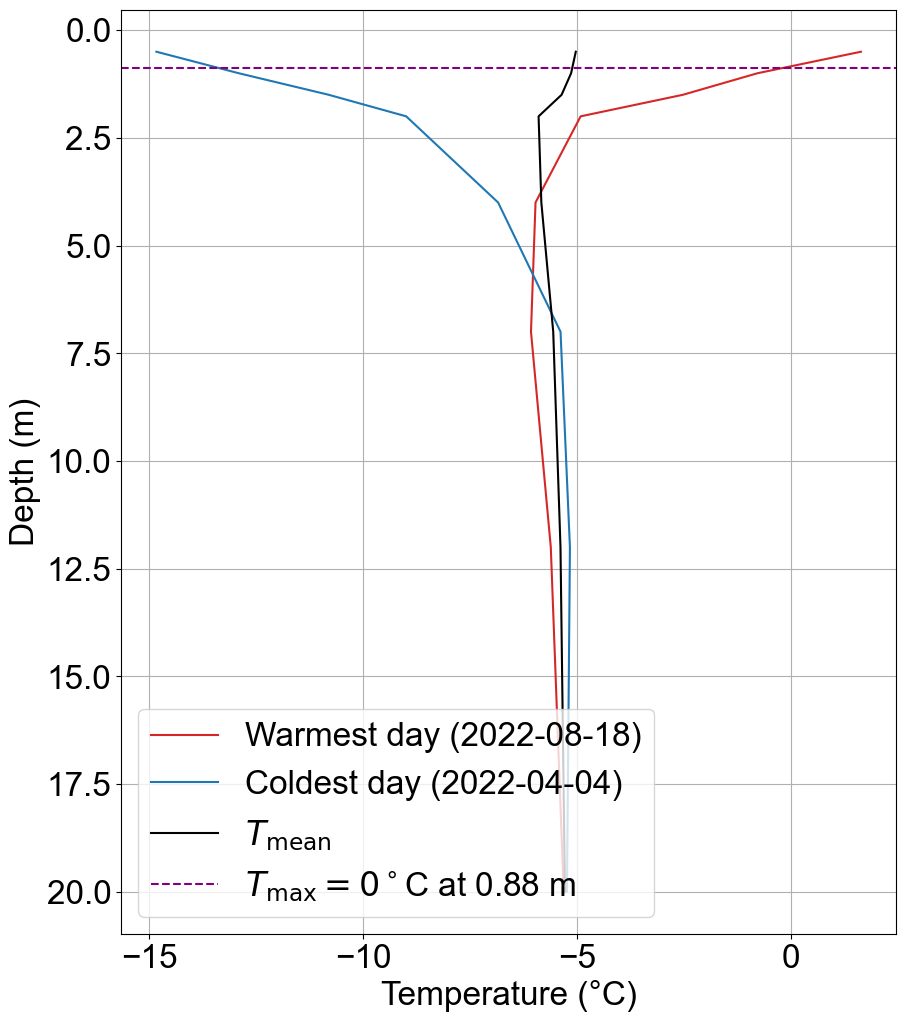

In [1003]:
plt.figure(figsize=(10, 12))
plt.rcParams['font.size'] = 24
plt.rcParams['font.family'] = 'Arial'
plt.style.use('seaborn-v0_8-colorblind')

daily_ground_T_subset = daily_ground_T['2021-08-21T11:00:00.000':'2022-08-21T11:00:00.000']

# Identify warmest and coldest days based on surface temperature
reference_depth = '0.5 m'  # Choose a shallow depth
warmest_day = daily_ground_T_subset[reference_depth].idxmax()
coldest_day = daily_ground_T_subset[reference_depth].idxmin()

# Extract temperature profiles for the warmest and coldest days
warmest_profile = daily_ground_T_subset.loc[warmest_day]
coldest_profile = daily_ground_T_subset.loc[coldest_day]

# Convert index (depths) to float for plotting
depths = warmest_profile.index.str.replace(' m', '').astype(float)

plt.plot(warmest_profile.values, depths, color='tab:red', label=f'Warmest day ({warmest_day.date()})')
plt.plot(coldest_profile.values, depths, color='tab:blue', label=f'Coldest day ({coldest_day.date()})')

# Mean profile
mean_profile = daily_ground_T_subset.mean()
plt.plot(mean_profile.values, depths, color='black', linestyle='-', label=r'$T_{\text{mean}}$')

valid_mask = trumpet_data['max'].notna()
temp_max = trumpet_data['max'][valid_mask].to_numpy()
depths = trumpet_data['Depth'][valid_mask].to_numpy()
temp_mean = trumpet_data['mean'][valid_mask].to_numpy()

# Find the zero-crossing for max temperature
crossing_index = np.where((temp_max[:-1] > 0) & (temp_max[1:] < 0))[0]

if len(crossing_index) > 0:
    idx = crossing_index[0]  # First occurrence
    temp_vals = temp_max[idx:idx+2]
    depth_vals = depths[idx:idx+2]
    
    # Interpolate depth where T_max = 0
    interp_func = interp1d(temp_vals, depth_vals, kind='linear', bounds_error=False, fill_value="extrapolate")
    zero_crossing_depth = interp_func(0)

    # Interpolate mean temperature at that depth
    mean_interp_func = interp1d(depths, temp_mean, kind='linear', bounds_error=False, fill_value="extrapolate")
    mean_temp_at_crossing = mean_interp_func(zero_crossing_depth)

    # Plot horizontal line at zero-crossing depth
    plt.axhline(zero_crossing_depth, color='purple', linestyle='--', label=f'$T_{{\\text{{max}}}} = 0^\circ$C at {zero_crossing_depth:.2f} m')
    
    print(f"Zero-crossing depth (T_max=0°C): {zero_crossing_depth:.2f} m")
    print(f"Mean temperature at this depth: {mean_temp_at_crossing:.2f} °C")
plt.gca().invert_yaxis()
plt.xlabel('Temperature (°C)')
plt.ylabel('Depth (m)')
plt.grid(True)
plt.legend()
plt.show()


Zero-crossing depth (T_max=0°C): 0.88 m
Mean temperature at this depth: -5.12 °C


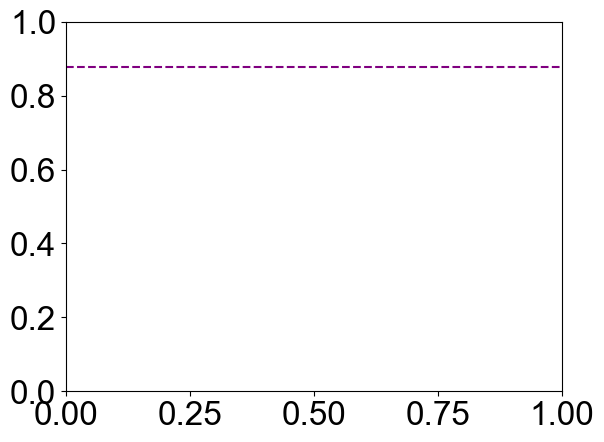

In [1002]:
from scipy.interpolate import interp1d

# Ensure valid data (no NaNs)
valid_mask = trumpet_data['max'].notna()
temp_max = trumpet_data['max'][valid_mask].to_numpy()
depths = trumpet_data['Depth'][valid_mask].to_numpy()
temp_mean = trumpet_data['mean'][valid_mask].to_numpy()

# Find the zero-crossing for max temperature
crossing_index = np.where((temp_max[:-1] > 0) & (temp_max[1:] < 0))[0]

if len(crossing_index) > 0:
    idx = crossing_index[0]  # First occurrence
    temp_vals = temp_max[idx:idx+2]
    depth_vals = depths[idx:idx+2]
    
    # Interpolate depth where T_max = 0
    interp_func = interp1d(temp_vals, depth_vals, kind='linear', bounds_error=False, fill_value="extrapolate")
    zero_crossing_depth = interp_func(0)

    # Interpolate mean temperature at that depth
    mean_interp_func = interp1d(depths, temp_mean, kind='linear', bounds_error=False, fill_value="extrapolate")
    mean_temp_at_crossing = mean_interp_func(zero_crossing_depth)

    # Plot horizontal line at zero-crossing depth
    plt.axhline(zero_crossing_depth, color='purple', linestyle='--', label=f'$T_{{\\text{{max}}}} = 0^\circ$C at {zero_crossing_depth:.2f} m')
    
    print(f"Zero-crossing depth (T_max=0°C): {zero_crossing_depth:.2f} m")
    print(f"Mean temperature at this depth: {mean_temp_at_crossing:.2f} °C")


Statistics for ALL AL values:
 count    144.000000
mean       0.619931
std        0.250310
min        0.220000
25%        0.427500
50%        0.580000
75%        0.715000
max        1.550000
Name: AL, dtype: float64

Statistics EXCLUDING AL = 1.02:
 count    128.000000
mean       0.569922
std        0.218778
min        0.220000
25%        0.417500
50%        0.560000
75%        0.652500
max        1.550000
Name: AL, dtype: float64


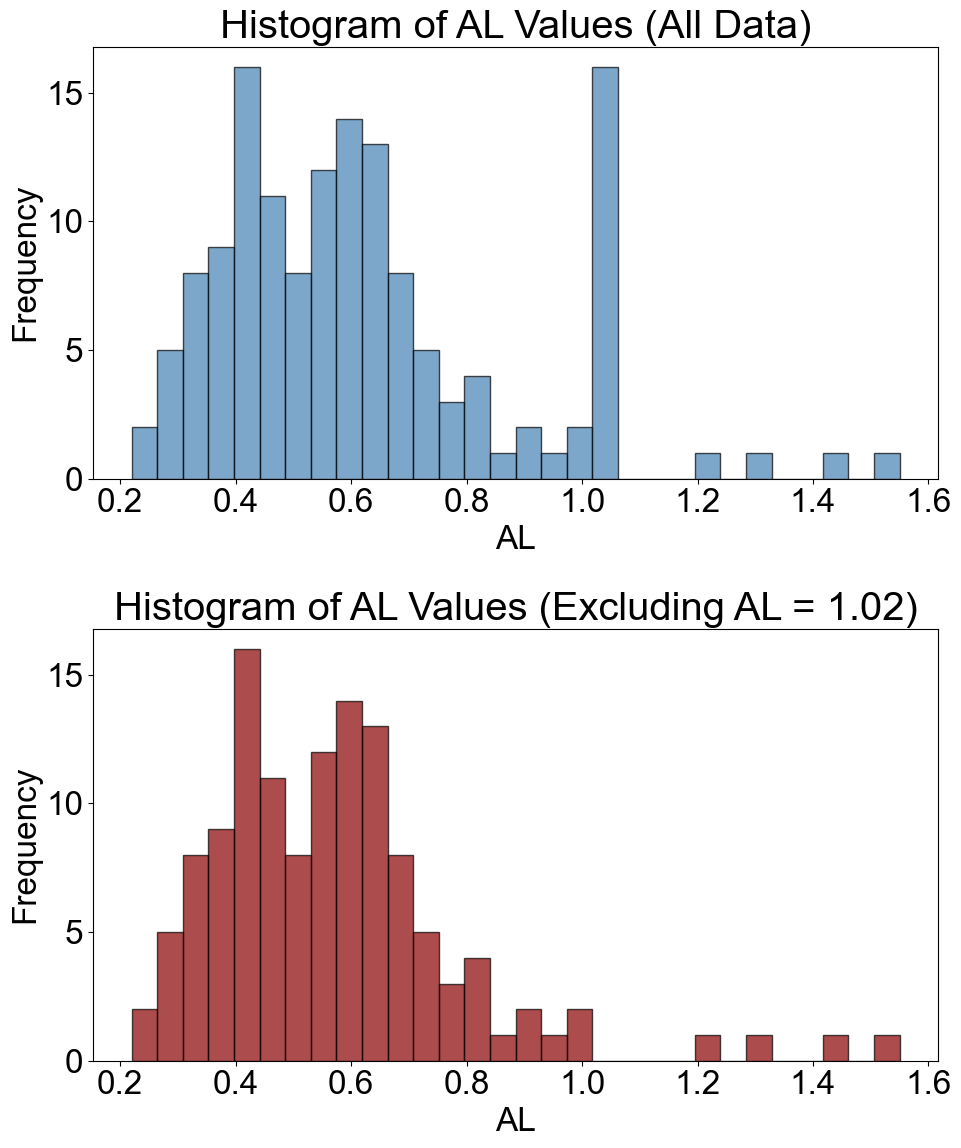

In [1006]:
# Extract AL columns
datasets = {
    "East AL": east_AL["AL"],
    "West AL": west_AL["AL"],
    "East Terrestrial": east_p_AL["AL"],
    "West Terrestrial": west_p_AL["AL"]
}

# Create a single combined dataset
all_AL_values = pd.concat(datasets.values(), ignore_index=True)

# Filter out AL == 1.02
filtered_AL_values = all_AL_values[all_AL_values != 1.02]

# Compute summary statistics
summary_stats = all_AL_values.describe()
filtered_stats = filtered_AL_values.describe()

# Print statistics
print("Statistics for ALL AL values:\n", summary_stats)
print("\nStatistics EXCLUDING AL = 1.02:\n", filtered_stats)

# Plot histograms
fig, axes = plt.subplots(2, 1, figsize=(10, 12))

# Histogram for all AL values
axes[0].hist(all_AL_values, bins=30, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_title("Histogram of AL Values (All Data)")
axes[0].set_xlabel("AL")
axes[0].set_ylabel("Frequency")

# Histogram for AL values excluding 1.02
axes[1].hist(filtered_AL_values, bins=30, color='darkred', edgecolor='black', alpha=0.7)
axes[1].set_title("Histogram of AL Values (Excluding AL = 1.02)")
axes[1].set_xlabel("AL")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()